# Análise de melanoma

Esse jupyter visa em demonstrar uma solução de análise de imagens para predição de cancer do tipo melanoma. Foi utilizado a base do kaggle https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset/data

Nesse trabalho será apresentado o método de treinamento, os resultados com as variações e o código representa o melhor modelo de cada abordagem. Foi feito o treinamento utilizando Tensorflow + Keras.

# Setup

Para o pacote do tensorflow, foi instalado o pacote com o cuda, para funcionar com a GPU. No requirements está separado, mas foi instalado a lib com o seguinte comando:

**python3 -m pip install tensorflow[and-cuda]**

https://www.tensorflow.org/install/pip?hl=pt-br#linux

In [1]:
#Validando a detecção de GPU

import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.config.list_physical_devices('GPU'))

2025-08-10 13:34:56.115215: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 13:34:56.349273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754843696.440552    1046 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754843696.467053    1046 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754843696.666179    1046 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import numpy as np
from tensorflow.keras import layers, models, metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Carregamento e tratamento do dataset

Foi escolhido o tamanho de 224x224 devido ao tamanho original das imagens não ser grande, por se tratarem de imagens próximas da pele das pessoas.

Estamos utilizando também o ImageDataGenerator para gerar imagens com variações, da original

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data generators with resizing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and resize images automatically
train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'  # or 'rgb' for color images
)

test_generator = test_datagen.flow_from_directory(
    './test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


[0. 1.]


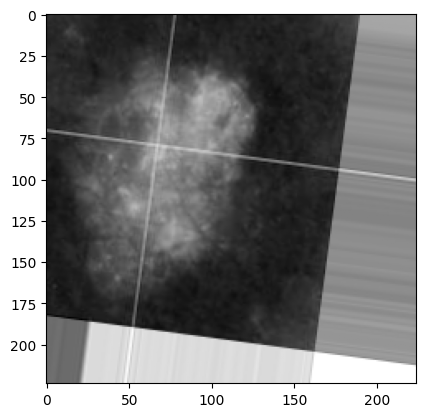

In [28]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

plt.imshow(train_images[3], cmap=plt.cm.binary)
print(train_labels[3])

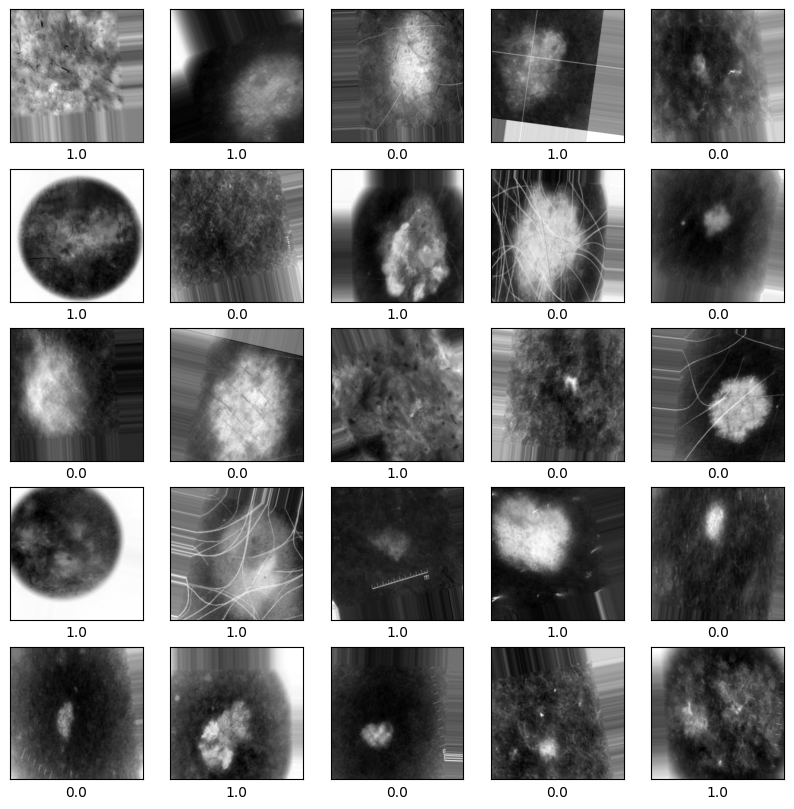

In [31]:
class_names = [[1, 0], [0, 1]]

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(train_labels[i][1])
plt.show()

## Função para extração de labels do generator

Utilizamos essa função para validar o resultado do modelo, extraindo as labels dos dados de teste.

In [8]:
# Função para extrair as labels do generator

def extract_labels_from_generator(generator):
    # Manual approach
    test_images = []
    test_labels = []

    # Reset generator
    generator.reset()

    # Collect all data
    for i in range(len(generator)):
        batch_images, batch_labels = generator[i]
        test_images.append(batch_images)
        test_labels.append(batch_labels)

    # Convert to arrays
    test_images = np.concatenate(test_images, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    print(f"Collected {len(test_images)} test images")
    print(f"Test images shape: {test_images.shape}")
    print(f"Test labels shape: {test_labels.shape}")

    return test_images, test_labels

# Criando a CNN utilizando Keras + Tensorflow

Vamos selecionar e criar as camadas de redes neurais do modelo. Foi utilizada duas convoluções, a primeira de 32 bits, com um kernel de 3x3 e após isso uma com 64 features, ambos utilizando a ativação relu.

Foram escolhidos esses parametros devido a performance de treinamento e também por não ser imagens tão grandes.

Os resultados e código abaixo, representam o melhor resultado obtido de treinamento. No tópico "Variações testadas" irei abordar as variações testadas e seus resultados.

In [5]:
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,1)))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))

model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

model

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754843715.480503    1046 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9515 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


<Sequential name=sequential, built=True>

Nessa etapa, iremos compilar o modelo e treinar o mesmo. Escolhemos as métricas de f1 score que englobam o recall, falso negativos e falso positivos.

In [6]:
my_cnn_callback = [
    ModelCheckpoint(
        'my_cnn_model.keras',
        monitor='val_f1_score',
        save_best_only=True,
        mode='max'
    )
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
        'accuracy',
        metrics.F1Score(name='f1_score'),
        metrics.FalseNegatives(name='false_negatives'),
        metrics.FalsePositives(name='false_positives'),
        metrics.Recall(name='recall')
    ])

history = model.fit(train_generator, epochs=300, validation_data=test_generator, callbacks=my_cnn_callback)

Epoch 1/300


/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1754843721.639527    1149 service.cc:152] XLA service 0x7b971000c590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754843721.639575    1149 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-08-10 13:35:21.697498: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754843721.888400    1149 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/372 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.3976 - f1_score: 0.3310 - false_negatives: 37.3333 - false_positives: 37.3333 - loss: 1.7778 - recall: 0.3976

I0000 00:00:1754843725.772533    1149 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6635 - f1_score: 0.6529 - false_negatives: 1881.0349 - false_positives: 1881.0349 - loss: 0.9364 - recall: 0.6635

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.72949386 0.6370023 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 37s 86ms/step - accuracy: 0.6952 - f1_score: 0.6902 - false_negatives: 3621.0000 - false_positives: 3621.0000 - loss: 0.6201 - recall: 0.6952 - val_accuracy: 0.6900 - val_f1_score: 0.6832 - val_false_negatives: 620.0000 - val_false_positives: 620.0000 - val_loss: 0.5162 - val_recall: 0.6900
Epoch 2/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7345 - f1_score: 0.7330 - false_negatives: 1560.2231 - false_positives: 1560.2231 - loss: 0.4907 - recall: 0.7345

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.7766738 0.693175 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.7427 - f1_score: 0.7411 - false_negatives: 3057.0000 - false_positives: 3057.0000 - loss: 0.4842 - recall: 0.7427 - val_accuracy: 0.7415 - val_f1_score: 0.7349 - val_false_negatives: 517.0000 - val_false_positives: 517.0000 - val_loss: 0.4789 - val_recall: 0.7415
Epoch 3/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7473 - f1_score: 0.7439 - false_negatives: 1495.9919 - false_positives: 1495.9919 - loss: 0.4734 - recall: 0.7473

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.777873  0.6894484]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.7538 - f1_score: 0.7505 - false_negatives: 2925.0000 - false_positives: 2925.0000 - loss: 0.4689 - recall: 0.7538 - val_accuracy: 0.7410 - val_f1_score: 0.7337 - val_false_negatives: 518.0000 - val_false_positives: 518.0000 - val_loss: 0.4676 - val_recall: 0.7410
Epoch 4/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7598 - f1_score: 0.7563 - false_negatives: 1422.0537 - false_positives: 1422.0537 - loss: 0.4659 - recall: 0.7598

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.7466666 0.5544827]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.7628 - f1_score: 0.7593 - false_negatives: 2818.0000 - false_positives: 2818.0000 - loss: 0.4580 - recall: 0.7628 - val_accuracy: 0.6770 - val_f1_score: 0.6506 - val_false_negatives: 646.0000 - val_false_positives: 646.0000 - val_loss: 0.5036 - val_recall: 0.6770
Epoch 5/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7634 - f1_score: 0.7595 - false_negatives: 1376.6210 - false_positives: 1376.6210 - loss: 0.4554 - recall: 0.7634

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.7939262  0.71976393]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.7713 - f1_score: 0.7675 - false_negatives: 2717.0000 - false_positives: 2717.0000 - loss: 0.4482 - recall: 0.7713 - val_accuracy: 0.7625 - val_f1_score: 0.7568 - val_false_negatives: 475.0000 - val_false_positives: 475.0000 - val_loss: 0.4410 - val_recall: 0.7625
Epoch 6/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7779 - f1_score: 0.7747 - false_negatives: 1317.2178 - false_positives: 1317.2178 - loss: 0.4400 - recall: 0.7779

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.80965906 0.7870762 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.7788 - f1_score: 0.7752 - false_negatives: 2628.0000 - false_positives: 2628.0000 - loss: 0.4416 - recall: 0.7788 - val_accuracy: 0.7990 - val_f1_score: 0.7984 - val_false_negatives: 402.0000 - val_false_positives: 402.0000 - val_loss: 0.4031 - val_recall: 0.7990
Epoch 7/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7833 - f1_score: 0.7811 - false_negatives: 1283.3549 - false_positives: 1283.3549 - loss: 0.4336 - recall: 0.7833

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.80052716 0.7366588 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.7885 - f1_score: 0.7855 - false_negatives: 2512.0000 - false_positives: 2512.0000 - loss: 0.4318 - recall: 0.7885 - val_accuracy: 0.7730 - val_f1_score: 0.7686 - val_false_negatives: 454.0000 - val_false_positives: 454.0000 - val_loss: 0.4125 - val_recall: 0.7730
Epoch 8/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7836 - f1_score: 0.7803 - false_negatives: 1284.8334 - false_positives: 1284.8334 - loss: 0.4276 - recall: 0.7836

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.78634053 0.7474085 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.7864 - f1_score: 0.7832 - false_negatives: 2537.0000 - false_positives: 2537.0000 - loss: 0.4254 - recall: 0.7864 - val_accuracy: 0.7685 - val_f1_score: 0.7669 - val_false_negatives: 463.0000 - val_false_positives: 463.0000 - val_loss: 0.4502 - val_recall: 0.7685
Epoch 9/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7987 - f1_score: 0.7957 - false_negatives: 1224.1693 - false_positives: 1224.1693 - loss: 0.4180 - recall: 0.7987

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.7889908  0.68414474]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.7939 - f1_score: 0.7914 - false_negatives: 2448.0000 - false_positives: 2448.0000 - loss: 0.4250 - recall: 0.7939 - val_accuracy: 0.7470 - val_f1_score: 0.7366 - val_false_negatives: 506.0000 - val_false_positives: 506.0000 - val_loss: 0.4570 - val_recall: 0.7470
Epoch 10/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8055 - f1_score: 0.8023 - false_negatives: 1162.9705 - false_positives: 1162.9705 - loss: 0.4044 - recall: 0.8055

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.7916489  0.70417416]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8012 - f1_score: 0.7988 - false_negatives: 2362.0000 - false_positives: 2362.0000 - loss: 0.4126 - recall: 0.8012 - val_accuracy: 0.7555 - val_f1_score: 0.7479 - val_false_negatives: 489.0000 - val_false_positives: 489.0000 - val_loss: 0.4370 - val_recall: 0.7555
Epoch 11/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8074 - f1_score: 0.8045 - false_negatives: 1145.0941 - false_positives: 1145.0941 - loss: 0.4043 - recall: 0.8074

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.84296715 0.8305613 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8054 - f1_score: 0.8032 - false_negatives: 2312.0000 - false_positives: 2312.0000 - loss: 0.4073 - recall: 0.8054 - val_accuracy: 0.8370 - val_f1_score: 0.8368 - val_false_negatives: 326.0000 - val_false_positives: 326.0000 - val_loss: 0.3545 - val_recall: 0.8370
Epoch 12/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8127 - f1_score: 0.8102 - false_negatives: 1103.1720 - false_positives: 1103.1720 - loss: 0.3951 - recall: 0.8127

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8474409 0.8424796]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8136 - f1_score: 0.8119 - false_negatives: 2214.0000 - false_positives: 2214.0000 - loss: 0.3976 - recall: 0.8136 - val_accuracy: 0.8450 - val_f1_score: 0.8450 - val_false_negatives: 310.0000 - val_false_positives: 310.0000 - val_loss: 0.3851 - val_recall: 0.8450
Epoch 13/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8130 - f1_score: 0.8110 - false_negatives: 1090.6666 - false_positives: 1090.6666 - loss: 0.3966 - recall: 0.8130

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8180598 0.7691434]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8183 - f1_score: 0.8165 - false_negatives: 2159.0000 - false_positives: 2159.0000 - loss: 0.3925 - recall: 0.8183 - val_accuracy: 0.7965 - val_f1_score: 0.7936 - val_false_negatives: 407.0000 - val_false_positives: 407.0000 - val_loss: 0.3896 - val_recall: 0.7965
Epoch 14/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8132 - f1_score: 0.8109 - false_negatives: 1096.4919 - false_positives: 1096.4919 - loss: 0.3961 - recall: 0.8132

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8389188  0.86139524]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8189 - f1_score: 0.8173 - false_negatives: 2151.0000 - false_positives: 2151.0000 - loss: 0.3905 - recall: 0.8189 - val_accuracy: 0.8510 - val_f1_score: 0.8502 - val_false_negatives: 298.0000 - val_false_positives: 298.0000 - val_loss: 0.3757 - val_recall: 0.8510
Epoch 15/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8241 - f1_score: 0.8226 - false_negatives: 1036.6210 - false_positives: 1036.6210 - loss: 0.3793 - recall: 0.8241

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.83617896 0.80632836]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8260 - f1_score: 0.8246 - false_negatives: 2067.0000 - false_positives: 2067.0000 - loss: 0.3793 - recall: 0.8260 - val_accuracy: 0.8225 - val_f1_score: 0.8213 - val_false_negatives: 355.0000 - val_false_positives: 355.0000 - val_loss: 0.3667 - val_recall: 0.8225
Epoch 16/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8291 - f1_score: 0.8278 - false_negatives: 1027.1022 - false_positives: 1027.1022 - loss: 0.3848 - recall: 0.8291

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8626292  0.85830367]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8287 - f1_score: 0.8273 - false_negatives: 2035.0000 - false_positives: 2035.0000 - loss: 0.3783 - recall: 0.8287 - val_accuracy: 0.8605 - val_f1_score: 0.8605 - val_false_negatives: 279.0000 - val_false_positives: 279.0000 - val_loss: 0.3191 - val_recall: 0.8605
Epoch 17/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8324 - f1_score: 0.8309 - false_negatives: 1001.0806 - false_positives: 1001.0806 - loss: 0.3752 - recall: 0.8324

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.85206527 0.839416  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8298 - f1_score: 0.8285 - false_negatives: 2022.0000 - false_positives: 2022.0000 - loss: 0.3744 - recall: 0.8298 - val_accuracy: 0.8460 - val_f1_score: 0.8457 - val_false_negatives: 308.0000 - val_false_positives: 308.0000 - val_loss: 0.3493 - val_recall: 0.8460
Epoch 18/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8266 - f1_score: 0.8254 - false_negatives: 1030.4166 - false_positives: 1030.4166 - loss: 0.3704 - recall: 0.8266

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8434864  0.82100743]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8276 - f1_score: 0.8263 - false_negatives: 2048.0000 - false_positives: 2048.0000 - loss: 0.3732 - recall: 0.8276 - val_accuracy: 0.8330 - val_f1_score: 0.8322 - val_false_negatives: 334.0000 - val_false_positives: 334.0000 - val_loss: 0.3509 - val_recall: 0.8330
Epoch 19/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8320 - f1_score: 0.8306 - false_negatives: 984.5161 - false_positives: 984.5161 - loss: 0.3619 - recall: 0.8320

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8617021 0.8519668]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8343 - f1_score: 0.8331 - false_negatives: 1968.0000 - false_positives: 1968.0000 - loss: 0.3665 - recall: 0.8343 - val_accuracy: 0.8570 - val_f1_score: 0.8568 - val_false_negatives: 286.0000 - val_false_positives: 286.0000 - val_loss: 0.3305 - val_recall: 0.8570
Epoch 20/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8294 - f1_score: 0.8279 - false_negatives: 1002.8925 - false_positives: 1002.8925 - loss: 0.3718 - recall: 0.8294

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.83968025 0.8179391 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.8332 - f1_score: 0.8321 - false_negatives: 1981.0000 - false_positives: 1981.0000 - loss: 0.3676 - recall: 0.8332 - val_accuracy: 0.8295 - val_f1_score: 0.8288 - val_false_negatives: 341.0000 - val_false_positives: 341.0000 - val_loss: 0.3500 - val_recall: 0.8295
Epoch 21/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8346 - f1_score: 0.8334 - false_negatives: 979.2070 - false_positives: 979.2070 - loss: 0.3683 - recall: 0.8346

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.84096044 0.8042387 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8356 - f1_score: 0.8344 - false_negatives: 1953.0000 - false_positives: 1953.0000 - loss: 0.3666 - recall: 0.8356 - val_accuracy: 0.8245 - val_f1_score: 0.8226 - val_false_negatives: 351.0000 - val_false_positives: 351.0000 - val_loss: 0.3527 - val_recall: 0.8245
Epoch 22/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8368 - f1_score: 0.8360 - false_negatives: 978.1398 - false_positives: 978.1398 - loss: 0.3649 - recall: 0.8368

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86631006 0.8584662 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8362 - f1_score: 0.8351 - false_negatives: 1946.0000 - false_positives: 1946.0000 - loss: 0.3634 - recall: 0.8362 - val_accuracy: 0.8625 - val_f1_score: 0.8624 - val_false_negatives: 275.0000 - val_false_positives: 275.0000 - val_loss: 0.3219 - val_recall: 0.8625
Epoch 23/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8410 - f1_score: 0.8397 - false_negatives: 951.2823 - false_positives: 951.2823 - loss: 0.3616 - recall: 0.8410

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.83572704 0.7934537 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.8371 - f1_score: 0.8359 - false_negatives: 1935.0000 - false_positives: 1935.0000 - loss: 0.3610 - recall: 0.8371 - val_accuracy: 0.8170 - val_f1_score: 0.8146 - val_false_negatives: 366.0000 - val_false_positives: 366.0000 - val_loss: 0.3637 - val_recall: 0.8170
Epoch 24/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8359 - f1_score: 0.8349 - false_negatives: 985.0753 - false_positives: 985.0753 - loss: 0.3623 - recall: 0.8359

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8613908 0.8490861]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8375 - f1_score: 0.8364 - false_negatives: 1930.0000 - false_positives: 1930.0000 - loss: 0.3573 - recall: 0.8375 - val_accuracy: 0.8555 - val_f1_score: 0.8552 - val_false_negatives: 289.0000 - val_false_positives: 289.0000 - val_loss: 0.3220 - val_recall: 0.8555
Epoch 25/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8409 - f1_score: 0.8398 - false_negatives: 940.4194 - false_positives: 940.4194 - loss: 0.3509 - recall: 0.8409

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8778813  0.87302387]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8423 - f1_score: 0.8413 - false_negatives: 1873.0000 - false_positives: 1873.0000 - loss: 0.3506 - recall: 0.8423 - val_accuracy: 0.8755 - val_f1_score: 0.8755 - val_false_negatives: 249.0000 - val_false_positives: 249.0000 - val_loss: 0.3083 - val_recall: 0.8755
Epoch 26/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8380 - f1_score: 0.8371 - false_negatives: 964.9059 - false_positives: 964.9059 - loss: 0.3504 - recall: 0.8380

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.85522527 0.8422152 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8413 - f1_score: 0.8403 - false_negatives: 1885.0000 - false_positives: 1885.0000 - loss: 0.3530 - recall: 0.8413 - val_accuracy: 0.8490 - val_f1_score: 0.8487 - val_false_negatives: 302.0000 - val_false_positives: 302.0000 - val_loss: 0.3357 - val_recall: 0.8490
Epoch 27/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8427 - f1_score: 0.8419 - false_negatives: 952.2043 - false_positives: 952.2043 - loss: 0.3433 - recall: 0.8427

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8606598  0.85627216]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.8411 - f1_score: 0.8400 - false_negatives: 1888.0000 - false_positives: 1888.0000 - loss: 0.3493 - recall: 0.8411 - val_accuracy: 0.8585 - val_f1_score: 0.8585 - val_false_negatives: 283.0000 - val_false_positives: 283.0000 - val_loss: 0.3176 - val_recall: 0.8585
Epoch 28/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8509 - f1_score: 0.8501 - false_negatives: 904.1532 - false_positives: 904.1532 - loss: 0.3372 - recall: 0.8509

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8659383  0.86404824]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8473 - f1_score: 0.8463 - false_negatives: 1814.0000 - false_positives: 1814.0000 - loss: 0.3450 - recall: 0.8473 - val_accuracy: 0.8650 - val_f1_score: 0.8650 - val_false_negatives: 270.0000 - val_false_positives: 270.0000 - val_loss: 0.3157 - val_recall: 0.8650
Epoch 29/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8506 - f1_score: 0.8492 - false_negatives: 899.0269 - false_positives: 899.0269 - loss: 0.3385 - recall: 0.8506

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.85421515 0.8310846 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8481 - f1_score: 0.8471 - false_negatives: 1804.0000 - false_positives: 1804.0000 - loss: 0.3472 - recall: 0.8481 - val_accuracy: 0.8435 - val_f1_score: 0.8426 - val_false_negatives: 313.0000 - val_false_positives: 313.0000 - val_loss: 0.3333 - val_recall: 0.8435
Epoch 30/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8410 - f1_score: 0.8400 - false_negatives: 942.7312 - false_positives: 942.7312 - loss: 0.3502 - recall: 0.8410

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87358576 0.8693441 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8452 - f1_score: 0.8442 - false_negatives: 1839.0000 - false_positives: 1839.0000 - loss: 0.3438 - recall: 0.8452 - val_accuracy: 0.8715 - val_f1_score: 0.8715 - val_false_negatives: 257.0000 - val_false_positives: 257.0000 - val_loss: 0.3075 - val_recall: 0.8715
Epoch 31/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8483 - f1_score: 0.8474 - false_negatives: 896.7930 - false_positives: 896.7930 - loss: 0.3411 - recall: 0.8483

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86764014 0.8502929 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8488 - f1_score: 0.8478 - false_negatives: 1796.0000 - false_positives: 1796.0000 - loss: 0.3424 - recall: 0.8488 - val_accuracy: 0.8595 - val_f1_score: 0.8590 - val_false_negatives: 281.0000 - val_false_positives: 281.0000 - val_loss: 0.3102 - val_recall: 0.8595
Epoch 32/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8505 - f1_score: 0.8497 - false_negatives: 878.4032 - false_positives: 878.4032 - loss: 0.3414 - recall: 0.8505

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8692715 0.8593669]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.8505 - f1_score: 0.8496 - false_negatives: 1776.0000 - false_positives: 1776.0000 - loss: 0.3389 - recall: 0.8505 - val_accuracy: 0.8645 - val_f1_score: 0.8643 - val_false_negatives: 271.0000 - val_false_positives: 271.0000 - val_loss: 0.3127 - val_recall: 0.8645
Epoch 33/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8443 - f1_score: 0.8432 - false_negatives: 926.6640 - false_positives: 926.6640 - loss: 0.3500 - recall: 0.8443

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86603767 0.8489361 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8459 - f1_score: 0.8450 - false_negatives: 1830.0000 - false_positives: 1830.0000 - loss: 0.3434 - recall: 0.8459 - val_accuracy: 0.8580 - val_f1_score: 0.8575 - val_false_negatives: 284.0000 - val_false_positives: 284.0000 - val_loss: 0.3091 - val_recall: 0.8580
Epoch 34/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8551 - f1_score: 0.8541 - false_negatives: 867.0833 - false_positives: 867.0833 - loss: 0.3363 - recall: 0.8551

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86280054 0.8451303 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8535 - f1_score: 0.8525 - false_negatives: 1740.0000 - false_positives: 1740.0000 - loss: 0.3393 - recall: 0.8535 - val_accuracy: 0.8545 - val_f1_score: 0.8540 - val_false_negatives: 291.0000 - val_false_positives: 291.0000 - val_loss: 0.3160 - val_recall: 0.8545
Epoch 35/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8466 - f1_score: 0.8457 - false_negatives: 899.8038 - false_positives: 899.8038 - loss: 0.3455 - recall: 0.8466

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.84604967 0.80896354]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8509 - f1_score: 0.8499 - false_negatives: 1771.0000 - false_positives: 1771.0000 - loss: 0.3412 - recall: 0.8509 - val_accuracy: 0.8295 - val_f1_score: 0.8275 - val_false_negatives: 341.0000 - val_false_positives: 341.0000 - val_loss: 0.3501 - val_recall: 0.8295
Epoch 36/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8541 - f1_score: 0.8523 - false_negatives: 882.7339 - false_positives: 882.7339 - loss: 0.3327 - recall: 0.8541

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86592174 0.8444924 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8490 - f1_score: 0.8480 - false_negatives: 1794.0000 - false_positives: 1794.0000 - loss: 0.3356 - recall: 0.8490 - val_accuracy: 0.8560 - val_f1_score: 0.8552 - val_false_negatives: 288.0000 - val_false_positives: 288.0000 - val_loss: 0.3216 - val_recall: 0.8560
Epoch 37/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8519 - f1_score: 0.8510 - false_negatives: 890.8575 - false_positives: 890.8575 - loss: 0.3361 - recall: 0.8519

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.85662264 0.8252911 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8496 - f1_score: 0.8486 - false_negatives: 1787.0000 - false_positives: 1787.0000 - loss: 0.3385 - recall: 0.8496 - val_accuracy: 0.8425 - val_f1_score: 0.8410 - val_false_negatives: 315.0000 - val_false_positives: 315.0000 - val_loss: 0.3328 - val_recall: 0.8425
Epoch 38/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8489 - f1_score: 0.8480 - false_negatives: 885.5484 - false_positives: 885.5484 - loss: 0.3401 - recall: 0.8489

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.84257597 0.8004534 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8518 - f1_score: 0.8509 - false_negatives: 1760.0000 - false_positives: 1760.0000 - loss: 0.3356 - recall: 0.8518 - val_accuracy: 0.8240 - val_f1_score: 0.8215 - val_false_negatives: 352.0000 - val_false_positives: 352.0000 - val_loss: 0.3587 - val_recall: 0.8240
Epoch 39/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8529 - f1_score: 0.8517 - false_negatives: 887.0995 - false_positives: 887.0995 - loss: 0.3306 - recall: 0.8529

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.866828   0.85788107]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8528 - f1_score: 0.8518 - false_negatives: 1749.0000 - false_positives: 1749.0000 - loss: 0.3335 - recall: 0.8528 - val_accuracy: 0.8625 - val_f1_score: 0.8624 - val_false_negatives: 275.0000 - val_false_positives: 275.0000 - val_loss: 0.3265 - val_recall: 0.8625
Epoch 40/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8644 - f1_score: 0.8635 - false_negatives: 830.8978 - false_positives: 830.8978 - loss: 0.3202 - recall: 0.8644

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8716183 0.8673106]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8558 - f1_score: 0.8549 - false_negatives: 1713.0000 - false_positives: 1713.0000 - loss: 0.3296 - recall: 0.8558 - val_accuracy: 0.8695 - val_f1_score: 0.8695 - val_false_negatives: 261.0000 - val_false_positives: 261.0000 - val_loss: 0.3208 - val_recall: 0.8695
Epoch 41/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8559 - f1_score: 0.8549 - false_negatives: 857.2661 - false_positives: 857.2661 - loss: 0.3295 - recall: 0.8559

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.85606414 0.8378521 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8545 - f1_score: 0.8536 - false_negatives: 1728.0000 - false_positives: 1728.0000 - loss: 0.3302 - recall: 0.8545 - val_accuracy: 0.8475 - val_f1_score: 0.8470 - val_false_negatives: 305.0000 - val_false_positives: 305.0000 - val_loss: 0.3395 - val_recall: 0.8475
Epoch 42/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8561 - f1_score: 0.8552 - false_negatives: 866.1102 - false_positives: 866.1102 - loss: 0.3229 - recall: 0.8561

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87047607 0.85684204]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8537 - f1_score: 0.8528 - false_negatives: 1738.0000 - false_positives: 1738.0000 - loss: 0.3280 - recall: 0.8537 - val_accuracy: 0.8640 - val_f1_score: 0.8637 - val_false_negatives: 272.0000 - val_false_positives: 272.0000 - val_loss: 0.3018 - val_recall: 0.8640
Epoch 43/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8534 - f1_score: 0.8525 - false_negatives: 874.3817 - false_positives: 874.3817 - loss: 0.3266 - recall: 0.8534

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86977184 0.85548514]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8523 - f1_score: 0.8514 - false_negatives: 1754.0000 - false_positives: 1754.0000 - loss: 0.3300 - recall: 0.8523 - val_accuracy: 0.8630 - val_f1_score: 0.8626 - val_false_negatives: 274.0000 - val_false_positives: 274.0000 - val_loss: 0.3262 - val_recall: 0.8630
Epoch 44/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8527 - f1_score: 0.8520 - false_negatives: 871.3656 - false_positives: 871.3656 - loss: 0.3273 - recall: 0.8527

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8774928 0.8637803]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8544 - f1_score: 0.8535 - false_negatives: 1729.0000 - false_positives: 1729.0000 - loss: 0.3293 - recall: 0.8544 - val_accuracy: 0.8710 - val_f1_score: 0.8706 - val_false_negatives: 258.0000 - val_false_positives: 258.0000 - val_loss: 0.3176 - val_recall: 0.8710
Epoch 45/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8552 - f1_score: 0.8540 - false_negatives: 855.2795 - false_positives: 855.2795 - loss: 0.3310 - recall: 0.8552

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8657844 0.8492569]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8568 - f1_score: 0.8559 - false_negatives: 1701.0000 - false_positives: 1701.0000 - loss: 0.3292 - recall: 0.8568 - val_accuracy: 0.8580 - val_f1_score: 0.8575 - val_false_negatives: 284.0000 - val_false_positives: 284.0000 - val_loss: 0.3174 - val_recall: 0.8580
Epoch 46/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8561 - f1_score: 0.8551 - false_negatives: 857.2070 - false_positives: 857.2070 - loss: 0.3313 - recall: 0.8561

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87548256 0.86618257]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8556 - f1_score: 0.8548 - false_negatives: 1715.0000 - false_positives: 1715.0000 - loss: 0.3230 - recall: 0.8556 - val_accuracy: 0.8710 - val_f1_score: 0.8708 - val_false_negatives: 258.0000 - val_false_positives: 258.0000 - val_loss: 0.2921 - val_recall: 0.8710
Epoch 47/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8594 - f1_score: 0.8588 - false_negatives: 834.4623 - false_positives: 834.4623 - loss: 0.3224 - recall: 0.8594

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8491001  0.82160383]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8566 - f1_score: 0.8557 - false_negatives: 1704.0000 - false_positives: 1704.0000 - loss: 0.3283 - recall: 0.8566 - val_accuracy: 0.8365 - val_f1_score: 0.8354 - val_false_negatives: 327.0000 - val_false_positives: 327.0000 - val_loss: 0.3443 - val_recall: 0.8365
Epoch 48/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8507 - f1_score: 0.8496 - false_negatives: 883.7043 - false_positives: 883.7043 - loss: 0.3281 - recall: 0.8507

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.84331995 0.79793924]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8525 - f1_score: 0.8516 - false_negatives: 1752.0000 - false_positives: 1752.0000 - loss: 0.3270 - recall: 0.8525 - val_accuracy: 0.8235 - val_f1_score: 0.8206 - val_false_negatives: 353.0000 - val_false_positives: 353.0000 - val_loss: 0.3501 - val_recall: 0.8235
Epoch 49/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8612 - f1_score: 0.8601 - false_negatives: 844.0726 - false_positives: 844.0726 - loss: 0.3264 - recall: 0.8612

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8843337  0.87852377]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8569 - f1_score: 0.8559 - false_negatives: 1700.0000 - false_positives: 1700.0000 - loss: 0.3262 - recall: 0.8569 - val_accuracy: 0.8815 - val_f1_score: 0.8814 - val_false_negatives: 237.0000 - val_false_positives: 237.0000 - val_loss: 0.2820 - val_recall: 0.8815
Epoch 50/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8547 - f1_score: 0.8536 - false_negatives: 865.7339 - false_positives: 865.7339 - loss: 0.3284 - recall: 0.8547

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88484246 0.8810975 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8554 - f1_score: 0.8544 - false_negatives: 1718.0000 - false_positives: 1718.0000 - loss: 0.3271 - recall: 0.8554 - val_accuracy: 0.8830 - val_f1_score: 0.8830 - val_false_negatives: 234.0000 - val_false_positives: 234.0000 - val_loss: 0.2772 - val_recall: 0.8830
Epoch 51/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8585 - f1_score: 0.8573 - false_negatives: 848.3145 - false_positives: 848.3145 - loss: 0.3198 - recall: 0.8585

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87676567 0.87005645]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8586 - f1_score: 0.8578 - false_negatives: 1680.0000 - false_positives: 1680.0000 - loss: 0.3250 - recall: 0.8586 - val_accuracy: 0.8735 - val_f1_score: 0.8734 - val_false_negatives: 253.0000 - val_false_positives: 253.0000 - val_loss: 0.2951 - val_recall: 0.8735
Epoch 52/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8590 - f1_score: 0.8582 - false_negatives: 853.8333 - false_positives: 853.8333 - loss: 0.3228 - recall: 0.8590

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88413715 0.88285565]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8545 - f1_score: 0.8537 - false_negatives: 1728.0000 - false_positives: 1728.0000 - loss: 0.3280 - recall: 0.8545 - val_accuracy: 0.8835 - val_f1_score: 0.8835 - val_false_negatives: 233.0000 - val_false_positives: 233.0000 - val_loss: 0.2811 - val_recall: 0.8835
Epoch 53/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8567 - f1_score: 0.8557 - false_negatives: 853.2312 - false_positives: 853.2312 - loss: 0.3221 - recall: 0.8567

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8720112 0.853776 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8570 - f1_score: 0.8562 - false_negatives: 1699.0000 - false_positives: 1699.0000 - loss: 0.3232 - recall: 0.8570 - val_accuracy: 0.8635 - val_f1_score: 0.8629 - val_false_negatives: 273.0000 - val_false_positives: 273.0000 - val_loss: 0.3116 - val_recall: 0.8635
Epoch 54/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8620 - f1_score: 0.8610 - false_negatives: 823.3226 - false_positives: 823.3226 - loss: 0.3188 - recall: 0.8620

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8499999 0.8166666]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8612 - f1_score: 0.8603 - false_negatives: 1649.0000 - false_positives: 1649.0000 - loss: 0.3198 - recall: 0.8612 - val_accuracy: 0.8350 - val_f1_score: 0.8333 - val_false_negatives: 330.0000 - val_false_positives: 330.0000 - val_loss: 0.3458 - val_recall: 0.8350
Epoch 55/300
371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8525 - f1_score: 0.8517 - false_negatives: 861.7251 - false_positives: 861.7251 - loss: 0.3264 - recall: 0.8525

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8703441 0.8536455]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8571 - f1_score: 0.8561 - false_negatives: 1698.0000 - false_positives: 1698.0000 - loss: 0.3216 - recall: 0.8571 - val_accuracy: 0.8625 - val_f1_score: 0.8620 - val_false_negatives: 275.0000 - val_false_positives: 275.0000 - val_loss: 0.3180 - val_recall: 0.8625
Epoch 56/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8592 - f1_score: 0.8582 - false_negatives: 843.6747 - false_positives: 843.6747 - loss: 0.3252 - recall: 0.8592

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87653154 0.86048985]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8589 - f1_score: 0.8580 - false_negatives: 1676.0000 - false_positives: 1676.0000 - loss: 0.3209 - recall: 0.8589 - val_accuracy: 0.8690 - val_f1_score: 0.8685 - val_false_negatives: 262.0000 - val_false_positives: 262.0000 - val_loss: 0.3177 - val_recall: 0.8690
Epoch 57/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8629 - f1_score: 0.8621 - false_negatives: 834.6049 - false_positives: 834.6049 - loss: 0.3135 - recall: 0.8629

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.871819   0.85516495]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8586 - f1_score: 0.8577 - false_negatives: 1680.0000 - false_positives: 1680.0000 - loss: 0.3184 - recall: 0.8586 - val_accuracy: 0.8640 - val_f1_score: 0.8635 - val_false_negatives: 272.0000 - val_false_positives: 272.0000 - val_loss: 0.3149 - val_recall: 0.8640
Epoch 58/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8581 - f1_score: 0.8572 - false_negatives: 847.0457 - false_positives: 847.0457 - loss: 0.3183 - recall: 0.8581

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.85976166 0.8316831 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8585 - f1_score: 0.8576 - false_negatives: 1681.0000 - false_positives: 1681.0000 - loss: 0.3159 - recall: 0.8585 - val_accuracy: 0.8470 - val_f1_score: 0.8457 - val_false_negatives: 306.0000 - val_false_positives: 306.0000 - val_loss: 0.3390 - val_recall: 0.8470
Epoch 59/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8682 - f1_score: 0.8671 - false_negatives: 812.9355 - false_positives: 812.9355 - loss: 0.3120 - recall: 0.8682

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8801515  0.86606663]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8582 - f1_score: 0.8573 - false_negatives: 1684.0000 - false_positives: 1684.0000 - loss: 0.3213 - recall: 0.8582 - val_accuracy: 0.8735 - val_f1_score: 0.8731 - val_false_negatives: 253.0000 - val_false_positives: 253.0000 - val_loss: 0.3083 - val_recall: 0.8735
Epoch 60/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8591 - f1_score: 0.8581 - false_negatives: 839.7150 - false_positives: 839.7150 - loss: 0.3231 - recall: 0.8591

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.877037   0.87392396]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8600 - f1_score: 0.8592 - false_negatives: 1663.0000 - false_positives: 1663.0000 - loss: 0.3173 - recall: 0.8600 - val_accuracy: 0.8755 - val_f1_score: 0.8755 - val_false_negatives: 249.0000 - val_false_positives: 249.0000 - val_loss: 0.2930 - val_recall: 0.8755
Epoch 61/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8572 - f1_score: 0.8566 - false_negatives: 849.0242 - false_positives: 849.0242 - loss: 0.3180 - recall: 0.8572

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.881105 0.877851]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8587 - f1_score: 0.8579 - false_negatives: 1678.0000 - false_positives: 1678.0000 - loss: 0.3189 - recall: 0.8587 - val_accuracy: 0.8795 - val_f1_score: 0.8795 - val_false_negatives: 241.0000 - val_false_positives: 241.0000 - val_loss: 0.2797 - val_recall: 0.8795
Epoch 62/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8634 - f1_score: 0.8626 - false_negatives: 811.6290 - false_positives: 811.6290 - loss: 0.3134 - recall: 0.8634

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8817517 0.8750642]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8625 - f1_score: 0.8618 - false_negatives: 1633.0000 - false_positives: 1633.0000 - loss: 0.3119 - recall: 0.8625 - val_accuracy: 0.8785 - val_f1_score: 0.8784 - val_false_negatives: 243.0000 - val_false_positives: 243.0000 - val_loss: 0.2941 - val_recall: 0.8785
Epoch 63/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8645 - f1_score: 0.8634 - false_negatives: 821.3091 - false_positives: 821.3091 - loss: 0.3104 - recall: 0.8645

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8711832 0.8581932]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8603 - f1_score: 0.8595 - false_negatives: 1659.0000 - false_positives: 1659.0000 - loss: 0.3150 - recall: 0.8603 - val_accuracy: 0.8650 - val_f1_score: 0.8647 - val_false_negatives: 270.0000 - val_false_positives: 270.0000 - val_loss: 0.3146 - val_recall: 0.8650
Epoch 64/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8610 - f1_score: 0.8604 - false_negatives: 830.7634 - false_positives: 830.7634 - loss: 0.3186 - recall: 0.8610

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.854934  0.8228761]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8627 - f1_score: 0.8620 - false_negatives: 1631.0000 - false_positives: 1631.0000 - loss: 0.3103 - recall: 0.8627 - val_accuracy: 0.8405 - val_f1_score: 0.8389 - val_false_negatives: 319.0000 - val_false_positives: 319.0000 - val_loss: 0.3320 - val_recall: 0.8405
Epoch 65/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8606 - f1_score: 0.8592 - false_negatives: 823.2688 - false_positives: 823.2688 - loss: 0.3215 - recall: 0.8606

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.873629   0.86074615]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8603 - f1_score: 0.8595 - false_negatives: 1659.0000 - false_positives: 1659.0000 - loss: 0.3178 - recall: 0.8603 - val_accuracy: 0.8675 - val_f1_score: 0.8672 - val_false_negatives: 265.0000 - val_false_positives: 265.0000 - val_loss: 0.2893 - val_recall: 0.8675
Epoch 66/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8575 - f1_score: 0.8567 - false_negatives: 837.5779 - false_positives: 837.5779 - loss: 0.3227 - recall: 0.8575

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8767907 0.8646379]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8580 - f1_score: 0.8571 - false_negatives: 1687.0000 - false_positives: 1687.0000 - loss: 0.3249 - recall: 0.8580 - val_accuracy: 0.8710 - val_f1_score: 0.8707 - val_false_negatives: 258.0000 - val_false_positives: 258.0000 - val_loss: 0.2913 - val_recall: 0.8710
Epoch 67/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8648 - f1_score: 0.8638 - false_negatives: 811.2877 - false_positives: 811.2877 - loss: 0.3160 - recall: 0.8648

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8775413 0.8625994]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8650 - f1_score: 0.8641 - false_negatives: 1604.0000 - false_positives: 1604.0000 - loss: 0.3122 - recall: 0.8650 - val_accuracy: 0.8705 - val_f1_score: 0.8701 - val_false_negatives: 259.0000 - val_false_positives: 259.0000 - val_loss: 0.2917 - val_recall: 0.8705
Epoch 68/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8649 - f1_score: 0.8634 - false_negatives: 806.9919 - false_positives: 806.9919 - loss: 0.3104 - recall: 0.8649

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.858572 0.827318]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8620 - f1_score: 0.8612 - false_negatives: 1639.0000 - false_positives: 1639.0000 - loss: 0.3124 - recall: 0.8620 - val_accuracy: 0.8445 - val_f1_score: 0.8429 - val_false_negatives: 311.0000 - val_false_positives: 311.0000 - val_loss: 0.3285 - val_recall: 0.8445
Epoch 69/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8654 - f1_score: 0.8646 - false_negatives: 789.8951 - false_positives: 789.8951 - loss: 0.3122 - recall: 0.8654

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8733705 0.8531317]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8651 - f1_score: 0.8644 - false_negatives: 1602.0000 - false_positives: 1602.0000 - loss: 0.3098 - recall: 0.8651 - val_accuracy: 0.8640 - val_f1_score: 0.8633 - val_false_negatives: 272.0000 - val_false_positives: 272.0000 - val_loss: 0.3203 - val_recall: 0.8640
Epoch 70/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8671 - f1_score: 0.8663 - false_negatives: 810.5833 - false_positives: 810.5833 - loss: 0.3062 - recall: 0.8671

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.885939   0.88199383]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8624 - f1_score: 0.8616 - false_negatives: 1635.0000 - false_positives: 1635.0000 - loss: 0.3102 - recall: 0.8624 - val_accuracy: 0.8840 - val_f1_score: 0.8840 - val_false_negatives: 232.0000 - val_false_positives: 232.0000 - val_loss: 0.2827 - val_recall: 0.8840
Epoch 71/300
371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8666 - f1_score: 0.8659 - false_negatives: 799.1617 - false_positives: 799.1617 - loss: 0.3084 - recall: 0.8666

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8583105 0.8264737]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8646 - f1_score: 0.8638 - false_negatives: 1608.0000 - false_positives: 1608.0000 - loss: 0.3094 - recall: 0.8646 - val_accuracy: 0.8440 - val_f1_score: 0.8424 - val_false_negatives: 312.0000 - val_false_positives: 312.0000 - val_loss: 0.3373 - val_recall: 0.8440
Epoch 72/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8566 - f1_score: 0.8557 - false_negatives: 843.8360 - false_positives: 843.8360 - loss: 0.3211 - recall: 0.8566

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8668213  0.84444445]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8614 - f1_score: 0.8605 - false_negatives: 1647.0000 - false_positives: 1647.0000 - loss: 0.3142 - recall: 0.8614 - val_accuracy: 0.8565 - val_f1_score: 0.8556 - val_false_negatives: 287.0000 - val_false_positives: 287.0000 - val_loss: 0.3160 - val_recall: 0.8565
Epoch 73/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8621 - f1_score: 0.8612 - false_negatives: 809.9919 - false_positives: 809.9919 - loss: 0.3073 - recall: 0.8621

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.878291  0.8766985]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8647 - f1_score: 0.8639 - false_negatives: 1607.0000 - false_positives: 1607.0000 - loss: 0.3079 - recall: 0.8647 - val_accuracy: 0.8775 - val_f1_score: 0.8775 - val_false_negatives: 245.0000 - val_false_positives: 245.0000 - val_loss: 0.2971 - val_recall: 0.8775
Epoch 74/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8655 - f1_score: 0.8650 - false_negatives: 807.2877 - false_positives: 807.2877 - loss: 0.3059 - recall: 0.8655

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8734654 0.8575982]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8627 - f1_score: 0.8618 - false_negatives: 1631.0000 - false_positives: 1631.0000 - loss: 0.3050 - recall: 0.8627 - val_accuracy: 0.8660 - val_f1_score: 0.8655 - val_false_negatives: 268.0000 - val_false_positives: 268.0000 - val_loss: 0.3069 - val_recall: 0.8660
Epoch 75/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8627 - f1_score: 0.8615 - false_negatives: 810.1721 - false_positives: 810.1721 - loss: 0.3152 - recall: 0.8627

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87330526 0.85437936]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8639 - f1_score: 0.8631 - false_negatives: 1617.0000 - false_positives: 1617.0000 - loss: 0.3072 - recall: 0.8639 - val_accuracy: 0.8645 - val_f1_score: 0.8638 - val_false_negatives: 271.0000 - val_false_positives: 271.0000 - val_loss: 0.3038 - val_recall: 0.8645
Epoch 76/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8697 - f1_score: 0.8689 - false_negatives: 789.6613 - false_positives: 789.6613 - loss: 0.3014 - recall: 0.8697

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.85845166 0.8299394 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8648 - f1_score: 0.8640 - false_negatives: 1606.0000 - false_positives: 1606.0000 - loss: 0.3061 - recall: 0.8648 - val_accuracy: 0.8455 - val_f1_score: 0.8442 - val_false_negatives: 309.0000 - val_false_positives: 309.0000 - val_loss: 0.3213 - val_recall: 0.8455
Epoch 77/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8638 - f1_score: 0.8628 - false_negatives: 800.0484 - false_positives: 800.0484 - loss: 0.3094 - recall: 0.8638

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87305325 0.8569909 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8629 - f1_score: 0.8620 - false_negatives: 1629.0000 - false_positives: 1629.0000 - loss: 0.3096 - recall: 0.8629 - val_accuracy: 0.8655 - val_f1_score: 0.8650 - val_false_negatives: 269.0000 - val_false_positives: 269.0000 - val_loss: 0.3024 - val_recall: 0.8655
Epoch 78/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8716 - f1_score: 0.8707 - false_negatives: 783.2850 - false_positives: 783.2850 - loss: 0.3048 - recall: 0.8716

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8692779  0.85273784]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8680 - f1_score: 0.8672 - false_negatives: 1568.0000 - false_positives: 1568.0000 - loss: 0.3073 - recall: 0.8680 - val_accuracy: 0.8615 - val_f1_score: 0.8610 - val_false_negatives: 277.0000 - val_false_positives: 277.0000 - val_loss: 0.3064 - val_recall: 0.8615
Epoch 79/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8635 - f1_score: 0.8627 - false_negatives: 824.2877 - false_positives: 824.2877 - loss: 0.3112 - recall: 0.8635

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8788167 0.8665965]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8641 - f1_score: 0.8633 - false_negatives: 1614.0000 - false_positives: 1614.0000 - loss: 0.3106 - recall: 0.8641 - val_accuracy: 0.8730 - val_f1_score: 0.8727 - val_false_negatives: 254.0000 - val_false_positives: 254.0000 - val_loss: 0.2983 - val_recall: 0.8730
Epoch 80/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8705 - f1_score: 0.8695 - false_negatives: 771.3898 - false_positives: 771.3898 - loss: 0.3081 - recall: 0.8705

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8823528  0.87755096]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8694 - f1_score: 0.8687 - false_negatives: 1551.0000 - false_positives: 1551.0000 - loss: 0.3042 - recall: 0.8694 - val_accuracy: 0.8800 - val_f1_score: 0.8800 - val_false_negatives: 240.0000 - val_false_positives: 240.0000 - val_loss: 0.2834 - val_recall: 0.8800
Epoch 81/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8675 - f1_score: 0.8667 - false_negatives: 788.9839 - false_positives: 788.9839 - loss: 0.3031 - recall: 0.8675

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8719626  0.85268813]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8671 - f1_score: 0.8664 - false_negatives: 1579.0000 - false_positives: 1579.0000 - loss: 0.3011 - recall: 0.8671 - val_accuracy: 0.8630 - val_f1_score: 0.8623 - val_false_negatives: 274.0000 - val_false_positives: 274.0000 - val_loss: 0.3115 - val_recall: 0.8630
Epoch 82/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8609 - f1_score: 0.8601 - false_negatives: 828.2823 - false_positives: 828.2823 - loss: 0.3084 - recall: 0.8609

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86160916 0.83506846]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8624 - f1_score: 0.8616 - false_negatives: 1635.0000 - false_positives: 1635.0000 - loss: 0.3075 - recall: 0.8624 - val_accuracy: 0.8495 - val_f1_score: 0.8483 - val_false_negatives: 301.0000 - val_false_positives: 301.0000 - val_loss: 0.3216 - val_recall: 0.8495
Epoch 83/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8664 - f1_score: 0.8655 - false_negatives: 804.2877 - false_positives: 804.2877 - loss: 0.3009 - recall: 0.8664

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87152934 0.8544    ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8655 - f1_score: 0.8646 - false_negatives: 1598.0000 - false_positives: 1598.0000 - loss: 0.3006 - recall: 0.8655 - val_accuracy: 0.8635 - val_f1_score: 0.8630 - val_false_negatives: 273.0000 - val_false_positives: 273.0000 - val_loss: 0.3221 - val_recall: 0.8635
Epoch 84/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8697 - f1_score: 0.8689 - false_negatives: 774.4946 - false_positives: 774.4946 - loss: 0.2960 - recall: 0.8697

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88240916 0.8710692 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8672 - f1_score: 0.8665 - false_negatives: 1577.0000 - false_positives: 1577.0000 - loss: 0.3014 - recall: 0.8672 - val_accuracy: 0.8770 - val_f1_score: 0.8767 - val_false_negatives: 246.0000 - val_false_positives: 246.0000 - val_loss: 0.2856 - val_recall: 0.8770
Epoch 85/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8605 - f1_score: 0.8592 - false_negatives: 816.3871 - false_positives: 816.3871 - loss: 0.3158 - recall: 0.8605

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8837209 0.8705757]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8662 - f1_score: 0.8653 - false_negatives: 1590.0000 - false_positives: 1590.0000 - loss: 0.3037 - recall: 0.8662 - val_accuracy: 0.8775 - val_f1_score: 0.8771 - val_false_negatives: 245.0000 - val_false_positives: 245.0000 - val_loss: 0.2946 - val_recall: 0.8775
Epoch 86/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8648 - f1_score: 0.8642 - false_negatives: 792.4919 - false_positives: 792.4919 - loss: 0.3049 - recall: 0.8648

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8863968 0.8804515]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8697 - f1_score: 0.8689 - false_negatives: 1548.0000 - false_positives: 1548.0000 - loss: 0.3040 - recall: 0.8697 - val_accuracy: 0.8835 - val_f1_score: 0.8834 - val_false_negatives: 233.0000 - val_false_positives: 233.0000 - val_loss: 0.2848 - val_recall: 0.8835
Epoch 87/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8642 - f1_score: 0.8633 - false_negatives: 786.2419 - false_positives: 786.2419 - loss: 0.3041 - recall: 0.8642

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8859188  0.87454057]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8667 - f1_score: 0.8659 - false_negatives: 1584.0000 - false_positives: 1584.0000 - loss: 0.3026 - recall: 0.8667 - val_accuracy: 0.8805 - val_f1_score: 0.8802 - val_false_negatives: 239.0000 - val_false_positives: 239.0000 - val_loss: 0.2971 - val_recall: 0.8805
Epoch 88/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8703 - f1_score: 0.8698 - false_negatives: 776.6613 - false_positives: 776.6613 - loss: 0.3030 - recall: 0.8703

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8900726 0.8826872]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8704 - f1_score: 0.8697 - false_negatives: 1540.0000 - false_positives: 1540.0000 - loss: 0.3032 - recall: 0.8704 - val_accuracy: 0.8865 - val_f1_score: 0.8864 - val_false_negatives: 227.0000 - val_false_positives: 227.0000 - val_loss: 0.2785 - val_recall: 0.8865
Epoch 89/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8660 - f1_score: 0.8652 - false_negatives: 1592.0000 - false_positives: 1592.0000 - loss: 0.3070 - recall: 0.8660 - val_accuracy: 0.8635 - val_f1_score: 0.8630 - val_false_negatives: 273.0000 - val_false_positives: 273.0000 - val_loss: 0.3045 - val_recall: 0.8635
Epoch 90/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8636 - f1_score: 0.8623 - false_negatives: 799.4866 - false_positives: 799.4866 - loss: 0.3089 - recall: 0.8636

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8766994  0.85913223]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8672 - f1_score: 0.8663 - false_negatives: 1578.0000 - false_positives: 1578.0000 - loss: 0.3032 - recall: 0.8672 - val_accuracy: 0.8685 - val_f1_score: 0.8679 - val_false_negatives: 263.0000 - val_false_positives: 263.0000 - val_loss: 0.3008 - val_recall: 0.8685
Epoch 91/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8731 - f1_score: 0.8725 - false_negatives: 763.5054 - false_positives: 763.5054 - loss: 0.2845 - recall: 0.8731

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86885244 0.85877466]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8703 - f1_score: 0.8695 - false_negatives: 1541.0000 - false_positives: 1541.0000 - loss: 0.2952 - recall: 0.8703 - val_accuracy: 0.8640 - val_f1_score: 0.8638 - val_false_negatives: 272.0000 - val_false_positives: 272.0000 - val_loss: 0.3002 - val_recall: 0.8640
Epoch 92/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8758 - f1_score: 0.8752 - false_negatives: 744.5726 - false_positives: 744.5726 - loss: 0.2960 - recall: 0.8758

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8871818 0.8774126]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8736 - f1_score: 0.8730 - false_negatives: 1501.0000 - false_positives: 1501.0000 - loss: 0.3008 - recall: 0.8736 - val_accuracy: 0.8825 - val_f1_score: 0.8823 - val_false_negatives: 235.0000 - val_false_positives: 235.0000 - val_loss: 0.2854 - val_recall: 0.8825
Epoch 93/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8695 - f1_score: 0.8685 - false_negatives: 787.5753 - false_positives: 787.5753 - loss: 0.2972 - recall: 0.8695

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8793185 0.8648648]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8668 - f1_score: 0.8660 - false_negatives: 1582.0000 - false_positives: 1582.0000 - loss: 0.3025 - recall: 0.8668 - val_accuracy: 0.8725 - val_f1_score: 0.8721 - val_false_negatives: 255.0000 - val_false_positives: 255.0000 - val_loss: 0.2975 - val_recall: 0.8725
Epoch 94/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8697 - f1_score: 0.8692 - false_negatives: 787.7823 - false_positives: 787.7823 - loss: 0.2974 - recall: 0.8697

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8674928  0.85383797]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8681 - f1_score: 0.8674 - false_negatives: 1567.0000 - false_positives: 1567.0000 - loss: 0.3021 - recall: 0.8681 - val_accuracy: 0.8610 - val_f1_score: 0.8607 - val_false_negatives: 278.0000 - val_false_positives: 278.0000 - val_loss: 0.3039 - val_recall: 0.8610
Epoch 95/300
371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8681 - f1_score: 0.8673 - false_negatives: 788.8517 - false_positives: 788.8517 - loss: 0.2974 - recall: 0.8681

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89203703 0.8868407 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8688 - f1_score: 0.8680 - false_negatives: 1559.0000 - false_positives: 1559.0000 - loss: 0.2991 - recall: 0.8688 - val_accuracy: 0.8895 - val_f1_score: 0.8894 - val_false_negatives: 221.0000 - val_false_positives: 221.0000 - val_loss: 0.2710 - val_recall: 0.8895
Epoch 96/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8674 - f1_score: 0.8664 - false_negatives: 796.6451 - false_positives: 796.6451 - loss: 0.2969 - recall: 0.8674

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8914807 0.8944773]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8674 - f1_score: 0.8667 - false_negatives: 1575.0000 - false_positives: 1575.0000 - loss: 0.2993 - recall: 0.8674 - val_accuracy: 0.8930 - val_f1_score: 0.8930 - val_false_negatives: 214.0000 - val_false_positives: 214.0000 - val_loss: 0.2702 - val_recall: 0.8930
Epoch 97/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8652 - f1_score: 0.8646 - false_negatives: 797.1505 - false_positives: 797.1505 - loss: 0.3035 - recall: 0.8652

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8814849 0.8688783]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.8681 - f1_score: 0.8674 - false_negatives: 1567.0000 - false_positives: 1567.0000 - loss: 0.3007 - recall: 0.8681 - val_accuracy: 0.8755 - val_f1_score: 0.8752 - val_false_negatives: 249.0000 - val_false_positives: 249.0000 - val_loss: 0.2819 - val_recall: 0.8755
Epoch 98/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8695 - f1_score: 0.8686 - false_negatives: 779.7150 - false_positives: 779.7150 - loss: 0.2954 - recall: 0.8695

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8877805  0.88721794]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8688 - f1_score: 0.8681 - false_negatives: 1558.0000 - false_positives: 1558.0000 - loss: 0.2994 - recall: 0.8688 - val_accuracy: 0.8875 - val_f1_score: 0.8875 - val_false_negatives: 225.0000 - val_false_positives: 225.0000 - val_loss: 0.2815 - val_recall: 0.8875
Epoch 99/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8711 - f1_score: 0.8698 - false_negatives: 775.3575 - false_positives: 775.3575 - loss: 0.2994 - recall: 0.8711

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8756651 0.867046 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8694 - f1_score: 0.8686 - false_negatives: 1551.0000 - false_positives: 1551.0000 - loss: 0.3004 - recall: 0.8694 - val_accuracy: 0.8715 - val_f1_score: 0.8714 - val_false_negatives: 257.0000 - val_false_positives: 257.0000 - val_loss: 0.2821 - val_recall: 0.8715
Epoch 100/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8674 - f1_score: 0.8666 - false_negatives: 788.0081 - false_positives: 788.0081 - loss: 0.3050 - recall: 0.8674

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8758303 0.8810572]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8673 - f1_score: 0.8666 - false_negatives: 1576.0000 - false_positives: 1576.0000 - loss: 0.3045 - recall: 0.8673 - val_accuracy: 0.8785 - val_f1_score: 0.8784 - val_false_negatives: 243.0000 - val_false_positives: 243.0000 - val_loss: 0.2910 - val_recall: 0.8785
Epoch 101/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8601 - f1_score: 0.8592 - false_negatives: 821.4247 - false_positives: 821.4247 - loss: 0.3201 - recall: 0.8601

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.878701   0.86673653]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8651 - f1_score: 0.8643 - false_negatives: 1603.0000 - false_positives: 1603.0000 - loss: 0.3058 - recall: 0.8651 - val_accuracy: 0.8730 - val_f1_score: 0.8727 - val_false_negatives: 254.0000 - val_false_positives: 254.0000 - val_loss: 0.2965 - val_recall: 0.8730
Epoch 102/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8639 - f1_score: 0.8632 - false_negatives: 799.1989 - false_positives: 799.1989 - loss: 0.3062 - recall: 0.8639

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8743577 0.8552985]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8673 - f1_score: 0.8665 - false_negatives: 1576.0000 - false_positives: 1576.0000 - loss: 0.3054 - recall: 0.8673 - val_accuracy: 0.8655 - val_f1_score: 0.8648 - val_false_negatives: 269.0000 - val_false_positives: 269.0000 - val_loss: 0.3039 - val_recall: 0.8655
Epoch 103/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8784 - f1_score: 0.8775 - false_negatives: 739.6747 - false_positives: 739.6747 - loss: 0.2898 - recall: 0.8784

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8838804 0.8790198]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8721 - f1_score: 0.8714 - false_negatives: 1519.0000 - false_positives: 1519.0000 - loss: 0.2950 - recall: 0.8721 - val_accuracy: 0.8815 - val_f1_score: 0.8815 - val_false_negatives: 237.0000 - val_false_positives: 237.0000 - val_loss: 0.2850 - val_recall: 0.8815
Epoch 104/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8699 - f1_score: 0.8692 - false_negatives: 774.0242 - false_positives: 774.0242 - loss: 0.2914 - recall: 0.8699

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86582506 0.8457818 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8693 - f1_score: 0.8686 - false_negatives: 1553.0000 - false_positives: 1553.0000 - loss: 0.2999 - recall: 0.8693 - val_accuracy: 0.8565 - val_f1_score: 0.8558 - val_false_negatives: 287.0000 - val_false_positives: 287.0000 - val_loss: 0.3129 - val_recall: 0.8565
Epoch 105/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8720 - f1_score: 0.8711 - false_negatives: 762.7312 - false_positives: 762.7312 - loss: 0.2919 - recall: 0.8720

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86393285 0.84250265]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.8712 - f1_score: 0.8705 - false_negatives: 1530.0000 - false_positives: 1530.0000 - loss: 0.2973 - recall: 0.8712 - val_accuracy: 0.8540 - val_f1_score: 0.8532 - val_false_negatives: 292.0000 - val_false_positives: 292.0000 - val_loss: 0.3233 - val_recall: 0.8540
Epoch 106/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8668 - f1_score: 0.8655 - false_negatives: 783.9597 - false_positives: 783.9597 - loss: 0.3000 - recall: 0.8668

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8748241 0.8569898]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8688 - f1_score: 0.8679 - false_negatives: 1559.0000 - false_positives: 1559.0000 - loss: 0.3004 - recall: 0.8688 - val_accuracy: 0.8665 - val_f1_score: 0.8659 - val_false_negatives: 267.0000 - val_false_positives: 267.0000 - val_loss: 0.3079 - val_recall: 0.8665
Epoch 107/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8735 - f1_score: 0.8728 - false_negatives: 765.4462 - false_positives: 765.4462 - loss: 0.2936 - recall: 0.8735

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87739456 0.8661087 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8699 - f1_score: 0.8692 - false_negatives: 1545.0000 - false_positives: 1545.0000 - loss: 0.2987 - recall: 0.8699 - val_accuracy: 0.8720 - val_f1_score: 0.8718 - val_false_negatives: 256.0000 - val_false_positives: 256.0000 - val_loss: 0.2977 - val_recall: 0.8720
Epoch 108/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8757 - f1_score: 0.8752 - false_negatives: 756.9570 - false_positives: 756.9570 - loss: 0.2886 - recall: 0.8757

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8656144  0.85280246]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8720 - f1_score: 0.8712 - false_negatives: 1521.0000 - false_positives: 1521.0000 - loss: 0.2967 - recall: 0.8720 - val_accuracy: 0.8595 - val_f1_score: 0.8592 - val_false_negatives: 281.0000 - val_false_positives: 281.0000 - val_loss: 0.3168 - val_recall: 0.8595
Epoch 109/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8714 - f1_score: 0.8709 - false_negatives: 774.3871 - false_positives: 774.3871 - loss: 0.2867 - recall: 0.8714

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89128304 0.8866189 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8713 - f1_score: 0.8706 - false_negatives: 1529.0000 - false_positives: 1529.0000 - loss: 0.2911 - recall: 0.8713 - val_accuracy: 0.8890 - val_f1_score: 0.8890 - val_false_negatives: 222.0000 - val_false_positives: 222.0000 - val_loss: 0.2628 - val_recall: 0.8890
Epoch 110/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8685 - f1_score: 0.8680 - false_negatives: 781.9167 - false_positives: 781.9167 - loss: 0.3000 - recall: 0.8685

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87566   0.8648931]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8696 - f1_score: 0.8689 - false_negatives: 1549.0000 - false_positives: 1549.0000 - loss: 0.2992 - recall: 0.8696 - val_accuracy: 0.8705 - val_f1_score: 0.8703 - val_false_negatives: 259.0000 - val_false_positives: 259.0000 - val_loss: 0.3112 - val_recall: 0.8705
Epoch 111/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8669 - f1_score: 0.8661 - false_negatives: 790.3925 - false_positives: 790.3925 - loss: 0.3028 - recall: 0.8669

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8768939 0.8622881]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8695 - f1_score: 0.8688 - false_negatives: 1550.0000 - false_positives: 1550.0000 - loss: 0.2977 - recall: 0.8695 - val_accuracy: 0.8700 - val_f1_score: 0.8696 - val_false_negatives: 260.0000 - val_false_positives: 260.0000 - val_loss: 0.3157 - val_recall: 0.8700
Epoch 112/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8682 - f1_score: 0.8674 - false_negatives: 789.1022 - false_positives: 789.1022 - loss: 0.2984 - recall: 0.8682

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8706099 0.8474945]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8680 - f1_score: 0.8673 - false_negatives: 1568.0000 - false_positives: 1568.0000 - loss: 0.2979 - recall: 0.8680 - val_accuracy: 0.8600 - val_f1_score: 0.8591 - val_false_negatives: 280.0000 - val_false_positives: 280.0000 - val_loss: 0.3171 - val_recall: 0.8600
Epoch 113/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8677 - f1_score: 0.8670 - false_negatives: 781.3495 - false_positives: 781.3495 - loss: 0.3033 - recall: 0.8677

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8877705 0.88922  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.8717 - f1_score: 0.8709 - false_negatives: 1524.0000 - false_positives: 1524.0000 - loss: 0.2964 - recall: 0.8717 - val_accuracy: 0.8885 - val_f1_score: 0.8885 - val_false_negatives: 223.0000 - val_false_positives: 223.0000 - val_loss: 0.2858 - val_recall: 0.8885
Epoch 114/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8788 - f1_score: 0.8780 - false_negatives: 746.8763 - false_positives: 746.8763 - loss: 0.2881 - recall: 0.8788

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87858504 0.8668763 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8720 - f1_score: 0.8713 - false_negatives: 1520.0000 - false_positives: 1520.0000 - loss: 0.2945 - recall: 0.8720 - val_accuracy: 0.8730 - val_f1_score: 0.8727 - val_false_negatives: 254.0000 - val_false_positives: 254.0000 - val_loss: 0.2865 - val_recall: 0.8730
Epoch 115/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8758 - f1_score: 0.8752 - false_negatives: 755.1828 - false_positives: 755.1828 - loss: 0.2885 - recall: 0.8758

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88613856 0.88383836]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8707 - f1_score: 0.8699 - false_negatives: 1536.0000 - false_positives: 1536.0000 - loss: 0.2959 - recall: 0.8707 - val_accuracy: 0.8850 - val_f1_score: 0.8850 - val_false_negatives: 230.0000 - val_false_positives: 230.0000 - val_loss: 0.2758 - val_recall: 0.8850
Epoch 116/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8632 - f1_score: 0.8623 - false_negatives: 784.4032 - false_positives: 784.4032 - loss: 0.3027 - recall: 0.8632

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8641405  0.83986926]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8700 - f1_score: 0.8693 - false_negatives: 1544.0000 - false_positives: 1544.0000 - loss: 0.2930 - recall: 0.8700 - val_accuracy: 0.8530 - val_f1_score: 0.8520 - val_false_negatives: 294.0000 - val_false_positives: 294.0000 - val_loss: 0.3117 - val_recall: 0.8530
Epoch 117/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8684 - f1_score: 0.8675 - false_negatives: 803.3575 - false_positives: 803.3575 - loss: 0.2927 - recall: 0.8684

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.877609  0.8636363]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8665 - f1_score: 0.8657 - false_negatives: 1586.0000 - false_positives: 1586.0000 - loss: 0.2977 - recall: 0.8665 - val_accuracy: 0.8710 - val_f1_score: 0.8706 - val_false_negatives: 258.0000 - val_false_positives: 258.0000 - val_loss: 0.2803 - val_recall: 0.8710
Epoch 118/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8698 - f1_score: 0.8689 - false_negatives: 772.8199 - false_positives: 772.5672 - loss: 0.2931 - recall: 0.8698

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8926951 0.8942927]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8673 - f1_score: 0.8666 - false_negatives: 1576.0000 - false_positives: 1575.0000 - loss: 0.2968 - recall: 0.8673 - val_accuracy: 0.8935 - val_f1_score: 0.8935 - val_false_negatives: 213.0000 - val_false_positives: 213.0000 - val_loss: 0.2709 - val_recall: 0.8935
Epoch 119/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8740 - f1_score: 0.8732 - false_negatives: 750.5457 - false_positives: 750.5457 - loss: 0.2893 - recall: 0.8740

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89980155 0.8981854 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8731 - f1_score: 0.8725 - false_negatives: 1507.0000 - false_positives: 1507.0000 - loss: 0.2910 - recall: 0.8731 - val_accuracy: 0.8990 - val_f1_score: 0.8990 - val_false_negatives: 202.0000 - val_false_positives: 202.0000 - val_loss: 0.2626 - val_recall: 0.8990
Epoch 120/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8740 - f1_score: 0.8734 - false_negatives: 746.9946 - false_positives: 746.9946 - loss: 0.2901 - recall: 0.8740

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8913043 0.8886639]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8735 - f1_score: 0.8729 - false_negatives: 1503.0000 - false_positives: 1503.0000 - loss: 0.2923 - recall: 0.8735 - val_accuracy: 0.8900 - val_f1_score: 0.8900 - val_false_negatives: 220.0000 - val_false_positives: 220.0000 - val_loss: 0.2751 - val_recall: 0.8900
Epoch 121/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8738 - f1_score: 0.8732 - false_negatives: 744.6049 - false_positives: 744.6049 - loss: 0.2910 - recall: 0.8738

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87379575 0.86382526]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8752 - f1_score: 0.8745 - false_negatives: 1482.0000 - false_positives: 1482.0000 - loss: 0.2912 - recall: 0.8752 - val_accuracy: 0.8690 - val_f1_score: 0.8688 - val_false_negatives: 262.0000 - val_false_positives: 262.0000 - val_loss: 0.3088 - val_recall: 0.8690
Epoch 122/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8773 - f1_score: 0.8766 - false_negatives: 739.4462 - false_positives: 739.4462 - loss: 0.2799 - recall: 0.8773

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.873704  0.8572949]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8731 - f1_score: 0.8724 - false_negatives: 1508.0000 - false_positives: 1508.0000 - loss: 0.2905 - recall: 0.8731 - val_accuracy: 0.8660 - val_f1_score: 0.8655 - val_false_negatives: 268.0000 - val_false_positives: 268.0000 - val_loss: 0.3027 - val_recall: 0.8660
Epoch 123/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8756 - f1_score: 0.8750 - false_negatives: 749.1855 - false_positives: 749.1855 - loss: 0.2874 - recall: 0.8756

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88995665 0.880667  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8720 - f1_score: 0.8714 - false_negatives: 1520.0000 - false_positives: 1520.0000 - loss: 0.2935 - recall: 0.8720 - val_accuracy: 0.8855 - val_f1_score: 0.8853 - val_false_negatives: 229.0000 - val_false_positives: 229.0000 - val_loss: 0.2785 - val_recall: 0.8855
Epoch 124/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8746 - f1_score: 0.8742 - false_negatives: 736.9543 - false_positives: 736.9543 - loss: 0.2927 - recall: 0.8746

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88557684 0.8760416 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8742 - f1_score: 0.8736 - false_negatives: 1494.0000 - false_positives: 1494.0000 - loss: 0.2923 - recall: 0.8742 - val_accuracy: 0.8810 - val_f1_score: 0.8808 - val_false_negatives: 238.0000 - val_false_positives: 238.0000 - val_loss: 0.2830 - val_recall: 0.8810
Epoch 125/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8726 - f1_score: 0.8718 - false_negatives: 757.5511 - false_positives: 757.5511 - loss: 0.2879 - recall: 0.8726

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8830409 0.8767966]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8730 - f1_score: 0.8723 - false_negatives: 1509.0000 - false_positives: 1509.0000 - loss: 0.2893 - recall: 0.8730 - val_accuracy: 0.8800 - val_f1_score: 0.8799 - val_false_negatives: 240.0000 - val_false_positives: 240.0000 - val_loss: 0.2861 - val_recall: 0.8800
Epoch 126/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8794 - f1_score: 0.8788 - false_negatives: 729.3387 - false_positives: 729.3387 - loss: 0.2803 - recall: 0.8794

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88695645 0.87875646]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8752 - f1_score: 0.8745 - false_negatives: 1483.0000 - false_positives: 1483.0000 - loss: 0.2878 - recall: 0.8752 - val_accuracy: 0.8830 - val_f1_score: 0.8829 - val_false_negatives: 234.0000 - val_false_positives: 234.0000 - val_loss: 0.2895 - val_recall: 0.8830
Epoch 127/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8701 - f1_score: 0.8695 - false_negatives: 758.4758 - false_positives: 758.4758 - loss: 0.2939 - recall: 0.8701

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8824368 0.8699315]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8725 - f1_score: 0.8718 - false_negatives: 1514.0000 - false_positives: 1514.0000 - loss: 0.2898 - recall: 0.8725 - val_accuracy: 0.8765 - val_f1_score: 0.8762 - val_false_negatives: 247.0000 - val_false_positives: 247.0000 - val_loss: 0.3010 - val_recall: 0.8765
Epoch 128/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8755 - f1_score: 0.8747 - false_negatives: 753.5833 - false_positives: 753.5833 - loss: 0.2904 - recall: 0.8755

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8685661  0.84320176]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8720 - f1_score: 0.8712 - false_negatives: 1521.0000 - false_positives: 1521.0000 - loss: 0.2907 - recall: 0.8720 - val_accuracy: 0.8570 - val_f1_score: 0.8559 - val_false_negatives: 286.0000 - val_false_positives: 286.0000 - val_loss: 0.3387 - val_recall: 0.8570
Epoch 129/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8713 - f1_score: 0.8704 - false_negatives: 761.5269 - false_positives: 761.5269 - loss: 0.2967 - recall: 0.8713

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8812915  0.86800414]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8725 - f1_score: 0.8718 - false_negatives: 1514.0000 - false_positives: 1514.0000 - loss: 0.2930 - recall: 0.8725 - val_accuracy: 0.8750 - val_f1_score: 0.8746 - val_false_negatives: 250.0000 - val_false_positives: 250.0000 - val_loss: 0.2987 - val_recall: 0.8750
Epoch 130/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8765 - f1_score: 0.8758 - false_negatives: 749.1532 - false_positives: 749.1532 - loss: 0.2923 - recall: 0.8765

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8893222 0.88353  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8730 - f1_score: 0.8723 - false_negatives: 1509.0000 - false_positives: 1509.0000 - loss: 0.2910 - recall: 0.8730 - val_accuracy: 0.8865 - val_f1_score: 0.8864 - val_false_negatives: 227.0000 - val_false_positives: 227.0000 - val_loss: 0.2903 - val_recall: 0.8865
Epoch 131/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8723 - f1_score: 0.8717 - false_negatives: 754.0618 - false_positives: 754.0618 - loss: 0.2913 - recall: 0.8723

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87837833 0.8692945 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8737 - f1_score: 0.8731 - false_negatives: 1500.0000 - false_positives: 1500.0000 - loss: 0.2878 - recall: 0.8737 - val_accuracy: 0.8740 - val_f1_score: 0.8738 - val_false_negatives: 252.0000 - val_false_positives: 252.0000 - val_loss: 0.3031 - val_recall: 0.8740
Epoch 132/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8706 - f1_score: 0.8696 - false_negatives: 772.2634 - false_positives: 772.2634 - loss: 0.2924 - recall: 0.8706

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8821178 0.8818818]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8704 - f1_score: 0.8696 - false_negatives: 1540.0000 - false_positives: 1540.0000 - loss: 0.2922 - recall: 0.8704 - val_accuracy: 0.8820 - val_f1_score: 0.8820 - val_false_negatives: 236.0000 - val_false_positives: 236.0000 - val_loss: 0.2850 - val_recall: 0.8820
Epoch 133/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8733 - f1_score: 0.8728 - false_negatives: 749.5995 - false_positives: 749.5995 - loss: 0.2901 - recall: 0.8733

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86249423 0.83379346]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8747 - f1_score: 0.8740 - false_negatives: 1489.0000 - false_positives: 1489.0000 - loss: 0.2884 - recall: 0.8747 - val_accuracy: 0.8495 - val_f1_score: 0.8481 - val_false_negatives: 301.0000 - val_false_positives: 301.0000 - val_loss: 0.3231 - val_recall: 0.8495
Epoch 134/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8671 - f1_score: 0.8664 - false_negatives: 777.4570 - false_positives: 777.4570 - loss: 0.2939 - recall: 0.8671

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88823813 0.8826242 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8711 - f1_score: 0.8704 - false_negatives: 1531.0000 - false_positives: 1531.0000 - loss: 0.2900 - recall: 0.8711 - val_accuracy: 0.8855 - val_f1_score: 0.8854 - val_false_negatives: 229.0000 - val_false_positives: 229.0000 - val_loss: 0.2689 - val_recall: 0.8855
Epoch 135/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8765 - f1_score: 0.8759 - false_negatives: 745.3226 - false_positives: 745.3226 - loss: 0.2778 - recall: 0.8765

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8860129  0.88498235]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8736 - f1_score: 0.8729 - false_negatives: 1501.0000 - false_positives: 1501.0000 - loss: 0.2885 - recall: 0.8736 - val_accuracy: 0.8855 - val_f1_score: 0.8855 - val_false_negatives: 229.0000 - val_false_positives: 229.0000 - val_loss: 0.2835 - val_recall: 0.8855
Epoch 136/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8651 - f1_score: 0.8645 - false_negatives: 787.4221 - false_positives: 787.4221 - loss: 0.2987 - recall: 0.8651

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8852927  0.87309104]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8698 - f1_score: 0.8690 - false_negatives: 1547.0000 - false_positives: 1547.0000 - loss: 0.2947 - recall: 0.8698 - val_accuracy: 0.8795 - val_f1_score: 0.8792 - val_false_negatives: 241.0000 - val_false_positives: 241.0000 - val_loss: 0.2882 - val_recall: 0.8795
Epoch 137/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8729 - f1_score: 0.8722 - false_negatives: 1510.0000 - false_positives: 1510.0000 - loss: 0.2881 - recall: 0.8729 - val_accuracy: 0.8580 - val_f1_score: 0.8575 - val_false_negatives: 284.0000 - val_false_positives: 284.0000 - val_loss: 0.3222 - val_recall: 0.8580
Epoch 138/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8740 - f1_score: 0.8731 - false_negatives: 746.5941 - false_positives: 746.5941 - loss: 0.2898 - recall: 0.8740

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8908467 0.88605  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8715 - f1_score: 0.8708 - false_negatives: 1526.0000 - false_positives: 1526.0000 - loss: 0.2912 - recall: 0.8715 - val_accuracy: 0.8885 - val_f1_score: 0.8884 - val_false_negatives: 223.0000 - val_false_positives: 223.0000 - val_loss: 0.2760 - val_recall: 0.8885
Epoch 139/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8675 - f1_score: 0.8671 - false_negatives: 785.2769 - false_positives: 785.2769 - loss: 0.2934 - recall: 0.8675

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8674006  0.85504967]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8696 - f1_score: 0.8689 - false_negatives: 1549.0000 - false_positives: 1549.0000 - loss: 0.2919 - recall: 0.8696 - val_accuracy: 0.8615 - val_f1_score: 0.8612 - val_false_negatives: 277.0000 - val_false_positives: 277.0000 - val_loss: 0.3099 - val_recall: 0.8615
Epoch 140/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8768 - f1_score: 0.8762 - false_negatives: 737.1828 - false_positives: 737.1828 - loss: 0.2828 - recall: 0.8768

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8762983 0.8607863]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8755 - f1_score: 0.8748 - false_negatives: 1479.0000 - false_positives: 1479.0000 - loss: 0.2891 - recall: 0.8755 - val_accuracy: 0.8690 - val_f1_score: 0.8685 - val_false_negatives: 262.0000 - val_false_positives: 262.0000 - val_loss: 0.3028 - val_recall: 0.8690
Epoch 141/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8735 - f1_score: 0.8730 - false_negatives: 757.6049 - false_positives: 757.6049 - loss: 0.2813 - recall: 0.8735

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87681496 0.8589812 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8736 - f1_score: 0.8729 - false_negatives: 1502.0000 - false_positives: 1502.0000 - loss: 0.2852 - recall: 0.8736 - val_accuracy: 0.8685 - val_f1_score: 0.8679 - val_false_negatives: 263.0000 - val_false_positives: 263.0000 - val_loss: 0.2952 - val_recall: 0.8685
Epoch 142/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8756 - f1_score: 0.8745 - false_negatives: 746.1532 - false_positives: 746.1532 - loss: 0.2790 - recall: 0.8756

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8887818 0.8798752]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8770 - f1_score: 0.8763 - false_negatives: 1461.0000 - false_positives: 1461.0000 - loss: 0.2820 - recall: 0.8770 - val_accuracy: 0.8845 - val_f1_score: 0.8843 - val_false_negatives: 231.0000 - val_false_positives: 231.0000 - val_loss: 0.2871 - val_recall: 0.8845
Epoch 143/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8731 - f1_score: 0.8724 - false_negatives: 753.1425 - false_positives: 753.1425 - loss: 0.2890 - recall: 0.8731

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8897676  0.88720274]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8722 - f1_score: 0.8715 - false_negatives: 1518.0000 - false_positives: 1518.0000 - loss: 0.2892 - recall: 0.8722 - val_accuracy: 0.8885 - val_f1_score: 0.8885 - val_false_negatives: 223.0000 - val_false_positives: 223.0000 - val_loss: 0.2832 - val_recall: 0.8885
Epoch 144/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8788 - f1_score: 0.8784 - false_negatives: 731.1210 - false_positives: 731.1210 - loss: 0.2846 - recall: 0.8788

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8919182  0.88591975]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8750 - f1_score: 0.8743 - false_negatives: 1485.0000 - false_positives: 1485.0000 - loss: 0.2885 - recall: 0.8750 - val_accuracy: 0.8890 - val_f1_score: 0.8889 - val_false_negatives: 222.0000 - val_false_positives: 222.0000 - val_loss: 0.2975 - val_recall: 0.8890
Epoch 145/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8783 - f1_score: 0.8778 - false_negatives: 735.6640 - false_positives: 735.6640 - loss: 0.2850 - recall: 0.8783

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8742287  0.86001045]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8757 - f1_score: 0.8750 - false_negatives: 1477.0000 - false_positives: 1477.0000 - loss: 0.2879 - recall: 0.8757 - val_accuracy: 0.8675 - val_f1_score: 0.8671 - val_false_negatives: 265.0000 - val_false_positives: 265.0000 - val_loss: 0.2988 - val_recall: 0.8675
Epoch 146/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8728 - f1_score: 0.8719 - false_negatives: 744.2527 - false_positives: 744.2527 - loss: 0.2864 - recall: 0.8728

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8643828 0.8453718]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8759 - f1_score: 0.8752 - false_negatives: 1474.0000 - false_positives: 1474.0000 - loss: 0.2849 - recall: 0.8759 - val_accuracy: 0.8555 - val_f1_score: 0.8549 - val_false_negatives: 289.0000 - val_false_positives: 289.0000 - val_loss: 0.3218 - val_recall: 0.8555
Epoch 147/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8779 - f1_score: 0.8772 - false_negatives: 733.8414 - false_positives: 733.8414 - loss: 0.2808 - recall: 0.8779

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87969565 0.86663145]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8741 - f1_score: 0.8735 - false_negatives: 1495.0000 - false_positives: 1495.0000 - loss: 0.2867 - recall: 0.8741 - val_accuracy: 0.8735 - val_f1_score: 0.8732 - val_false_negatives: 253.0000 - val_false_positives: 253.0000 - val_loss: 0.3227 - val_recall: 0.8735
Epoch 148/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8782 - f1_score: 0.8775 - false_negatives: 732.9140 - false_positives: 732.9140 - loss: 0.2865 - recall: 0.8782

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8941531  0.89583325]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8758 - f1_score: 0.8752 - false_negatives: 1475.0000 - false_positives: 1475.0000 - loss: 0.2864 - recall: 0.8758 - val_accuracy: 0.8950 - val_f1_score: 0.8950 - val_false_negatives: 210.0000 - val_false_positives: 210.0000 - val_loss: 0.2854 - val_recall: 0.8950
Epoch 149/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8700 - f1_score: 0.8691 - false_negatives: 765.5457 - false_positives: 765.5457 - loss: 0.2893 - recall: 0.8700

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88888884 0.8891108 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8750 - f1_score: 0.8743 - false_negatives: 1485.0000 - false_positives: 1485.0000 - loss: 0.2840 - recall: 0.8750 - val_accuracy: 0.8890 - val_f1_score: 0.8890 - val_false_negatives: 222.0000 - val_false_positives: 222.0000 - val_loss: 0.2602 - val_recall: 0.8890
Epoch 150/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8687 - f1_score: 0.8681 - false_negatives: 771.8118 - false_positives: 771.8118 - loss: 0.2883 - recall: 0.8687

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.877474  0.8615548]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8707 - f1_score: 0.8700 - false_negatives: 1536.0000 - false_positives: 1536.0000 - loss: 0.2880 - recall: 0.8707 - val_accuracy: 0.8700 - val_f1_score: 0.8695 - val_false_negatives: 260.0000 - val_false_positives: 260.0000 - val_loss: 0.2816 - val_recall: 0.8700
Epoch 151/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8766 - f1_score: 0.8757 - false_negatives: 731.0753 - false_positives: 731.0753 - loss: 0.2825 - recall: 0.8766

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88932997 0.8876574 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8761 - f1_score: 0.8754 - false_negatives: 1472.0000 - false_positives: 1472.0000 - loss: 0.2839 - recall: 0.8761 - val_accuracy: 0.8885 - val_f1_score: 0.8885 - val_false_negatives: 223.0000 - val_false_positives: 223.0000 - val_loss: 0.2657 - val_recall: 0.8885
Epoch 152/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8729 - f1_score: 0.8723 - false_negatives: 753.2903 - false_positives: 753.2903 - loss: 0.2897 - recall: 0.8729

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88768995 0.8832227 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8735 - f1_score: 0.8728 - false_negatives: 1503.0000 - false_positives: 1503.0000 - loss: 0.2848 - recall: 0.8735 - val_accuracy: 0.8855 - val_f1_score: 0.8855 - val_false_negatives: 229.0000 - val_false_positives: 229.0000 - val_loss: 0.2617 - val_recall: 0.8855
Epoch 153/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8773 - f1_score: 0.8765 - false_negatives: 739.9812 - false_positives: 739.9812 - loss: 0.2795 - recall: 0.8773

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8777725  0.86230725]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8745 - f1_score: 0.8738 - false_negatives: 1491.0000 - false_positives: 1491.0000 - loss: 0.2869 - recall: 0.8745 - val_accuracy: 0.8705 - val_f1_score: 0.8700 - val_false_negatives: 259.0000 - val_false_positives: 259.0000 - val_loss: 0.3012 - val_recall: 0.8705
Epoch 154/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8726 - f1_score: 0.8720 - false_negatives: 744.4919 - false_positives: 744.4919 - loss: 0.2913 - recall: 0.8726

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86920595 0.84349257]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8773 - f1_score: 0.8767 - false_negatives: 1457.0000 - false_positives: 1457.0000 - loss: 0.2820 - recall: 0.8773 - val_accuracy: 0.8575 - val_f1_score: 0.8563 - val_false_negatives: 285.0000 - val_false_positives: 285.0000 - val_loss: 0.3166 - val_recall: 0.8575
Epoch 155/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8765 - f1_score: 0.8755 - false_negatives: 743.6022 - false_positives: 743.6022 - loss: 0.2830 - recall: 0.8765

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8949455  0.89303726]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8750 - f1_score: 0.8744 - false_negatives: 1485.0000 - false_positives: 1485.0000 - loss: 0.2818 - recall: 0.8750 - val_accuracy: 0.8940 - val_f1_score: 0.8940 - val_false_negatives: 212.0000 - val_false_positives: 212.0000 - val_loss: 0.2631 - val_recall: 0.8940
Epoch 156/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8765 - f1_score: 0.8759 - false_negatives: 750.3951 - false_positives: 750.3951 - loss: 0.2839 - recall: 0.8765

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8877259 0.8756585]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8749 - f1_score: 0.8742 - false_negatives: 1486.0000 - false_positives: 1486.0000 - loss: 0.2867 - recall: 0.8749 - val_accuracy: 0.8820 - val_f1_score: 0.8817 - val_false_negatives: 236.0000 - val_false_positives: 236.0000 - val_loss: 0.3274 - val_recall: 0.8820
Epoch 157/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8722 - f1_score: 0.8714 - false_negatives: 744.8468 - false_positives: 744.8468 - loss: 0.2833 - recall: 0.8722

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88714415 0.88277256]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8741 - f1_score: 0.8734 - false_negatives: 1495.0000 - false_positives: 1495.0000 - loss: 0.2847 - recall: 0.8741 - val_accuracy: 0.8850 - val_f1_score: 0.8850 - val_false_negatives: 230.0000 - val_false_positives: 230.0000 - val_loss: 0.2774 - val_recall: 0.8850
Epoch 158/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8779 - f1_score: 0.8771 - false_negatives: 737.7795 - false_positives: 737.7795 - loss: 0.2791 - recall: 0.8779

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87753123 0.86812043]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8753 - f1_score: 0.8747 - false_negatives: 1481.0000 - false_positives: 1481.0000 - loss: 0.2809 - recall: 0.8753 - val_accuracy: 0.8730 - val_f1_score: 0.8728 - val_false_negatives: 254.0000 - val_false_positives: 254.0000 - val_loss: 0.2852 - val_recall: 0.8730
Epoch 159/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8769 - f1_score: 0.8765 - false_negatives: 728.8011 - false_positives: 728.8011 - loss: 0.2751 - recall: 0.8769

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86163807 0.8374116 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8771 - f1_score: 0.8765 - false_negatives: 1460.0000 - false_positives: 1460.0000 - loss: 0.2781 - recall: 0.8771 - val_accuracy: 0.8505 - val_f1_score: 0.8495 - val_false_negatives: 299.0000 - val_false_positives: 299.0000 - val_loss: 0.3491 - val_recall: 0.8505
Epoch 160/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8776 - f1_score: 0.8771 - false_negatives: 747.4167 - false_positives: 747.4167 - loss: 0.2766 - recall: 0.8776

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8885686 0.8790406]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8718 - f1_score: 0.8711 - false_negatives: 1523.0000 - false_positives: 1523.0000 - loss: 0.2866 - recall: 0.8718 - val_accuracy: 0.8840 - val_f1_score: 0.8838 - val_false_negatives: 232.0000 - val_false_positives: 232.0000 - val_loss: 0.2818 - val_recall: 0.8840
Epoch 161/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8784 - f1_score: 0.8778 - false_negatives: 1444.0000 - false_positives: 1444.0000 - loss: 0.2819 - recall: 0.8784 - val_accuracy: 0.8660 - val_f1_score: 0.8655 - val_false_negatives: 268.0000 - val_false_positives: 268.0000 - val_loss: 0.3045 - val_recall: 0.8660
Epoch 162/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8749 - f1_score: 0.8743 - false_negatives: 741.5565 - false_positives: 741.5565 - loss: 0.2798 - recall: 0.8749

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8975124 0.8964824]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8773 - f1_score: 0.8767 - false_negatives: 1457.0000 - false_positives: 1457.0000 - loss: 0.2786 - recall: 0.8773 - val_accuracy: 0.8970 - val_f1_score: 0.8970 - val_false_negatives: 206.0000 - val_false_positives: 206.0000 - val_loss: 0.2592 - val_recall: 0.8970
Epoch 163/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8732 - f1_score: 0.8724 - false_negatives: 762.2500 - false_positives: 762.2500 - loss: 0.2831 - recall: 0.8732

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89522874 0.8917132 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8740 - f1_score: 0.8733 - false_negatives: 1497.0000 - false_positives: 1497.0000 - loss: 0.2866 - recall: 0.8740 - val_accuracy: 0.8935 - val_f1_score: 0.8935 - val_false_negatives: 213.0000 - val_false_positives: 213.0000 - val_loss: 0.2897 - val_recall: 0.8935
Epoch 164/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8769 - f1_score: 0.8762 - false_negatives: 1462.0000 - false_positives: 1462.0000 - loss: 0.2871 - recall: 0.8769 - val_accuracy: 0.8890 - val_f1_score: 0.8889 - val_false_negatives: 222.0000 - val_false_positives: 222.0000 - val_loss: 0.2668 - val_recall: 0.8890
Epoch 165/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8727 - f1_score: 0.8722 - false_negatives: 736.9462 - false_positives: 736.9462 - loss: 0.2844 - recall: 0.8727

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8950169 0.8877392]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8773 - f1_score: 0.8767 - false_negatives: 1457.0000 - false_positives: 1457.0000 - loss: 0.2809 - recall: 0.8773 - val_accuracy: 0.8915 - val_f1_score: 0.8914 - val_false_negatives: 217.0000 - val_false_positives: 217.0000 - val_loss: 0.2743 - val_recall: 0.8915
Epoch 166/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8744 - f1_score: 0.8732 - false_negatives: 736.9839 - false_positives: 736.9839 - loss: 0.2862 - recall: 0.8744

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8872255  0.88677347]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8779 - f1_score: 0.8772 - false_negatives: 1450.0000 - false_positives: 1450.0000 - loss: 0.2785 - recall: 0.8779 - val_accuracy: 0.8870 - val_f1_score: 0.8870 - val_false_negatives: 226.0000 - val_false_positives: 226.0000 - val_loss: 0.2926 - val_recall: 0.8870
Epoch 167/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8733 - f1_score: 0.8723 - false_negatives: 760.1371 - false_positives: 760.1371 - loss: 0.2872 - recall: 0.8733

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.893406  0.8915784]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8762 - f1_score: 0.8755 - false_negatives: 1471.0000 - false_positives: 1471.0000 - loss: 0.2868 - recall: 0.8762 - val_accuracy: 0.8925 - val_f1_score: 0.8925 - val_false_negatives: 215.0000 - val_false_positives: 215.0000 - val_loss: 0.2626 - val_recall: 0.8925
Epoch 168/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8745 - f1_score: 0.8740 - false_negatives: 739.5000 - false_positives: 739.5000 - loss: 0.2875 - recall: 0.8745

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8857006 0.8748035]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8773 - f1_score: 0.8767 - false_negatives: 1457.0000 - false_positives: 1457.0000 - loss: 0.2814 - recall: 0.8773 - val_accuracy: 0.8805 - val_f1_score: 0.8803 - val_false_negatives: 239.0000 - val_false_positives: 239.0000 - val_loss: 0.3218 - val_recall: 0.8805
Epoch 169/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8709 - f1_score: 0.8702 - false_negatives: 762.1022 - false_positives: 762.1022 - loss: 0.2982 - recall: 0.8709

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87371373 0.85499454]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8735 - f1_score: 0.8728 - false_negatives: 1503.0000 - false_positives: 1503.0000 - loss: 0.2905 - recall: 0.8735 - val_accuracy: 0.8650 - val_f1_score: 0.8644 - val_false_negatives: 270.0000 - val_false_positives: 270.0000 - val_loss: 0.2973 - val_recall: 0.8650
Epoch 170/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8777 - f1_score: 0.8767 - false_negatives: 726.8253 - false_positives: 726.8253 - loss: 0.2755 - recall: 0.8777

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8763516 0.8595835]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8782 - f1_score: 0.8776 - false_negatives: 1447.0000 - false_positives: 1447.0000 - loss: 0.2763 - recall: 0.8782 - val_accuracy: 0.8685 - val_f1_score: 0.8680 - val_false_negatives: 263.0000 - val_false_positives: 263.0000 - val_loss: 0.3092 - val_recall: 0.8685
Epoch 171/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8768 - f1_score: 0.8760 - false_negatives: 736.2312 - false_positives: 736.2312 - loss: 0.2747 - recall: 0.8768

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.879359   0.86368465]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8767 - f1_score: 0.8760 - false_negatives: 1465.0000 - false_positives: 1465.0000 - loss: 0.2781 - recall: 0.8767 - val_accuracy: 0.8720 - val_f1_score: 0.8715 - val_false_negatives: 256.0000 - val_false_positives: 256.0000 - val_loss: 0.2924 - val_recall: 0.8720
Epoch 172/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8707 - f1_score: 0.8698 - false_negatives: 763.0995 - false_positives: 763.0995 - loss: 0.2849 - recall: 0.8707

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89068437 0.878692  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8741 - f1_score: 0.8735 - false_negatives: 1495.0000 - false_positives: 1495.0000 - loss: 0.2867 - recall: 0.8741 - val_accuracy: 0.8850 - val_f1_score: 0.8847 - val_false_negatives: 230.0000 - val_false_positives: 230.0000 - val_loss: 0.2745 - val_recall: 0.8850
Epoch 173/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8721 - f1_score: 0.8710 - false_negatives: 765.5941 - false_positives: 765.5941 - loss: 0.2848 - recall: 0.8721

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88757974 0.8833417 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8749 - f1_score: 0.8742 - false_negatives: 1486.0000 - false_positives: 1486.0000 - loss: 0.2830 - recall: 0.8749 - val_accuracy: 0.8855 - val_f1_score: 0.8855 - val_false_negatives: 229.0000 - val_false_positives: 229.0000 - val_loss: 0.3207 - val_recall: 0.8855
Epoch 174/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8849 - f1_score: 0.8844 - false_negatives: 696.8091 - false_positives: 696.8091 - loss: 0.2790 - recall: 0.8849

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88856155 0.8843606 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8800 - f1_score: 0.8793 - false_negatives: 1426.0000 - false_positives: 1426.0000 - loss: 0.2824 - recall: 0.8800 - val_accuracy: 0.8865 - val_f1_score: 0.8865 - val_false_negatives: 227.0000 - val_false_positives: 227.0000 - val_loss: 0.2943 - val_recall: 0.8865
Epoch 175/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8837 - f1_score: 0.8831 - false_negatives: 711.2258 - false_positives: 711.2258 - loss: 0.2766 - recall: 0.8837

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88268155 0.86393076]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8787 - f1_score: 0.8781 - false_negatives: 1441.0000 - false_positives: 1441.0000 - loss: 0.2854 - recall: 0.8787 - val_accuracy: 0.8740 - val_f1_score: 0.8733 - val_false_negatives: 252.0000 - val_false_positives: 252.0000 - val_loss: 0.3221 - val_recall: 0.8740
Epoch 176/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8719 - f1_score: 0.8709 - false_negatives: 756.6344 - false_positives: 756.6344 - loss: 0.2862 - recall: 0.8719

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8930276  0.88247633]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8752 - f1_score: 0.8745 - false_negatives: 1483.0000 - false_positives: 1483.0000 - loss: 0.2770 - recall: 0.8752 - val_accuracy: 0.8880 - val_f1_score: 0.8878 - val_false_negatives: 224.0000 - val_false_positives: 224.0000 - val_loss: 0.2927 - val_recall: 0.8880
Epoch 177/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8775 - f1_score: 0.8769 - false_negatives: 732.9113 - false_positives: 732.9113 - loss: 0.2880 - recall: 0.8775

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88921136 0.88153124]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8781 - f1_score: 0.8775 - false_negatives: 1448.0000 - false_positives: 1448.0000 - loss: 0.2844 - recall: 0.8781 - val_accuracy: 0.8855 - val_f1_score: 0.8854 - val_false_negatives: 229.0000 - val_false_positives: 229.0000 - val_loss: 0.2898 - val_recall: 0.8855
Epoch 178/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8736 - f1_score: 0.8731 - false_negatives: 741.7312 - false_positives: 741.7312 - loss: 0.2857 - recall: 0.8736

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8825215  0.87093383]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8748 - f1_score: 0.8742 - false_negatives: 1487.0000 - false_positives: 1487.0000 - loss: 0.2867 - recall: 0.8748 - val_accuracy: 0.8770 - val_f1_score: 0.8767 - val_false_negatives: 246.0000 - val_false_positives: 246.0000 - val_loss: 0.2996 - val_recall: 0.8770
Epoch 179/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8771 - f1_score: 0.8762 - false_negatives: 734.5995 - false_positives: 734.5995 - loss: 0.2779 - recall: 0.8771

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88343555 0.86868685]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8762 - f1_score: 0.8754 - false_negatives: 1471.0000 - false_positives: 1471.0000 - loss: 0.2803 - recall: 0.8762 - val_accuracy: 0.8765 - val_f1_score: 0.8761 - val_false_negatives: 247.0000 - val_false_positives: 247.0000 - val_loss: 0.2991 - val_recall: 0.8765
Epoch 180/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8792 - f1_score: 0.8787 - false_negatives: 722.8279 - false_positives: 722.8279 - loss: 0.2796 - recall: 0.8792

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8785913  0.85776323]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8800 - f1_score: 0.8794 - false_negatives: 1425.0000 - false_positives: 1425.0000 - loss: 0.2788 - recall: 0.8800 - val_accuracy: 0.8690 - val_f1_score: 0.8682 - val_false_negatives: 262.0000 - val_false_positives: 262.0000 - val_loss: 0.3140 - val_recall: 0.8690
Epoch 181/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8785 - f1_score: 0.8778 - false_negatives: 734.2877 - false_positives: 734.2877 - loss: 0.2852 - recall: 0.8785

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8925049 0.8894523]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8793 - f1_score: 0.8786 - false_negatives: 1434.0000 - false_positives: 1434.0000 - loss: 0.2811 - recall: 0.8793 - val_accuracy: 0.8910 - val_f1_score: 0.8910 - val_false_negatives: 218.0000 - val_false_positives: 218.0000 - val_loss: 0.2678 - val_recall: 0.8910
Epoch 182/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8787 - f1_score: 0.8778 - false_negatives: 719.1451 - false_positives: 719.1451 - loss: 0.2852 - recall: 0.8787

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.897095   0.89385474]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8805 - f1_score: 0.8798 - false_negatives: 1420.0000 - false_positives: 1420.0000 - loss: 0.2800 - recall: 0.8805 - val_accuracy: 0.8955 - val_f1_score: 0.8955 - val_false_negatives: 209.0000 - val_false_positives: 209.0000 - val_loss: 0.2686 - val_recall: 0.8955
Epoch 183/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8759 - f1_score: 0.8753 - false_negatives: 741.0215 - false_positives: 741.0215 - loss: 0.2789 - recall: 0.8759

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87546456 0.8549783 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8789 - f1_score: 0.8783 - false_negatives: 1438.0000 - false_positives: 1438.0000 - loss: 0.2764 - recall: 0.8789 - val_accuracy: 0.8660 - val_f1_score: 0.8652 - val_false_negatives: 268.0000 - val_false_positives: 268.0000 - val_loss: 0.3108 - val_recall: 0.8660
Epoch 184/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8695 - f1_score: 0.8684 - false_negatives: 763.7527 - false_positives: 763.7527 - loss: 0.2889 - recall: 0.8695

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8853564 0.8762993]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8739 - f1_score: 0.8732 - false_negatives: 1498.0000 - false_positives: 1498.0000 - loss: 0.2827 - recall: 0.8739 - val_accuracy: 0.8810 - val_f1_score: 0.8808 - val_false_negatives: 238.0000 - val_false_positives: 238.0000 - val_loss: 0.2739 - val_recall: 0.8810
Epoch 185/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8784 - f1_score: 0.8778 - false_negatives: 720.8333 - false_positives: 720.8333 - loss: 0.2796 - recall: 0.8784

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89374375 0.89224565]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8794 - f1_score: 0.8787 - false_negatives: 1433.0000 - false_positives: 1433.0000 - loss: 0.2782 - recall: 0.8794 - val_accuracy: 0.8930 - val_f1_score: 0.8930 - val_false_negatives: 214.0000 - val_false_positives: 214.0000 - val_loss: 0.2658 - val_recall: 0.8930
Epoch 186/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8789 - f1_score: 0.8781 - false_negatives: 731.6935 - false_positives: 731.6935 - loss: 0.2764 - recall: 0.8789

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8821839 0.8713388]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8777 - f1_score: 0.8770 - false_negatives: 1453.0000 - false_positives: 1453.0000 - loss: 0.2779 - recall: 0.8777 - val_accuracy: 0.8770 - val_f1_score: 0.8768 - val_false_negatives: 246.0000 - val_false_positives: 246.0000 - val_loss: 0.2790 - val_recall: 0.8770
Epoch 187/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8769 - f1_score: 0.8761 - false_negatives: 736.2366 - false_positives: 736.2366 - loss: 0.2840 - recall: 0.8769

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89063257 0.8862825 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8771 - f1_score: 0.8765 - false_negatives: 1460.0000 - false_positives: 1460.0000 - loss: 0.2802 - recall: 0.8771 - val_accuracy: 0.8885 - val_f1_score: 0.8885 - val_false_negatives: 223.0000 - val_false_positives: 223.0000 - val_loss: 0.2593 - val_recall: 0.8885
Epoch 188/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8736 - f1_score: 0.8729 - false_negatives: 749.1344 - false_positives: 749.1344 - loss: 0.2823 - recall: 0.8736

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8513145 0.8171683]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8753 - f1_score: 0.8747 - false_negatives: 1481.0000 - false_positives: 1481.0000 - loss: 0.2835 - recall: 0.8753 - val_accuracy: 0.8360 - val_f1_score: 0.8342 - val_false_negatives: 328.0000 - val_false_positives: 328.0000 - val_loss: 0.3615 - val_recall: 0.8360
Epoch 189/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8787 - f1_score: 0.8780 - false_negatives: 729.0215 - false_positives: 729.0215 - loss: 0.2763 - recall: 0.8787

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87394947 0.8546824 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8773 - f1_score: 0.8766 - false_negatives: 1458.0000 - false_positives: 1458.0000 - loss: 0.2813 - recall: 0.8773 - val_accuracy: 0.8650 - val_f1_score: 0.8643 - val_false_negatives: 270.0000 - val_false_positives: 270.0000 - val_loss: 0.3179 - val_recall: 0.8650
Epoch 190/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8683 - f1_score: 0.8673 - false_negatives: 766.8871 - false_positives: 766.8871 - loss: 0.2959 - recall: 0.8683

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8973346  0.89463013]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8758 - f1_score: 0.8751 - false_negatives: 1475.0000 - false_positives: 1475.0000 - loss: 0.2880 - recall: 0.8758 - val_accuracy: 0.8960 - val_f1_score: 0.8960 - val_false_negatives: 208.0000 - val_false_positives: 208.0000 - val_loss: 0.2569 - val_recall: 0.8960
Epoch 191/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8813 - f1_score: 0.8805 - false_negatives: 719.5591 - false_positives: 719.5591 - loss: 0.2823 - recall: 0.8813

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8907815  0.89121747]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8784 - f1_score: 0.8778 - false_negatives: 1445.0000 - false_positives: 1445.0000 - loss: 0.2835 - recall: 0.8784 - val_accuracy: 0.8910 - val_f1_score: 0.8910 - val_false_negatives: 218.0000 - val_false_positives: 218.0000 - val_loss: 0.2856 - val_recall: 0.8910
Epoch 192/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8760 - f1_score: 0.8753 - false_negatives: 740.1747 - false_positives: 740.1747 - loss: 0.2829 - recall: 0.8760

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8847795 0.8714965]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8774 - f1_score: 0.8768 - false_negatives: 1456.0000 - false_positives: 1456.0000 - loss: 0.2814 - recall: 0.8774 - val_accuracy: 0.8785 - val_f1_score: 0.8781 - val_false_negatives: 243.0000 - val_false_positives: 243.0000 - val_loss: 0.2952 - val_recall: 0.8785
Epoch 193/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8805 - f1_score: 0.8800 - false_negatives: 718.8951 - false_positives: 718.8951 - loss: 0.2705 - recall: 0.8805

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8744142  0.85637724]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8797 - f1_score: 0.8790 - false_negatives: 1429.0000 - false_positives: 1429.0000 - loss: 0.2782 - recall: 0.8797 - val_accuracy: 0.8660 - val_f1_score: 0.8654 - val_false_negatives: 268.0000 - val_false_positives: 268.0000 - val_loss: 0.3211 - val_recall: 0.8660
Epoch 194/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8815 - f1_score: 0.8808 - false_negatives: 1408.0000 - false_positives: 1408.0000 - loss: 0.2735 - recall: 0.8815 - val_accuracy: 0.8895 - val_f1_score: 0.8894 - val_false_negatives: 221.0000 - val_false_positives: 221.0000 - val_loss: 0.2915 - val_recall: 0.8895
Epoch 195/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8805 - f1_score: 0.8795 - false_negatives: 700.4570 - false_positives: 700.4570 - loss: 0.2712 - recall: 0.8805

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8841158  0.88388383]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8812 - f1_score: 0.8805 - false_negatives: 1411.0000 - false_positives: 1411.0000 - loss: 0.2736 - recall: 0.8812 - val_accuracy: 0.8840 - val_f1_score: 0.8840 - val_false_negatives: 232.0000 - val_false_positives: 232.0000 - val_loss: 0.3048 - val_recall: 0.8840
Epoch 196/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8788 - f1_score: 0.8783 - false_negatives: 724.2527 - false_positives: 724.2527 - loss: 0.2744 - recall: 0.8788

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88463426 0.8802852 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8777 - f1_score: 0.8770 - false_negatives: 1453.0000 - false_positives: 1453.0000 - loss: 0.2800 - recall: 0.8777 - val_accuracy: 0.8825 - val_f1_score: 0.8825 - val_false_negatives: 235.0000 - val_false_positives: 235.0000 - val_loss: 0.2922 - val_recall: 0.8825
Epoch 197/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8825 - f1_score: 0.8818 - false_negatives: 708.2419 - false_positives: 708.2419 - loss: 0.2736 - recall: 0.8825

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88718927 0.8763103 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8804 - f1_score: 0.8797 - false_negatives: 1421.0000 - false_positives: 1421.0000 - loss: 0.2751 - recall: 0.8804 - val_accuracy: 0.8820 - val_f1_score: 0.8817 - val_false_negatives: 236.0000 - val_false_positives: 236.0000 - val_loss: 0.2797 - val_recall: 0.8820
Epoch 198/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8742 - f1_score: 0.8736 - false_negatives: 734.4516 - false_positives: 734.4516 - loss: 0.2811 - recall: 0.8742

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8732001 0.8521927]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8770 - f1_score: 0.8763 - false_negatives: 1461.0000 - false_positives: 1461.0000 - loss: 0.2806 - recall: 0.8770 - val_accuracy: 0.8635 - val_f1_score: 0.8627 - val_false_negatives: 273.0000 - val_false_positives: 273.0000 - val_loss: 0.3065 - val_recall: 0.8635
Epoch 199/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8804 - f1_score: 0.8798 - false_negatives: 712.0887 - false_positives: 712.0887 - loss: 0.2761 - recall: 0.8804

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89062494 0.88524586]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8797 - f1_score: 0.8790 - false_negatives: 1429.0000 - false_positives: 1429.0000 - loss: 0.2766 - recall: 0.8797 - val_accuracy: 0.8880 - val_f1_score: 0.8879 - val_false_negatives: 224.0000 - val_false_positives: 224.0000 - val_loss: 0.2909 - val_recall: 0.8880
Epoch 200/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8887 - f1_score: 0.8881 - false_negatives: 680.4409 - false_positives: 680.4409 - loss: 0.2684 - recall: 0.8887

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89118654 0.8877602 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8838 - f1_score: 0.8832 - false_negatives: 1380.0000 - false_positives: 1380.0000 - loss: 0.2733 - recall: 0.8838 - val_accuracy: 0.8895 - val_f1_score: 0.8895 - val_false_negatives: 221.0000 - val_false_positives: 221.0000 - val_loss: 0.2905 - val_recall: 0.8895
Epoch 201/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8724 - f1_score: 0.8718 - false_negatives: 743.7554 - false_positives: 743.7554 - loss: 0.2907 - recall: 0.8724

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8927893  0.88054967]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8757 - f1_score: 0.8750 - false_negatives: 1477.0000 - false_positives: 1477.0000 - loss: 0.2812 - recall: 0.8757 - val_accuracy: 0.8870 - val_f1_score: 0.8867 - val_false_negatives: 226.0000 - val_false_positives: 226.0000 - val_loss: 0.2856 - val_recall: 0.8870
Epoch 202/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8856 - f1_score: 0.8850 - false_negatives: 708.1317 - false_positives: 708.1317 - loss: 0.2728 - recall: 0.8856

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89098114 0.88900095]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8779 - f1_score: 0.8772 - false_negatives: 1450.0000 - false_positives: 1450.0000 - loss: 0.2797 - recall: 0.8779 - val_accuracy: 0.8900 - val_f1_score: 0.8900 - val_false_negatives: 220.0000 - val_false_positives: 220.0000 - val_loss: 0.2770 - val_recall: 0.8900
Epoch 203/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8856 - f1_score: 0.8849 - false_negatives: 699.0188 - false_positives: 699.0188 - loss: 0.2706 - recall: 0.8856

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89924806 0.8997506 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8805 - f1_score: 0.8798 - false_negatives: 1420.0000 - false_positives: 1420.0000 - loss: 0.2762 - recall: 0.8805 - val_accuracy: 0.8995 - val_f1_score: 0.8995 - val_false_negatives: 201.0000 - val_false_positives: 201.0000 - val_loss: 0.2573 - val_recall: 0.8995
Epoch 204/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8848 - f1_score: 0.8842 - false_negatives: 688.6828 - false_positives: 688.6828 - loss: 0.2677 - recall: 0.8848

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8951533 0.892821 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8804 - f1_score: 0.8798 - false_negatives: 1421.0000 - false_positives: 1421.0000 - loss: 0.2746 - recall: 0.8804 - val_accuracy: 0.8940 - val_f1_score: 0.8940 - val_false_negatives: 212.0000 - val_false_positives: 212.0000 - val_loss: 0.2704 - val_recall: 0.8940
Epoch 205/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8828 - f1_score: 0.8822 - false_negatives: 702.3333 - false_positives: 702.3333 - loss: 0.2722 - recall: 0.8828

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8827519 0.875    ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8805 - f1_score: 0.8799 - false_negatives: 1419.0000 - false_positives: 1419.0000 - loss: 0.2754 - recall: 0.8805 - val_accuracy: 0.8790 - val_f1_score: 0.8789 - val_false_negatives: 242.0000 - val_false_positives: 242.0000 - val_loss: 0.2787 - val_recall: 0.8790
Epoch 206/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8847 - f1_score: 0.8841 - false_negatives: 695.8629 - false_positives: 695.8629 - loss: 0.2736 - recall: 0.8847

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8683602  0.84468657]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8805 - f1_score: 0.8798 - false_negatives: 1420.0000 - false_positives: 1420.0000 - loss: 0.2781 - recall: 0.8805 - val_accuracy: 0.8575 - val_f1_score: 0.8565 - val_false_negatives: 285.0000 - val_false_positives: 285.0000 - val_loss: 0.3253 - val_recall: 0.8575
Epoch 207/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8836 - f1_score: 0.8828 - false_negatives: 698.4946 - false_positives: 698.4946 - loss: 0.2719 - recall: 0.8836

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8885586  0.88642097]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8821 - f1_score: 0.8815 - false_negatives: 1401.0000 - false_positives: 1401.0000 - loss: 0.2748 - recall: 0.8821 - val_accuracy: 0.8875 - val_f1_score: 0.8875 - val_false_negatives: 225.0000 - val_false_positives: 225.0000 - val_loss: 0.2701 - val_recall: 0.8875
Epoch 208/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8802 - f1_score: 0.8797 - false_negatives: 713.3011 - false_positives: 713.3011 - loss: 0.2730 - recall: 0.8802

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8904694  0.87784237]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8804 - f1_score: 0.8798 - false_negatives: 1421.0000 - false_positives: 1421.0000 - loss: 0.2781 - recall: 0.8804 - val_accuracy: 0.8845 - val_f1_score: 0.8842 - val_false_negatives: 231.0000 - val_false_positives: 231.0000 - val_loss: 0.2859 - val_recall: 0.8845
Epoch 209/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8815 - f1_score: 0.8806 - false_negatives: 712.8091 - false_positives: 712.8091 - loss: 0.2659 - recall: 0.8815

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8912936  0.88764614]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8804 - f1_score: 0.8797 - false_negatives: 1421.0000 - false_positives: 1421.0000 - loss: 0.2735 - recall: 0.8804 - val_accuracy: 0.8895 - val_f1_score: 0.8895 - val_false_negatives: 221.0000 - val_false_positives: 221.0000 - val_loss: 0.2805 - val_recall: 0.8895
Epoch 210/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8797 - f1_score: 0.8793 - false_negatives: 706.2258 - false_positives: 706.2258 - loss: 0.2750 - recall: 0.8797

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88505745 0.87447697]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8789 - f1_score: 0.8784 - false_negatives: 1438.0000 - false_positives: 1438.0000 - loss: 0.2761 - recall: 0.8789 - val_accuracy: 0.8800 - val_f1_score: 0.8798 - val_false_negatives: 240.0000 - val_false_positives: 240.0000 - val_loss: 0.3026 - val_recall: 0.8800
Epoch 211/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8797 - f1_score: 0.8790 - false_negatives: 728.7850 - false_positives: 728.7850 - loss: 0.2760 - recall: 0.8797

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8880419 0.8763808]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8797 - f1_score: 0.8790 - false_negatives: 1429.0000 - false_positives: 1429.0000 - loss: 0.2750 - recall: 0.8797 - val_accuracy: 0.8825 - val_f1_score: 0.8822 - val_false_negatives: 235.0000 - val_false_positives: 235.0000 - val_loss: 0.2884 - val_recall: 0.8825
Epoch 212/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8755 - f1_score: 0.8748 - false_negatives: 722.7366 - false_positives: 722.7366 - loss: 0.2826 - recall: 0.8755

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88813883 0.87954307]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8805 - f1_score: 0.8799 - false_negatives: 1419.0000 - false_positives: 1419.0000 - loss: 0.2756 - recall: 0.8805 - val_accuracy: 0.8840 - val_f1_score: 0.8838 - val_false_negatives: 232.0000 - val_false_positives: 232.0000 - val_loss: 0.2819 - val_recall: 0.8840
Epoch 213/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8786 - f1_score: 0.8779 - false_negatives: 719.5377 - false_positives: 719.5377 - loss: 0.2739 - recall: 0.8786

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8877159 0.8778705]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8777 - f1_score: 0.8770 - false_negatives: 1453.0000 - false_positives: 1453.0000 - loss: 0.2765 - recall: 0.8777 - val_accuracy: 0.8830 - val_f1_score: 0.8828 - val_false_negatives: 234.0000 - val_false_positives: 234.0000 - val_loss: 0.2841 - val_recall: 0.8830
Epoch 214/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8782 - f1_score: 0.8775 - false_negatives: 724.5511 - false_positives: 724.5511 - loss: 0.2783 - recall: 0.8782

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89027905 0.8813735 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8804 - f1_score: 0.8798 - false_negatives: 1421.0000 - false_positives: 1421.0000 - loss: 0.2751 - recall: 0.8804 - val_accuracy: 0.8860 - val_f1_score: 0.8858 - val_false_negatives: 228.0000 - val_false_positives: 228.0000 - val_loss: 0.2765 - val_recall: 0.8860
Epoch 215/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8839 - f1_score: 0.8831 - false_negatives: 708.4731 - false_positives: 708.4731 - loss: 0.2759 - recall: 0.8839

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9020544  0.89250124]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8787 - f1_score: 0.8780 - false_negatives: 1441.0000 - false_positives: 1441.0000 - loss: 0.2784 - recall: 0.8787 - val_accuracy: 0.8975 - val_f1_score: 0.8973 - val_false_negatives: 205.0000 - val_false_positives: 205.0000 - val_loss: 0.2573 - val_recall: 0.8975
Epoch 216/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8775 - f1_score: 0.8769 - false_negatives: 717.0511 - false_positives: 717.0511 - loss: 0.2768 - recall: 0.8775

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8657386 0.8313592]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8815 - f1_score: 0.8808 - false_negatives: 1408.0000 - false_positives: 1408.0000 - loss: 0.2737 - recall: 0.8815 - val_accuracy: 0.8505 - val_f1_score: 0.8485 - val_false_negatives: 299.0000 - val_false_positives: 299.0000 - val_loss: 0.3319 - val_recall: 0.8505
Epoch 217/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8808 - f1_score: 0.8802 - false_negatives: 706.9382 - false_positives: 706.9382 - loss: 0.2693 - recall: 0.8808

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89394665 0.8868216 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8804 - f1_score: 0.8798 - false_negatives: 1421.0000 - false_positives: 1421.0000 - loss: 0.2742 - recall: 0.8804 - val_accuracy: 0.8905 - val_f1_score: 0.8904 - val_false_negatives: 219.0000 - val_false_positives: 219.0000 - val_loss: 0.2697 - val_recall: 0.8905
Epoch 218/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8813 - f1_score: 0.8806 - false_negatives: 709.5538 - false_positives: 709.5538 - loss: 0.2714 - recall: 0.8813

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8909905  0.89000493]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8807 - f1_score: 0.8800 - false_negatives: 1417.0000 - false_positives: 1417.0000 - loss: 0.2724 - recall: 0.8807 - val_accuracy: 0.8905 - val_f1_score: 0.8905 - val_false_negatives: 219.0000 - val_false_positives: 219.0000 - val_loss: 0.2715 - val_recall: 0.8905
Epoch 219/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8811 - f1_score: 0.8805 - false_negatives: 707.5672 - false_positives: 707.5672 - loss: 0.2727 - recall: 0.8811

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88566065 0.869239  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8800 - f1_score: 0.8794 - false_negatives: 1425.0000 - false_positives: 1425.0000 - loss: 0.2720 - recall: 0.8800 - val_accuracy: 0.8780 - val_f1_score: 0.8774 - val_false_negatives: 244.0000 - val_false_positives: 244.0000 - val_loss: 0.2921 - val_recall: 0.8780
Epoch 220/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8774 - f1_score: 0.8766 - false_negatives: 722.9570 - false_positives: 722.9570 - loss: 0.2739 - recall: 0.8774

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88867646 0.87781847]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8806 - f1_score: 0.8800 - false_negatives: 1418.0000 - false_positives: 1418.0000 - loss: 0.2722 - recall: 0.8806 - val_accuracy: 0.8835 - val_f1_score: 0.8832 - val_false_negatives: 233.0000 - val_false_positives: 233.0000 - val_loss: 0.2792 - val_recall: 0.8835
Epoch 221/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8831 - f1_score: 0.8825 - false_negatives: 711.1317 - false_positives: 711.1317 - loss: 0.2638 - recall: 0.8831

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8918918 0.8838173]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8800 - f1_score: 0.8792 - false_negatives: 1426.0000 - false_positives: 1426.0000 - loss: 0.2725 - recall: 0.8800 - val_accuracy: 0.8880 - val_f1_score: 0.8879 - val_false_negatives: 224.0000 - val_false_positives: 224.0000 - val_loss: 0.2676 - val_recall: 0.8880
Epoch 222/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8776 - f1_score: 0.8771 - false_negatives: 724.0269 - false_positives: 724.0269 - loss: 0.2805 - recall: 0.8776

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8852611  0.86745685]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8794 - f1_score: 0.8787 - false_negatives: 1433.0000 - false_positives: 1433.0000 - loss: 0.2747 - recall: 0.8794 - val_accuracy: 0.8770 - val_f1_score: 0.8764 - val_false_negatives: 246.0000 - val_false_positives: 246.0000 - val_loss: 0.2889 - val_recall: 0.8770
Epoch 223/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8775 - f1_score: 0.8765 - false_negatives: 714.3844 - false_positives: 714.3844 - loss: 0.2789 - recall: 0.8775

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8907156 0.8830227]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8815 - f1_score: 0.8808 - false_negatives: 1408.0000 - false_positives: 1408.0000 - loss: 0.2735 - recall: 0.8815 - val_accuracy: 0.8870 - val_f1_score: 0.8869 - val_false_negatives: 226.0000 - val_false_positives: 226.0000 - val_loss: 0.2782 - val_recall: 0.8870
Epoch 224/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8855 - f1_score: 0.8850 - false_negatives: 700.4032 - false_positives: 700.4032 - loss: 0.2616 - recall: 0.8855

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89156616 0.8831168 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8802 - f1_score: 0.8795 - false_negatives: 1423.0000 - false_positives: 1423.0000 - loss: 0.2724 - recall: 0.8802 - val_accuracy: 0.8875 - val_f1_score: 0.8873 - val_false_negatives: 225.0000 - val_false_positives: 225.0000 - val_loss: 0.2683 - val_recall: 0.8875
Epoch 225/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8799 - f1_score: 0.8792 - false_negatives: 716.3414 - false_positives: 716.3414 - loss: 0.2754 - recall: 0.8799

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89537704 0.8894601 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8802 - f1_score: 0.8795 - false_negatives: 1423.0000 - false_positives: 1423.0000 - loss: 0.2739 - recall: 0.8802 - val_accuracy: 0.8925 - val_f1_score: 0.8924 - val_false_negatives: 215.0000 - val_false_positives: 215.0000 - val_loss: 0.2596 - val_recall: 0.8925
Epoch 226/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8841 - f1_score: 0.8836 - false_negatives: 697.5188 - false_positives: 697.5188 - loss: 0.2706 - recall: 0.8841

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88802713 0.8807433 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8818 - f1_score: 0.8812 - false_negatives: 1404.0000 - false_positives: 1404.0000 - loss: 0.2739 - recall: 0.8818 - val_accuracy: 0.8845 - val_f1_score: 0.8844 - val_false_negatives: 231.0000 - val_false_positives: 231.0000 - val_loss: 0.2747 - val_recall: 0.8845
Epoch 227/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8836 - f1_score: 0.8826 - false_negatives: 698.3145 - false_positives: 698.3145 - loss: 0.2704 - recall: 0.8836

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89835423 0.8914167 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8819 - f1_score: 0.8812 - false_negatives: 1403.0000 - false_positives: 1403.0000 - loss: 0.2736 - recall: 0.8819 - val_accuracy: 0.8950 - val_f1_score: 0.8949 - val_false_negatives: 210.0000 - val_false_positives: 210.0000 - val_loss: 0.2636 - val_recall: 0.8950
Epoch 228/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8835 - f1_score: 0.8828 - false_negatives: 692.7581 - false_positives: 692.7581 - loss: 0.2709 - recall: 0.8835

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88518333 0.8732245 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8825 - f1_score: 0.8818 - false_negatives: 1396.0000 - false_positives: 1396.0000 - loss: 0.2719 - recall: 0.8825 - val_accuracy: 0.8795 - val_f1_score: 0.8792 - val_false_negatives: 241.0000 - val_false_positives: 241.0000 - val_loss: 0.2885 - val_recall: 0.8795
Epoch 229/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8830 - f1_score: 0.8824 - false_negatives: 697.3495 - false_positives: 697.3495 - loss: 0.2713 - recall: 0.8830

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8845605  0.87176776]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8824 - f1_score: 0.8818 - false_negatives: 1397.0000 - false_positives: 1397.0000 - loss: 0.2716 - recall: 0.8824 - val_accuracy: 0.8785 - val_f1_score: 0.8782 - val_false_negatives: 243.0000 - val_false_positives: 243.0000 - val_loss: 0.2906 - val_recall: 0.8785
Epoch 230/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8834 - f1_score: 0.8827 - false_negatives: 702.9355 - false_positives: 702.9355 - loss: 0.2660 - recall: 0.8834

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9007334  0.89616364]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8823 - f1_score: 0.8816 - false_negatives: 1398.0000 - false_positives: 1398.0000 - loss: 0.2666 - recall: 0.8823 - val_accuracy: 0.8985 - val_f1_score: 0.8984 - val_false_negatives: 203.0000 - val_false_positives: 203.0000 - val_loss: 0.2873 - val_recall: 0.8985
Epoch 231/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8830 - f1_score: 0.8824 - false_negatives: 701.4382 - false_positives: 701.4382 - loss: 0.2756 - recall: 0.8830

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8878327 0.8755273]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8811 - f1_score: 0.8804 - false_negatives: 1413.0000 - false_positives: 1413.0000 - loss: 0.2753 - recall: 0.8811 - val_accuracy: 0.8820 - val_f1_score: 0.8817 - val_false_negatives: 236.0000 - val_false_positives: 236.0000 - val_loss: 0.2760 - val_recall: 0.8820
Epoch 232/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8826 - f1_score: 0.8818 - false_negatives: 682.6855 - false_positives: 682.6855 - loss: 0.2709 - recall: 0.8826

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.898579  0.8943337]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8864 - f1_score: 0.8858 - false_negatives: 1349.0000 - false_positives: 1349.0000 - loss: 0.2683 - recall: 0.8864 - val_accuracy: 0.8965 - val_f1_score: 0.8965 - val_false_negatives: 207.0000 - val_false_positives: 207.0000 - val_loss: 0.2850 - val_recall: 0.8965
Epoch 233/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8747 - f1_score: 0.8740 - false_negatives: 723.1613 - false_positives: 723.1613 - loss: 0.2787 - recall: 0.8747

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89499503 0.8909276 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8816 - f1_score: 0.8810 - false_negatives: 1406.0000 - false_positives: 1406.0000 - loss: 0.2719 - recall: 0.8816 - val_accuracy: 0.8930 - val_f1_score: 0.8930 - val_false_negatives: 214.0000 - val_false_positives: 214.0000 - val_loss: 0.2572 - val_recall: 0.8930
Epoch 234/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8803 - f1_score: 0.8796 - false_negatives: 719.2984 - false_positives: 719.2984 - loss: 0.2727 - recall: 0.8803

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8999511  0.89492565]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8775 - f1_score: 0.8769 - false_negatives: 1455.0000 - false_positives: 1455.0000 - loss: 0.2775 - recall: 0.8775 - val_accuracy: 0.8975 - val_f1_score: 0.8974 - val_false_negatives: 205.0000 - val_false_positives: 205.0000 - val_loss: 0.2580 - val_recall: 0.8975
Epoch 235/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8824 - f1_score: 0.8817 - false_negatives: 709.9839 - false_positives: 709.9839 - loss: 0.2790 - recall: 0.8824

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8921283  0.88568485]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8804 - f1_score: 0.8797 - false_negatives: 1421.0000 - false_positives: 1421.0000 - loss: 0.2760 - recall: 0.8804 - val_accuracy: 0.8890 - val_f1_score: 0.8889 - val_false_negatives: 222.0000 - val_false_positives: 222.0000 - val_loss: 0.2667 - val_recall: 0.8890
Epoch 236/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8805 - f1_score: 0.8798 - false_negatives: 1419.0000 - false_positives: 1419.0000 - loss: 0.2732 - recall: 0.8805 - val_accuracy: 0.8765 - val_f1_score: 0.8762 - val_false_negatives: 247.0000 - val_false_positives: 247.0000 - val_loss: 0.2767 - val_recall: 0.8765
Epoch 237/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8800 - f1_score: 0.8791 - false_negatives: 724.1156 - false_positives: 724.1156 - loss: 0.2728 - recall: 0.8800

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.86374134 0.83923703]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8787 - f1_score: 0.8780 - false_negatives: 1441.0000 - false_positives: 1441.0000 - loss: 0.2734 - recall: 0.8787 - val_accuracy: 0.8525 - val_f1_score: 0.8515 - val_false_negatives: 295.0000 - val_false_positives: 295.0000 - val_loss: 0.3211 - val_recall: 0.8525
Epoch 238/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8791 - f1_score: 0.8783 - false_negatives: 706.9785 - false_positives: 706.9785 - loss: 0.2660 - recall: 0.8791

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89393187 0.8910289 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8818 - f1_score: 0.8811 - false_negatives: 1404.0000 - false_positives: 1404.0000 - loss: 0.2674 - recall: 0.8818 - val_accuracy: 0.8925 - val_f1_score: 0.8925 - val_false_negatives: 215.0000 - val_false_positives: 215.0000 - val_loss: 0.2700 - val_recall: 0.8925
Epoch 239/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8792 - f1_score: 0.8784 - false_negatives: 716.0591 - false_positives: 716.0591 - loss: 0.2690 - recall: 0.8792

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88549614 0.8739495 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8789 - f1_score: 0.8782 - false_negatives: 1439.0000 - false_positives: 1439.0000 - loss: 0.2715 - recall: 0.8789 - val_accuracy: 0.8800 - val_f1_score: 0.8797 - val_false_negatives: 240.0000 - val_false_positives: 240.0000 - val_loss: 0.2849 - val_recall: 0.8800
Epoch 240/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8791 - f1_score: 0.8785 - false_negatives: 730.4731 - false_positives: 730.4731 - loss: 0.2783 - recall: 0.8791

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8933524  0.88318485]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8784 - f1_score: 0.8776 - false_negatives: 1445.0000 - false_positives: 1445.0000 - loss: 0.2716 - recall: 0.8784 - val_accuracy: 0.8885 - val_f1_score: 0.8883 - val_false_negatives: 223.0000 - val_false_positives: 223.0000 - val_loss: 0.2851 - val_recall: 0.8885
Epoch 241/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8868 - f1_score: 0.8859 - false_negatives: 681.7715 - false_positives: 681.7715 - loss: 0.2632 - recall: 0.8868

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88450694 0.8684491 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8843 - f1_score: 0.8837 - false_negatives: 1374.0000 - false_positives: 1374.0000 - loss: 0.2659 - recall: 0.8843 - val_accuracy: 0.8770 - val_f1_score: 0.8765 - val_false_negatives: 246.0000 - val_false_positives: 246.0000 - val_loss: 0.2867 - val_recall: 0.8770
Epoch 242/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8881 - f1_score: 0.8872 - false_negatives: 669.8253 - false_positives: 669.8253 - loss: 0.2577 - recall: 0.8881

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8888888  0.88607585]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8809 - f1_score: 0.8802 - false_negatives: 1415.0000 - false_positives: 1415.0000 - loss: 0.2681 - recall: 0.8809 - val_accuracy: 0.8875 - val_f1_score: 0.8875 - val_false_negatives: 225.0000 - val_false_positives: 225.0000 - val_loss: 0.2877 - val_recall: 0.8875
Epoch 243/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8875 - f1_score: 0.8870 - false_negatives: 677.0753 - false_positives: 677.0753 - loss: 0.2607 - recall: 0.8875

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.85830325 0.823991  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8855 - f1_score: 0.8850 - false_negatives: 1360.0000 - false_positives: 1360.0000 - loss: 0.2646 - recall: 0.8855 - val_accuracy: 0.8430 - val_f1_score: 0.8411 - val_false_negatives: 314.0000 - val_false_positives: 314.0000 - val_loss: 0.3344 - val_recall: 0.8430
Epoch 244/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8816 - f1_score: 0.8806 - false_negatives: 708.6049 - false_positives: 708.6049 - loss: 0.2729 - recall: 0.8816

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8829267 0.876923 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8817 - f1_score: 0.8811 - false_negatives: 1405.0000 - false_positives: 1405.0000 - loss: 0.2750 - recall: 0.8817 - val_accuracy: 0.8800 - val_f1_score: 0.8799 - val_false_negatives: 240.0000 - val_false_positives: 240.0000 - val_loss: 0.3001 - val_recall: 0.8800
Epoch 245/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8835 - f1_score: 0.8831 - false_negatives: 689.9543 - false_positives: 689.9543 - loss: 0.2713 - recall: 0.8835

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89658475 0.88807905]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8846 - f1_score: 0.8840 - false_negatives: 1371.0000 - false_positives: 1371.0000 - loss: 0.2713 - recall: 0.8846 - val_accuracy: 0.8925 - val_f1_score: 0.8923 - val_false_negatives: 215.0000 - val_false_positives: 215.0000 - val_loss: 0.2702 - val_recall: 0.8925
Epoch 246/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8775 - f1_score: 0.8765 - false_negatives: 734.7177 - false_positives: 734.7177 - loss: 0.2821 - recall: 0.8775

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89504373 0.8887744 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8785 - f1_score: 0.8779 - false_negatives: 1443.0000 - false_positives: 1443.0000 - loss: 0.2776 - recall: 0.8785 - val_accuracy: 0.8920 - val_f1_score: 0.8919 - val_false_negatives: 216.0000 - val_false_positives: 216.0000 - val_loss: 0.2742 - val_recall: 0.8920
Epoch 247/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8740 - f1_score: 0.8732 - false_negatives: 736.1075 - false_positives: 736.1075 - loss: 0.2818 - recall: 0.8740

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8900778  0.88374484]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8789 - f1_score: 0.8783 - false_negatives: 1438.0000 - false_positives: 1438.0000 - loss: 0.2725 - recall: 0.8789 - val_accuracy: 0.8870 - val_f1_score: 0.8869 - val_false_negatives: 226.0000 - val_false_positives: 226.0000 - val_loss: 0.2660 - val_recall: 0.8870
Epoch 248/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8931 - f1_score: 0.8925 - false_negatives: 662.1667 - false_positives: 662.1667 - loss: 0.2553 - recall: 0.8931

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.874471  0.8574479]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8853 - f1_score: 0.8847 - false_negatives: 1363.0000 - false_positives: 1363.0000 - loss: 0.2674 - recall: 0.8853 - val_accuracy: 0.8665 - val_f1_score: 0.8660 - val_false_negatives: 267.0000 - val_false_positives: 267.0000 - val_loss: 0.3029 - val_recall: 0.8665
Epoch 249/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8840 - f1_score: 0.8832 - false_negatives: 701.6344 - false_positives: 701.6344 - loss: 0.2655 - recall: 0.8840

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88106555 0.8682824 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8819 - f1_score: 0.8812 - false_negatives: 1403.0000 - false_positives: 1403.0000 - loss: 0.2709 - recall: 0.8819 - val_accuracy: 0.8750 - val_f1_score: 0.8747 - val_false_negatives: 250.0000 - val_false_positives: 250.0000 - val_loss: 0.3004 - val_recall: 0.8750
Epoch 250/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8763 - f1_score: 0.8755 - false_negatives: 727.2393 - false_positives: 727.2393 - loss: 0.2704 - recall: 0.8763

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8947117 0.8837454]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8816 - f1_score: 0.8809 - false_negatives: 1407.0000 - false_positives: 1407.0000 - loss: 0.2670 - recall: 0.8816 - val_accuracy: 0.8895 - val_f1_score: 0.8892 - val_false_negatives: 221.0000 - val_false_positives: 221.0000 - val_loss: 0.2805 - val_recall: 0.8895
Epoch 251/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8839 - f1_score: 0.8834 - false_negatives: 704.6156 - false_positives: 704.6156 - loss: 0.2643 - recall: 0.8839

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8944281  0.88945746]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8815 - f1_score: 0.8808 - false_negatives: 1408.0000 - false_positives: 1408.0000 - loss: 0.2716 - recall: 0.8815 - val_accuracy: 0.8920 - val_f1_score: 0.8919 - val_false_negatives: 216.0000 - val_false_positives: 216.0000 - val_loss: 0.2561 - val_recall: 0.8920
Epoch 252/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8881 - f1_score: 0.8875 - false_negatives: 676.3011 - false_positives: 676.3011 - loss: 0.2704 - recall: 0.8881

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88488865 0.8713605 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8848 - f1_score: 0.8841 - false_negatives: 1369.0000 - false_positives: 1369.0000 - loss: 0.2695 - recall: 0.8848 - val_accuracy: 0.8785 - val_f1_score: 0.8781 - val_false_negatives: 243.0000 - val_false_positives: 243.0000 - val_loss: 0.2878 - val_recall: 0.8785
Epoch 253/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8780 - f1_score: 0.8775 - false_negatives: 714.6049 - false_positives: 714.6049 - loss: 0.2721 - recall: 0.8780

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89149827 0.87653655]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8805 - f1_score: 0.8799 - false_negatives: 1419.0000 - false_positives: 1419.0000 - loss: 0.2699 - recall: 0.8805 - val_accuracy: 0.8845 - val_f1_score: 0.8840 - val_false_negatives: 231.0000 - val_false_positives: 231.0000 - val_loss: 0.2861 - val_recall: 0.8845
Epoch 254/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8793 - f1_score: 0.8787 - false_negatives: 712.9301 - false_positives: 712.9301 - loss: 0.2669 - recall: 0.8793

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87773126 0.8577609 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8824 - f1_score: 0.8818 - false_negatives: 1397.0000 - false_positives: 1397.0000 - loss: 0.2648 - recall: 0.8824 - val_accuracy: 0.8685 - val_f1_score: 0.8677 - val_false_negatives: 263.0000 - val_false_positives: 263.0000 - val_loss: 0.3068 - val_recall: 0.8685
Epoch 255/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8768 - f1_score: 0.8762 - false_negatives: 714.4032 - false_positives: 714.4032 - loss: 0.2803 - recall: 0.8768

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8940617  0.88232183]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8821 - f1_score: 0.8815 - false_negatives: 1400.0000 - false_positives: 1400.0000 - loss: 0.2759 - recall: 0.8821 - val_accuracy: 0.8885 - val_f1_score: 0.8882 - val_false_negatives: 223.0000 - val_false_positives: 223.0000 - val_loss: 0.2810 - val_recall: 0.8885
Epoch 256/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8898 - f1_score: 0.8893 - false_negatives: 677.6075 - false_positives: 677.6075 - loss: 0.2610 - recall: 0.8898

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89039755 0.8833849 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8831 - f1_score: 0.8825 - false_negatives: 1389.0000 - false_positives: 1389.0000 - loss: 0.2693 - recall: 0.8831 - val_accuracy: 0.8870 - val_f1_score: 0.8869 - val_false_negatives: 226.0000 - val_false_positives: 226.0000 - val_loss: 0.3016 - val_recall: 0.8870
Epoch 257/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8808 - f1_score: 0.8801 - false_negatives: 720.7554 - false_positives: 720.7554 - loss: 0.2662 - recall: 0.8808

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.883568   0.86737967]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8784 - f1_score: 0.8777 - false_negatives: 1445.0000 - false_positives: 1445.0000 - loss: 0.2701 - recall: 0.8784 - val_accuracy: 0.8760 - val_f1_score: 0.8755 - val_false_negatives: 248.0000 - val_false_positives: 248.0000 - val_loss: 0.2777 - val_recall: 0.8760
Epoch 258/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8810 - f1_score: 0.8803 - false_negatives: 1414.0000 - false_positives: 1414.0000 - loss: 0.2719 - recall: 0.8810 - val_accuracy: 0.8735 - val_f1_score: 0.8731 - val_false_negatives: 253.0000 - val_false_positives: 253.0000 - val_loss: 0.2955 - val_recall: 0.8735
Epoch 259/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8843 - f1_score: 0.8833 - false_negatives: 687.1882 - false_positives: 687.1882 - loss: 0.2681 - recall: 0.8843

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8805331  0.86782515]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8825 - f1_score: 0.8819 - false_negatives: 1396.0000 - false_positives: 1396.0000 - loss: 0.2707 - recall: 0.8825 - val_accuracy: 0.8745 - val_f1_score: 0.8742 - val_false_negatives: 251.0000 - val_false_positives: 251.0000 - val_loss: 0.3178 - val_recall: 0.8745
Epoch 260/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8839 - f1_score: 0.8833 - false_negatives: 696.2823 - false_positives: 696.2823 - loss: 0.2714 - recall: 0.8839

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89665204 0.89014953]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8842 - f1_score: 0.8836 - false_negatives: 1375.0000 - false_positives: 1375.0000 - loss: 0.2691 - recall: 0.8842 - val_accuracy: 0.8935 - val_f1_score: 0.8934 - val_false_negatives: 213.0000 - val_false_positives: 213.0000 - val_loss: 0.2572 - val_recall: 0.8935
Epoch 261/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8855 - f1_score: 0.8851 - false_negatives: 694.0511 - false_positives: 694.0511 - loss: 0.2620 - recall: 0.8855

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8755205 0.8537248]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8830 - f1_score: 0.8824 - false_negatives: 1390.0000 - false_positives: 1390.0000 - loss: 0.2671 - recall: 0.8830 - val_accuracy: 0.8655 - val_f1_score: 0.8646 - val_false_negatives: 269.0000 - val_false_positives: 269.0000 - val_loss: 0.3111 - val_recall: 0.8655
Epoch 262/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8877 - f1_score: 0.8868 - false_negatives: 678.6935 - false_positives: 678.6935 - loss: 0.2683 - recall: 0.8877

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88751185 0.87592006]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8855 - f1_score: 0.8849 - false_negatives: 1360.0000 - false_positives: 1360.0000 - loss: 0.2677 - recall: 0.8855 - val_accuracy: 0.8820 - val_f1_score: 0.8817 - val_false_negatives: 236.0000 - val_false_positives: 236.0000 - val_loss: 0.2949 - val_recall: 0.8820
Epoch 263/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8842 - f1_score: 0.8836 - false_negatives: 698.5350 - false_positives: 698.5350 - loss: 0.2611 - recall: 0.8842

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8825456 0.865271 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8826 - f1_score: 0.8820 - false_negatives: 1395.0000 - false_positives: 1395.0000 - loss: 0.2672 - recall: 0.8826 - val_accuracy: 0.8745 - val_f1_score: 0.8739 - val_false_negatives: 251.0000 - val_false_positives: 251.0000 - val_loss: 0.2973 - val_recall: 0.8745
Epoch 264/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8890 - f1_score: 0.8883 - false_negatives: 679.6210 - false_positives: 679.6210 - loss: 0.2640 - recall: 0.8890

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.888998  0.8849287]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8810 - f1_score: 0.8803 - false_negatives: 1414.0000 - false_positives: 1414.0000 - loss: 0.2724 - recall: 0.8810 - val_accuracy: 0.8870 - val_f1_score: 0.8870 - val_false_negatives: 226.0000 - val_false_positives: 226.0000 - val_loss: 0.2775 - val_recall: 0.8870
Epoch 265/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8848 - f1_score: 0.8843 - false_negatives: 1368.0000 - false_positives: 1368.0000 - loss: 0.2657 - recall: 0.8848 - val_accuracy: 0.8890 - val_f1_score: 0.8889 - val_false_negatives: 222.0000 - val_false_positives: 222.0000 - val_loss: 0.2760 - val_recall: 0.8890
Epoch 266/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8857 - f1_score: 0.8851 - false_negatives: 686.0430 - false_positives: 686.0430 - loss: 0.2561 - recall: 0.8857

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8939247  0.88577354]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8837 - f1_score: 0.8831 - false_negatives: 1382.0000 - false_positives: 1382.0000 - loss: 0.2619 - recall: 0.8837 - val_accuracy: 0.8900 - val_f1_score: 0.8898 - val_false_negatives: 220.0000 - val_false_positives: 220.0000 - val_loss: 0.2760 - val_recall: 0.8900
Epoch 267/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8860 - f1_score: 0.8854 - false_negatives: 683.4543 - false_positives: 683.4543 - loss: 0.2670 - recall: 0.8860

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8894185 0.878023 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8858 - f1_score: 0.8851 - false_negatives: 1357.0000 - false_positives: 1357.0000 - loss: 0.2668 - recall: 0.8858 - val_accuracy: 0.8840 - val_f1_score: 0.8837 - val_false_negatives: 232.0000 - val_false_positives: 232.0000 - val_loss: 0.2748 - val_recall: 0.8840
Epoch 268/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8864 - f1_score: 0.8855 - false_negatives: 683.8253 - false_positives: 683.8253 - loss: 0.2611 - recall: 0.8864

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8921001 0.8835758]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8842 - f1_score: 0.8837 - false_negatives: 1375.0000 - false_positives: 1375.0000 - loss: 0.2651 - recall: 0.8842 - val_accuracy: 0.8880 - val_f1_score: 0.8878 - val_false_negatives: 224.0000 - val_false_positives: 224.0000 - val_loss: 0.2797 - val_recall: 0.8880
Epoch 269/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8806 - f1_score: 0.8797 - false_negatives: 694.8925 - false_positives: 694.8925 - loss: 0.2787 - recall: 0.8806

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8973723 0.8956127]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8854 - f1_score: 0.8847 - false_negatives: 1361.0000 - false_positives: 1361.0000 - loss: 0.2696 - recall: 0.8854 - val_accuracy: 0.8965 - val_f1_score: 0.8965 - val_false_negatives: 207.0000 - val_false_positives: 207.0000 - val_loss: 0.2622 - val_recall: 0.8965
Epoch 270/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8855 - f1_score: 0.8850 - false_negatives: 683.9140 - false_positives: 683.9140 - loss: 0.2712 - recall: 0.8855

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89631784 0.88946277]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8841 - f1_score: 0.8835 - false_negatives: 1377.0000 - false_positives: 1377.0000 - loss: 0.2696 - recall: 0.8841 - val_accuracy: 0.8930 - val_f1_score: 0.8929 - val_false_negatives: 214.0000 - val_false_positives: 214.0000 - val_loss: 0.2664 - val_recall: 0.8930
Epoch 271/300
371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8819 - f1_score: 0.8812 - false_negatives: 685.7170 - false_positives: 685.7170 - loss: 0.2677 - recall: 0.8819

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89034057 0.87345177]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8876 - f1_score: 0.8870 - false_negatives: 1335.0000 - false_positives: 1335.0000 - loss: 0.2613 - recall: 0.8876 - val_accuracy: 0.8825 - val_f1_score: 0.8819 - val_false_negatives: 235.0000 - val_false_positives: 235.0000 - val_loss: 0.2865 - val_recall: 0.8825
Epoch 272/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8881 - f1_score: 0.8877 - false_negatives: 675.4705 - false_positives: 675.4705 - loss: 0.2611 - recall: 0.8881

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8969873  0.89083415]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8842 - f1_score: 0.8835 - false_negatives: 1376.0000 - false_positives: 1376.0000 - loss: 0.2669 - recall: 0.8842 - val_accuracy: 0.8940 - val_f1_score: 0.8939 - val_false_negatives: 212.0000 - val_false_positives: 212.0000 - val_loss: 0.2618 - val_recall: 0.8940
Epoch 273/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8819 - f1_score: 0.8815 - false_negatives: 707.3495 - false_positives: 707.3495 - loss: 0.2675 - recall: 0.8819

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.890566   0.87659574]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.8802 - f1_score: 0.8795 - false_negatives: 1423.0000 - false_positives: 1423.0000 - loss: 0.2703 - recall: 0.8802 - val_accuracy: 0.8840 - val_f1_score: 0.8836 - val_false_negatives: 232.0000 - val_false_positives: 232.0000 - val_loss: 0.2804 - val_recall: 0.8840
Epoch 274/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8846 - f1_score: 0.8840 - false_negatives: 686.4382 - false_positives: 686.4382 - loss: 0.2646 - recall: 0.8846

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89363766 0.8871715 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8874 - f1_score: 0.8869 - false_negatives: 1337.0000 - false_positives: 1337.0000 - loss: 0.2654 - recall: 0.8874 - val_accuracy: 0.8905 - val_f1_score: 0.8904 - val_false_negatives: 219.0000 - val_false_positives: 219.0000 - val_loss: 0.2747 - val_recall: 0.8905
Epoch 275/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8828 - f1_score: 0.8820 - false_negatives: 700.8763 - false_positives: 700.8763 - loss: 0.2717 - recall: 0.8828

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88268685 0.8685047 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8839 - f1_score: 0.8833 - false_negatives: 1379.0000 - false_positives: 1379.0000 - loss: 0.2700 - recall: 0.8839 - val_accuracy: 0.8760 - val_f1_score: 0.8756 - val_false_negatives: 248.0000 - val_false_positives: 248.0000 - val_loss: 0.2842 - val_recall: 0.8760
Epoch 276/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8791 - f1_score: 0.8786 - false_negatives: 716.0887 - false_positives: 716.0887 - loss: 0.2701 - recall: 0.8791

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89862204 0.8953252 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8779 - f1_score: 0.8773 - false_negatives: 1450.0000 - false_positives: 1450.0000 - loss: 0.2703 - recall: 0.8779 - val_accuracy: 0.8970 - val_f1_score: 0.8970 - val_false_negatives: 206.0000 - val_false_positives: 206.0000 - val_loss: 0.2513 - val_recall: 0.8970
Epoch 277/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8867 - f1_score: 0.8863 - false_negatives: 682.3145 - false_positives: 682.3145 - loss: 0.2601 - recall: 0.8867

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89614236 0.89383215]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8837 - f1_score: 0.8830 - false_negatives: 1382.0000 - false_positives: 1382.0000 - loss: 0.2667 - recall: 0.8837 - val_accuracy: 0.8950 - val_f1_score: 0.8950 - val_false_negatives: 210.0000 - val_false_positives: 210.0000 - val_loss: 0.2806 - val_recall: 0.8950
Epoch 278/300
371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8877 - f1_score: 0.8870 - false_negatives: 676.3019 - false_positives: 676.3019 - loss: 0.2589 - recall: 0.8877

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.893474  0.8841335]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.8837 - f1_score: 0.8830 - false_negatives: 1382.0000 - false_positives: 1382.0000 - loss: 0.2681 - recall: 0.8837 - val_accuracy: 0.8890 - val_f1_score: 0.8888 - val_false_negatives: 222.0000 - val_false_positives: 222.0000 - val_loss: 0.2706 - val_recall: 0.8890
Epoch 279/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8800 - f1_score: 0.8793 - false_negatives: 708.4623 - false_positives: 708.4623 - loss: 0.2680 - recall: 0.8800

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.90039057 0.8954917 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.8837 - f1_score: 0.8832 - false_negatives: 1381.0000 - false_positives: 1381.0000 - loss: 0.2659 - recall: 0.8837 - val_accuracy: 0.8980 - val_f1_score: 0.8979 - val_false_negatives: 204.0000 - val_false_positives: 204.0000 - val_loss: 0.2576 - val_recall: 0.8980
Epoch 280/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8857 - f1_score: 0.8849 - false_negatives: 692.0295 - false_positives: 692.0295 - loss: 0.2631 - recall: 0.8857

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88942534 0.88128555]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8816 - f1_score: 0.8810 - false_negatives: 1406.0000 - false_positives: 1406.0000 - loss: 0.2708 - recall: 0.8816 - val_accuracy: 0.8855 - val_f1_score: 0.8854 - val_false_negatives: 229.0000 - val_false_positives: 229.0000 - val_loss: 0.2710 - val_recall: 0.8855
Epoch 281/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8862 - f1_score: 0.8856 - false_negatives: 680.4705 - false_positives: 680.4705 - loss: 0.2644 - recall: 0.8862

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.901923 0.89375 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8869 - f1_score: 0.8864 - false_negatives: 1343.0000 - false_positives: 1343.0000 - loss: 0.2628 - recall: 0.8869 - val_accuracy: 0.8980 - val_f1_score: 0.8978 - val_false_negatives: 204.0000 - val_false_positives: 204.0000 - val_loss: 0.2668 - val_recall: 0.8980
Epoch 282/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8822 - f1_score: 0.8815 - false_negatives: 689.3575 - false_positives: 689.3575 - loss: 0.2668 - recall: 0.8822

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87441856 0.85405403]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8857 - f1_score: 0.8851 - false_negatives: 1358.0000 - false_positives: 1358.0000 - loss: 0.2683 - recall: 0.8857 - val_accuracy: 0.8650 - val_f1_score: 0.8642 - val_false_negatives: 270.0000 - val_false_positives: 270.0000 - val_loss: 0.2992 - val_recall: 0.8650
Epoch 283/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8862 - f1_score: 0.8856 - false_negatives: 690.3279 - false_positives: 690.3279 - loss: 0.2597 - recall: 0.8862

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8787878  0.86440676]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8865 - f1_score: 0.8859 - false_negatives: 1348.0000 - false_positives: 1348.0000 - loss: 0.2641 - recall: 0.8865 - val_accuracy: 0.8720 - val_f1_score: 0.8716 - val_false_negatives: 256.0000 - val_false_positives: 256.0000 - val_loss: 0.2865 - val_recall: 0.8720
Epoch 284/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8847 - f1_score: 0.8840 - false_negatives: 693.1344 - false_positives: 693.1344 - loss: 0.2619 - recall: 0.8847

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88857543 0.87346494]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8827 - f1_score: 0.8821 - false_negatives: 1393.0000 - false_positives: 1393.0000 - loss: 0.2670 - recall: 0.8827 - val_accuracy: 0.8815 - val_f1_score: 0.8810 - val_false_negatives: 237.0000 - val_false_positives: 237.0000 - val_loss: 0.2844 - val_recall: 0.8815
Epoch 285/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8849 - f1_score: 0.8842 - false_negatives: 682.2607 - false_positives: 682.2607 - loss: 0.2634 - recall: 0.8849

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88804555 0.8752642 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8860 - f1_score: 0.8854 - false_negatives: 1354.0000 - false_positives: 1354.0000 - loss: 0.2648 - recall: 0.8860 - val_accuracy: 0.8820 - val_f1_score: 0.8817 - val_false_negatives: 236.0000 - val_false_positives: 236.0000 - val_loss: 0.2837 - val_recall: 0.8820
Epoch 286/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8888 - f1_score: 0.8881 - false_negatives: 665.1532 - false_positives: 665.1532 - loss: 0.2563 - recall: 0.8888

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8832777 0.8711204]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.8863 - f1_score: 0.8857 - false_negatives: 1351.0000 - false_positives: 1351.0000 - loss: 0.2624 - recall: 0.8863 - val_accuracy: 0.8775 - val_f1_score: 0.8772 - val_false_negatives: 245.0000 - val_false_positives: 245.0000 - val_loss: 0.2981 - val_recall: 0.8775
Epoch 287/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8868 - f1_score: 0.8858 - false_negatives: 684.9866 - false_positives: 684.9866 - loss: 0.2568 - recall: 0.8868

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89920944 0.89676106]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8856 - f1_score: 0.8850 - false_negatives: 1359.0000 - false_positives: 1359.0000 - loss: 0.2614 - recall: 0.8856 - val_accuracy: 0.8980 - val_f1_score: 0.8980 - val_false_negatives: 204.0000 - val_false_positives: 204.0000 - val_loss: 0.2466 - val_recall: 0.8980
Epoch 288/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8847 - f1_score: 0.8841 - false_negatives: 687.6102 - false_positives: 687.6102 - loss: 0.2624 - recall: 0.8847

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89405936 0.89191914]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8848 - f1_score: 0.8842 - false_negatives: 1369.0000 - false_positives: 1369.0000 - loss: 0.2625 - recall: 0.8848 - val_accuracy: 0.8930 - val_f1_score: 0.8930 - val_false_negatives: 214.0000 - val_false_positives: 214.0000 - val_loss: 0.2769 - val_recall: 0.8930
Epoch 289/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8881 - f1_score: 0.8874 - false_negatives: 660.5242 - false_positives: 660.5242 - loss: 0.2726 - recall: 0.8881

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88326293 0.866631  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8858 - f1_score: 0.8852 - false_negatives: 1356.0000 - false_positives: 1356.0000 - loss: 0.2698 - recall: 0.8858 - val_accuracy: 0.8755 - val_f1_score: 0.8749 - val_false_negatives: 249.0000 - val_false_positives: 249.0000 - val_loss: 0.2858 - val_recall: 0.8755
Epoch 290/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8894 - f1_score: 0.8889 - false_negatives: 659.4032 - false_positives: 659.4032 - loss: 0.2599 - recall: 0.8894

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8797379 0.8620504]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8868 - f1_score: 0.8862 - false_negatives: 1345.0000 - false_positives: 1345.0000 - loss: 0.2613 - recall: 0.8868 - val_accuracy: 0.8715 - val_f1_score: 0.8709 - val_false_negatives: 257.0000 - val_false_positives: 257.0000 - val_loss: 0.2945 - val_recall: 0.8715
Epoch 291/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8847 - f1_score: 0.8840 - false_negatives: 680.3871 - false_positives: 680.3871 - loss: 0.2651 - recall: 0.8847

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8789025  0.86426294]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8860 - f1_score: 0.8854 - false_negatives: 1354.0000 - false_positives: 1354.0000 - loss: 0.2641 - recall: 0.8860 - val_accuracy: 0.8720 - val_f1_score: 0.8716 - val_false_negatives: 256.0000 - val_false_positives: 256.0000 - val_loss: 0.2892 - val_recall: 0.8720
Epoch 292/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8853 - f1_score: 0.8847 - false_negatives: 1362.0000 - false_positives: 1362.0000 - loss: 0.2664 - recall: 0.8853 - val_accuracy: 0.8845 - val_f1_score: 0.8844 - val_false_negatives: 231.0000 - val_false_positives: 231.0000 - val_loss: 0.2745 - val_recall: 0.8845
Epoch 293/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8912 - f1_score: 0.8906 - false_negatives: 665.0430 - false_positives: 665.0430 - loss: 0.2600 - recall: 0.8912

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89555115 0.8881987 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8857 - f1_score: 0.8850 - false_negatives: 1358.0000 - false_positives: 1358.0000 - loss: 0.2631 - recall: 0.8857 - val_accuracy: 0.8920 - val_f1_score: 0.8919 - val_false_negatives: 216.0000 - val_false_positives: 216.0000 - val_loss: 0.2664 - val_recall: 0.8920
Epoch 294/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8882 - f1_score: 0.8878 - false_negatives: 677.2366 - false_positives: 677.2366 - loss: 0.2664 - recall: 0.8882

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.877258  0.8560564]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8846 - f1_score: 0.8840 - false_negatives: 1371.0000 - false_positives: 1371.0000 - loss: 0.2668 - recall: 0.8846 - val_accuracy: 0.8675 - val_f1_score: 0.8667 - val_false_negatives: 265.0000 - val_false_positives: 265.0000 - val_loss: 0.3031 - val_recall: 0.8675
Epoch 295/300
371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8872 - f1_score: 0.8865 - false_negatives: 683.1401 - false_positives: 683.1401 - loss: 0.2570 - recall: 0.8872

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8937008 0.8902438]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.8853 - f1_score: 0.8846 - false_negatives: 1363.0000 - false_positives: 1363.0000 - loss: 0.2626 - recall: 0.8853 - val_accuracy: 0.8920 - val_f1_score: 0.8920 - val_false_negatives: 216.0000 - val_false_positives: 216.0000 - val_loss: 0.2649 - val_recall: 0.8920
Epoch 296/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8820 - f1_score: 0.8813 - false_negatives: 705.5188 - false_positives: 705.5188 - loss: 0.2672 - recall: 0.8820

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8967867  0.89105856]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.8821 - f1_score: 0.8814 - false_negatives: 1401.0000 - false_positives: 1401.0000 - loss: 0.2660 - recall: 0.8821 - val_accuracy: 0.8940 - val_f1_score: 0.8939 - val_false_negatives: 212.0000 - val_false_positives: 212.0000 - val_loss: 0.2606 - val_recall: 0.8940
Epoch 297/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8872 - f1_score: 0.8867 - false_negatives: 685.3226 - false_positives: 685.3226 - loss: 0.2627 - recall: 0.8872

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.891325  0.8801262]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8843 - f1_score: 0.8837 - false_negatives: 1374.0000 - false_positives: 1374.0000 - loss: 0.2638 - recall: 0.8843 - val_accuracy: 0.8860 - val_f1_score: 0.8857 - val_false_negatives: 228.0000 - val_false_positives: 228.0000 - val_loss: 0.2747 - val_recall: 0.8860
Epoch 298/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8834 - f1_score: 0.8829 - false_negatives: 682.7043 - false_positives: 682.7043 - loss: 0.2637 - recall: 0.8834

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89706606 0.8959276 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8869 - f1_score: 0.8863 - false_negatives: 1343.0000 - false_positives: 1343.0000 - loss: 0.2619 - recall: 0.8869 - val_accuracy: 0.8965 - val_f1_score: 0.8965 - val_false_negatives: 207.0000 - val_false_positives: 207.0000 - val_loss: 0.2679 - val_recall: 0.8965
Epoch 299/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8792 - f1_score: 0.8786 - false_negatives: 712.5242 - false_positives: 712.5242 - loss: 0.2699 - recall: 0.8792

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87249535 0.8447893 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.8829 - f1_score: 0.8823 - false_negatives: 1391.0000 - false_positives: 1391.0000 - loss: 0.2642 - recall: 0.8829 - val_accuracy: 0.8600 - val_f1_score: 0.8586 - val_false_negatives: 280.0000 - val_false_positives: 280.0000 - val_loss: 0.3258 - val_recall: 0.8600
Epoch 300/300
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8841 - f1_score: 0.8834 - false_negatives: 683.6425 - false_positives: 683.6425 - loss: 0.2620 - recall: 0.8841

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8973235 0.8915167]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8840 - f1_score: 0.8833 - false_negatives: 1378.0000 - false_positives: 1378.0000 - loss: 0.2660 - recall: 0.8840 - val_accuracy: 0.8945 - val_f1_score: 0.8944 - val_false_negatives: 211.0000 - val_false_positives: 211.0000 - val_loss: 0.2669 - val_recall: 0.8945


In [9]:
test_images, test_labels = extract_labels_from_generator(test_generator)

test_loss, test_acc, f1_score, false_negatives, false_positives, recall = model.evaluate(test_images, test_labels)

print(f'Test accuracy: {test_acc}')
print(f'Test F1 score: {f1_score}')
print(f'Test False Negatives: {false_negatives}')
print(f'Test False Positives: {false_positives}')
print(f'recall: {recall}')

Collected 2000 test images
Test images shape: (2000, 224, 224, 1)
Test labels shape: (2000, 2)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8945 - f1_score: 0.8944 - false_negatives: 211.0000 - false_positives: 211.0000 - loss: 0.2669 - recall: 0.8945
Test accuracy: 0.8945000171661377
Test F1 score: [0.8973235 0.8915167]
Test False Negatives: 211.0
Test False Positives: 211.0
recall: 0.8945000171661377


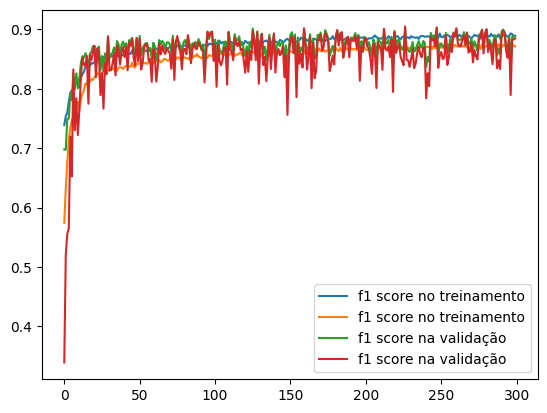

In [ ]:
plt.plot(history.history['f1_score'], label='f1 score no treinamento')
plt.plot(history.history['val_f1_score'], label='f1 score na validação')
plt.legend()

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step


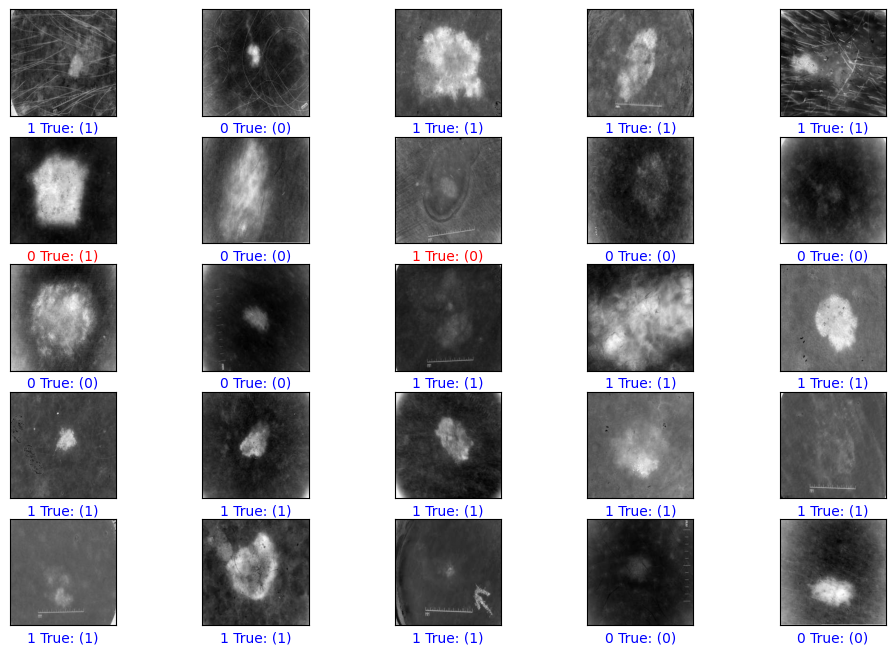

In [ ]:
predictions = model.predict(test_images)

plt.figure(figsize=(12,8))

for i in range(25):
  plt.subplot(5, 5, i+1)

  plt.xticks([])
  plt.yticks([])

  # plt.grid(False)

  plt.imshow(test_images[i], cmap=plt.cm.binary)

  predict_label = np.argmax(predictions[i])

  true_label = np.argmax(test_labels[i])

  if predict_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel(f'{predict_label} True: ({true_label})', color=color)

plt.show()
#

## Modelo com 128 features

Vamos treinar o modelo agora com 128 features

In [ ]:
model_128_features = models.Sequential()

model_128_features.add(layers.Conv2D(64,(3,3), activation='relu', input_shape=(224,224,1)))

model_128_features.add(layers.MaxPooling2D((2,2)))

model_128_features.add(layers.Conv2D(128, (3,3), activation='relu'))

model_128_features.add(layers.MaxPooling2D((2,2)))

model_128_features.add(layers.Flatten())

model_128_features.add(layers.Dense(128, activation='relu'))

model_128_features.add(layers.Dense(2, activation='softmax'))

model_128_features

/home/grizzo/desenvolvimento/model_cnn/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential_1, built=True>

In [ ]:
model_128_features.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
        'accuracy',
        metrics.F1Score(name='f1_score'),
        metrics.FalseNegatives(name='false_negatives'),
        metrics.FalsePositives(name='false_positives')
    ])

history_128_features = model_128_features.fit(train_generator, epochs=100, validation_data=test_generator)

Epoch 1/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 238s/step - accuracy: 0.6741 - f1_score: 0.6394 - false_negatives: 1951.2178 - false_positives: 1951.2178 - loss: 0.6035  

/home/grizzo/desenvolvimento/model_cnn/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


372/372 ━━━━━━━━━━━━━━━━━━━━ 88352s 238s/step - accuracy: 0.6741 - f1_score: 0.6394 - false_negatives: 1956.2627 - false_positives: 1956.2627 - loss: 0.6035 - val_accuracy: 0.6065 - val_f1_score: 0.5790 - val_false_negatives: 787.0000 - val_false_positives: 787.0000 - val_loss: 0.6205
Epoch 2/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.6995 - f1_score: 0.6927 - false_negatives: 1773.8901 - false_positives: 1773.8901 - loss: 0.5353 - val_accuracy: 0.6125 - val_f1_score: 0.5760 - val_false_negatives: 775.0000 - val_false_positives: 775.0000 - val_loss: 0.6506
Epoch 3/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.7255 - f1_score: 0.7203 - false_negatives: 1598.5469 - false_positives: 1598.5469 - loss: 0.5029 - val_accuracy: 0.7635 - val_f1_score: 0.7623 - val_false_negatives: 473.0000 - val_false_positives: 473.0000 - val_loss: 0.4500
Epoch 4/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.7532 - f1_score: 0.7495 - false_negatives: 1483.8070 - fal

In [ ]:
test_images, test_labels = extract_labels_from_generator(test_generator)

test_loss, test_acc, f1_score, false_negatives, false_positives = model_128_features.evaluate(test_images, test_labels)

print(f'Test accuracy: {test_acc}')
print(f'Test F1 score: {f1_score}')
print(f'Test False Negatives: {false_negatives}')
print(f'Test False Positives: {false_positives}')

Collected 2000 test images
Test images shape: (2000, 224, 224, 1)
Test labels shape: (2000, 2)
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.8524 - f1_score: 0.8519 - false_negatives: 160.3750 - false_positives: 160.3750 - loss: 0.3247
Test accuracy: 0.8489999771118164
Test F1 score: [0.8605724 0.8353326]
Test False Negatives: 302.0
Test False Positives: 302.0


## Variações testadas

Nessa sessão, o resultado e a explicação de cada variação testada.

### 20 Epochs - Imagens de 64x64 - 64 features

Utilizando o mesmo código, treinando com somente 20 epochs, houve um resultado de 78% de acurácia aproximadamente, e um f1 score de 80% para a classe 0 (benigno) e de 75% para classe 1 (malígno)

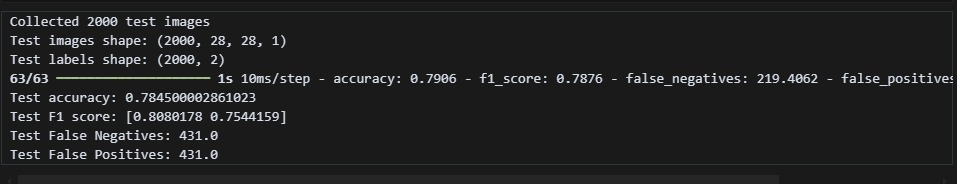

In [ ]:
from IPython.display import Image, display

# Display the image
display(Image('20-epochs.jpeg'))

### 50 epochs - Imagens de 64x64 - 64 features

Utilizando o mesmo código, com 50 epochs, houve uma melhora considerável, principalmente na predição do caso da classe 1. Tivemos um aumento para 86% de acurácia, 86% de f1 score para a classe 0 e 85% para classe 1.

Foi visto que 20 epochs é um valor muito baixo para esse dataset. Onde houve uma melhora muito grande na acertividade do modelo e em sua confiabilidade.

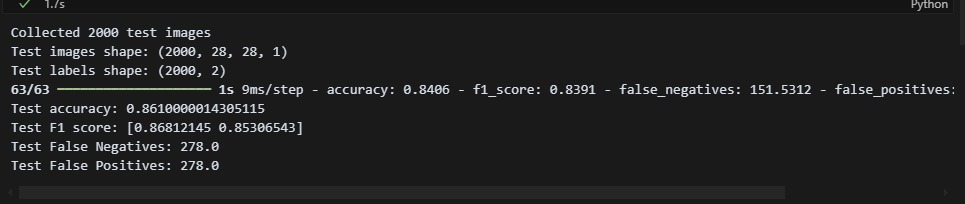

In [ ]:
# Display the image
display(Image('50-epochs.jpeg'))

### 100 epochs - Imagens de 224x224 - 64 features

Agora, aumentamos as epochs e o tamanho da imagem. Foi visto que ela estava bastante desfocada, provavelmente atrapalhando o desempenho do modelo

Com o aumento de detalhes da imagem, aumentei também o número de epochs para a melhorar o aprendizado do modelo.

Houve um pequeno aumento na acurácia, para 86,5%, e no f1 score aumento para 87% para a classe 0 e 85% para a classe 1.

Podemos dizer que o desempenho da variação com 100 epochs e 50, deram um resultado bem similar


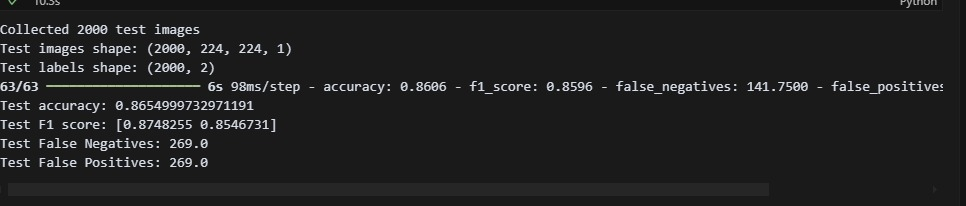

In [ ]:
# Display the image
display(Image('100-epochs.jpeg'))

### 300 epochs - Imagens de 224x224 - 64 features

Aumentamos o número de épocas, para 300. Aqui observamos uma melhora significativa, chegando em patamares próximos a 89% em todas as métricas.

Vemos também uma redução considerável nos falsos negativos e positivos.

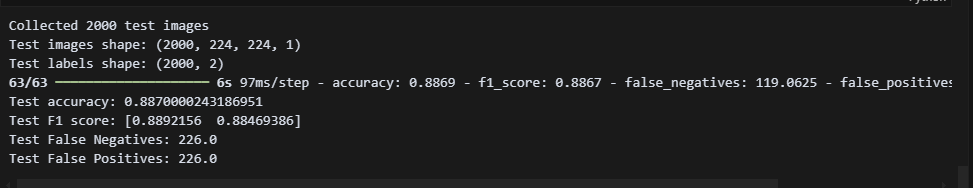

In [ ]:
# Display the image
display(Image('300-epochs-sem-dropout.png'))

Foi validado com dropout de 0.5 também, porém as métricas pioraram.

### 100 epochs - 128 features

Aumentamos a camada de extração de features, para 128. Foi diminuido a quantidade de epochs para 100, devido ao tempo de treinamento.

No fim, tivemos um resultado inferior ao de 300 epochs com 64 features. Perdemos a acurácia e f1 score em 3%. Tendo um quantidade de falsos negativos e positivos maior

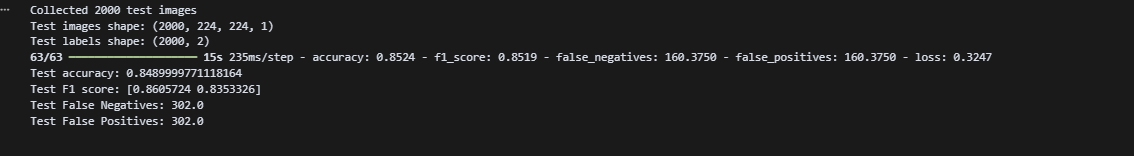

In [ ]:
# Display the image
display(Image('100-epochs-128.png'))

# Utilizando o modelo DenseNet121

Vamos utilizar esse modelo, devido a estudos que analisaram o seu desempenho para detecção de problemas de pele. Como estamos criando um modelo para a detecção de melanoma, esse modelo pré treinado pode funcionar bem.

Fonte: https://medinftech.org/index.php/medinftech/article/view/99#:~:text=Experimental%20results%20demonstrated%20an%20overall%20classification%20accuracy%20of,decision%20support%20tools%20for%20early%20skin%20disease%20diagnosis.

Para o treinamento foi utilizado uma GPU 4070 SUPER para agilizar o treinamento. Foi testado com CPU e com a GPU do google colab, mas o desempenho não estava sendo suficiente para rodar o modelo em tempo hábil, devido as modificações.

Foi necessário o carregamento das imagens em RGB, devido ao requisito do modelo DenseNet121.

Utilizamos aqui duas funções utiltárias.

Para a primeira fase, fizemos um treinamento mais sucinto, adicionando mais algumas camadas ao modelo do DenseNet para ele aprender o contexto de detecção de melanoma. Utilizamos 50 epochs para o treino.

Na segunda fase, foi utilizado as ultimas camadas congeladas no inicio do treinamento da fase um, para um fine tunning. Utilizamos 100 epochs para o treino

Foi utilizado o método de salvar o modelo para não termos o risco de perder o resultado. Enfrentei algumas instabilidades na IDE e isso salvou bastante tempo.



In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE=32
LEARNING_RATE = 0.001

# Data generators with resizing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Carregar dados
train_generator_rgb = train_datagen.flow_from_directory(
    './train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'  # Mudando para RGB para usar o modelo pré-treinado
)

test_generator_rgb = test_datagen.flow_from_directory(
    './test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
def create_model_phase1():
    """Cria o modelo para a primeira fase do fine-tuning"""
    
    try:
        # Carregar modelo base pré-treinado
        base_model = DenseNet121(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        )
        
        # Congelar todas as camadas do modelo base
        base_model.trainable = False
        
        # Criar modelo completo
        model = tf.keras.Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        print("✓ Model created successfully")
        print(f"✓ Model parameters: {model.count_params():,}")
        
        return model
        
    except Exception as e:
        print(f"✗ Error creating model: {e}")
        import traceback
        traceback.print_exc()
        return None

In [6]:
def create_model_phase2(phase1_model_path):
    """
    Carrega o modelo da fase 1 e descongela camadas para fine-tuning
    """
    try:
        print(f"Carregando modelo da fase 1: {phase1_model_path}")
        
        # Carregar o modelo completo da fase 1
        model = load_model(
            phase1_model_path,
            custom_objects={
                'f1_score': tf.keras.metrics.F1Score(name='f1_score')
            }
        )
        
        print("✓ Modelo carregado com sucesso")
        print(f"✓ Arquitetura: {len(model.layers)} camadas")
        
        # Encontrar a camada DenseNet121 (primeira camada)
        base_model = model.layers[0]  # DenseNet121 é a primeira camada no Sequential
        
        # Descongelar as últimas camadas do DenseNet
        # Descongelar apenas as últimas 20 camadas para fine-tuning controlado
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        
        for layer in base_model.layers[-20:]:
            layer.trainable = True
        
        print(f"✓ Descongeladas {sum(1 for layer in base_model.layers if layer.trainable)} camadas")
        
        return model
        
    except Exception as e:
        print(f"✗ Erro ao criar modelo phase 2: {e}")
        import traceback
        traceback.print_exc()
        return None

In [54]:
model_phase1 = create_model_phase1()

model_phase1.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score')]
)

# Callbacks para fase 1
callbacks_phase1 = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        'best_model_phase1.keras',
        monitor='val_f1_score',
        save_best_only=True,
        mode='max'
    )
]

# Treinar fase 1
print("=== FASE 1: Treinando apenas camadas de classificação ===")
history_phase1 = model_phase1.fit(
    train_generator_rgb,
    epochs=50,
    validation_data=test_generator_rgb,
    callbacks=callbacks_phase1,
    verbose=1
)

✓ Model created successfully
✓ Model parameters: 7,697,218
=== FASE 1: Treinando apenas camadas de classificação ===
Epoch 1/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7849 - f1_score: 0.7837 - loss: 0.5359

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8806818  0.86652535]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 102s 223ms/step - accuracy: 0.8132 - f1_score: 0.8123 - loss: 0.4509 - val_accuracy: 0.8740 - val_f1_score: 0.8736 - val_loss: 0.3065 - learning_rate: 0.0010
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8483 - f1_score: 0.8476 - loss: 0.3518

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8916135 0.8873024]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 65s 174ms/step - accuracy: 0.8504 - f1_score: 0.8497 - loss: 0.3412 - val_accuracy: 0.8895 - val_f1_score: 0.8895 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8626 - f1_score: 0.8621 - loss: 0.3188

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.872994  0.8477185]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.8625 - f1_score: 0.8619 - loss: 0.3220 - val_accuracy: 0.8615 - val_f1_score: 0.8604 - val_loss: 0.3226 - learning_rate: 0.0010
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8644 - f1_score: 0.8637 - loss: 0.3124

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89473677 0.8848167 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.8649 - f1_score: 0.8642 - loss: 0.3105 - val_accuracy: 0.8900 - val_f1_score: 0.8898 - val_loss: 0.2755 - learning_rate: 0.0010
Epoch 5/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8688 - f1_score: 0.8682 - loss: 0.3058

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88095236 0.88878137]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 65s 174ms/step - accuracy: 0.8693 - f1_score: 0.8688 - loss: 0.3039 - val_accuracy: 0.8850 - val_f1_score: 0.8849 - val_loss: 0.2849 - learning_rate: 0.0010
Epoch 6/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8720 - f1_score: 0.8715 - loss: 0.3018

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88745016 0.88654613]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.8699 - f1_score: 0.8693 - loss: 0.3016 - val_accuracy: 0.8870 - val_f1_score: 0.8870 - val_loss: 0.2711 - learning_rate: 0.0010
Epoch 7/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8739 - f1_score: 0.8735 - loss: 0.2930

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87791234 0.8586839 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8752 - f1_score: 0.8747 - loss: 0.2946 - val_accuracy: 0.8690 - val_f1_score: 0.8683 - val_loss: 0.3087 - learning_rate: 0.0010
Epoch 8/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8698 - f1_score: 0.8691 - loss: 0.3006

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.88822937 0.88574314]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 60s 162ms/step - accuracy: 0.8727 - f1_score: 0.8721 - loss: 0.3006 - val_accuracy: 0.8870 - val_f1_score: 0.8870 - val_loss: 0.2646 - learning_rate: 0.0010
Epoch 9/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8760 - f1_score: 0.8757 - loss: 0.2914

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8991097  0.89686555]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8742 - f1_score: 0.8737 - loss: 0.2915 - val_accuracy: 0.8980 - val_f1_score: 0.8980 - val_loss: 0.2723 - learning_rate: 0.0010
Epoch 10/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8774 - f1_score: 0.8767 - loss: 0.2874

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.87205076 0.8429844 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8761 - f1_score: 0.8755 - loss: 0.2895 - val_accuracy: 0.8590 - val_f1_score: 0.8575 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 11/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8742 - f1_score: 0.8737 - loss: 0.2916

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9052016 0.8996397]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.8736 - f1_score: 0.8731 - loss: 0.2909 - val_accuracy: 0.9025 - val_f1_score: 0.9024 - val_loss: 0.2504 - learning_rate: 0.0010
Epoch 12/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8768 - f1_score: 0.8762 - loss: 0.2888

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9048543  0.89896905]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.8784 - f1_score: 0.8779 - loss: 0.2849 - val_accuracy: 0.9020 - val_f1_score: 0.9019 - val_loss: 0.2512 - learning_rate: 0.0010
Epoch 13/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8841 - f1_score: 0.8834 - loss: 0.2816

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.903846   0.89583325]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8809 - f1_score: 0.8803 - loss: 0.2843 - val_accuracy: 0.9000 - val_f1_score: 0.8998 - val_loss: 0.2479 - learning_rate: 0.0010
Epoch 14/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8771 - f1_score: 0.8761 - loss: 0.2845

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8988123 0.8875989]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.8774 - f1_score: 0.8768 - loss: 0.2855 - val_accuracy: 0.8935 - val_f1_score: 0.8932 - val_loss: 0.2553 - learning_rate: 0.0010
Epoch 15/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8770 - f1_score: 0.8766 - loss: 0.2912

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.89931566 0.89457524]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.8790 - f1_score: 0.8785 - loss: 0.2856 - val_accuracy: 0.8970 - val_f1_score: 0.8969 - val_loss: 0.2528 - learning_rate: 0.0010
Epoch 16/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8845 - f1_score: 0.8841 - loss: 0.2821

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.8929428  0.88367236]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8833 - f1_score: 0.8828 - loss: 0.2790 - val_accuracy: 0.8885 - val_f1_score: 0.8883 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 17/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8802 - f1_score: 0.8797 - loss: 0.2789

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9090909 0.9079013]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.8840 - f1_score: 0.8835 - loss: 0.2756 - val_accuracy: 0.9085 - val_f1_score: 0.9085 - val_loss: 0.2385 - learning_rate: 0.0010
Epoch 18/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8836 - f1_score: 0.8832 - loss: 0.2824

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.90704495 0.90286297]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8871 - f1_score: 0.8866 - loss: 0.2746 - val_accuracy: 0.9050 - val_f1_score: 0.9050 - val_loss: 0.2388 - learning_rate: 0.0010
Epoch 19/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8873 - f1_score: 0.8868 - loss: 0.2726

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.90335107 0.8974755 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.8829 - f1_score: 0.8823 - loss: 0.2755 - val_accuracy: 0.9005 - val_f1_score: 0.9004 - val_loss: 0.2597 - learning_rate: 0.0010
Epoch 20/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8817 - f1_score: 0.8811 - loss: 0.2727

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.90594804 0.9090014 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.8858 - f1_score: 0.8853 - loss: 0.2715 - val_accuracy: 0.9075 - val_f1_score: 0.9075 - val_loss: 0.2503 - learning_rate: 0.0010
Epoch 21/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8823 - f1_score: 0.8818 - loss: 0.2765

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9027576  0.89601654]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8845 - f1_score: 0.8839 - loss: 0.2725 - val_accuracy: 0.8995 - val_f1_score: 0.8994 - val_loss: 0.2502 - learning_rate: 0.0010
Epoch 22/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8877 - f1_score: 0.8873 - loss: 0.2638

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.90300673 0.89680076]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 168ms/step - accuracy: 0.8881 - f1_score: 0.8877 - loss: 0.2678 - val_accuracy: 0.9000 - val_f1_score: 0.8999 - val_loss: 0.2429 - learning_rate: 0.0010
Epoch 23/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8831 - f1_score: 0.8828 - loss: 0.2644

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9084645 0.9054877]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 60s 161ms/step - accuracy: 0.8873 - f1_score: 0.8868 - loss: 0.2568 - val_accuracy: 0.9070 - val_f1_score: 0.9070 - val_loss: 0.2449 - learning_rate: 5.0000e-04
Epoch 24/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8952 - f1_score: 0.8948 - loss: 0.2518

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91327775 0.9096477 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8919 - f1_score: 0.8914 - loss: 0.2597 - val_accuracy: 0.9115 - val_f1_score: 0.9115 - val_loss: 0.2355 - learning_rate: 5.0000e-04
Epoch 25/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8969 - f1_score: 0.8964 - loss: 0.2502

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.90151507 0.8898304 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 168ms/step - accuracy: 0.8943 - f1_score: 0.8938 - loss: 0.2514 - val_accuracy: 0.8960 - val_f1_score: 0.8957 - val_loss: 0.2500 - learning_rate: 5.0000e-04
Epoch 26/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8986 - f1_score: 0.8982 - loss: 0.2460

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91153073 0.9104627 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.8970 - f1_score: 0.8966 - loss: 0.2530 - val_accuracy: 0.9110 - val_f1_score: 0.9110 - val_loss: 0.2393 - learning_rate: 5.0000e-04
Epoch 27/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8991 - f1_score: 0.8987 - loss: 0.2480

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9043976  0.89517814]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.8985 - f1_score: 0.8981 - loss: 0.2475 - val_accuracy: 0.9000 - val_f1_score: 0.8998 - val_loss: 0.2417 - learning_rate: 5.0000e-04
Epoch 28/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8948 - f1_score: 0.8944 - loss: 0.2541

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9090909 0.8994207]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8948 - f1_score: 0.8943 - loss: 0.2521 - val_accuracy: 0.9045 - val_f1_score: 0.9043 - val_loss: 0.2363 - learning_rate: 5.0000e-04
Epoch 29/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8996 - f1_score: 0.8991 - loss: 0.2394

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.903195  0.8933263]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 64s 172ms/step - accuracy: 0.8959 - f1_score: 0.8954 - loss: 0.2429 - val_accuracy: 0.8985 - val_f1_score: 0.8983 - val_loss: 0.2486 - learning_rate: 5.0000e-04
Epoch 30/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9004 - f1_score: 0.8997 - loss: 0.2518

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9146459 0.9091847]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.9016 - f1_score: 0.9011 - loss: 0.2423 - val_accuracy: 0.9120 - val_f1_score: 0.9119 - val_loss: 0.2406 - learning_rate: 2.5000e-04
Epoch 31/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9009 - f1_score: 0.9005 - loss: 0.2446

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.915039  0.9108606]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.9016 - f1_score: 0.9012 - loss: 0.2429 - val_accuracy: 0.9130 - val_f1_score: 0.9129 - val_loss: 0.2322 - learning_rate: 2.5000e-04
Epoch 32/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9016 - f1_score: 0.9010 - loss: 0.2372

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9162609 0.9116135]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 64s 171ms/step - accuracy: 0.9007 - f1_score: 0.9002 - loss: 0.2393 - val_accuracy: 0.9140 - val_f1_score: 0.9139 - val_loss: 0.2274 - learning_rate: 2.5000e-04
Epoch 33/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9004 - f1_score: 0.8999 - loss: 0.2315

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91361636 0.90927726]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8981 - f1_score: 0.8977 - loss: 0.2407 - val_accuracy: 0.9115 - val_f1_score: 0.9114 - val_loss: 0.2325 - learning_rate: 2.5000e-04
Epoch 34/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8983 - f1_score: 0.8979 - loss: 0.2474

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9121621 0.9056016]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 59s 160ms/step - accuracy: 0.8991 - f1_score: 0.8987 - loss: 0.2420 - val_accuracy: 0.9090 - val_f1_score: 0.9089 - val_loss: 0.2422 - learning_rate: 2.5000e-04
Epoch 35/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8987 - f1_score: 0.8983 - loss: 0.2448

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.92023337 0.9156378 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.9006 - f1_score: 0.9002 - loss: 0.2389 - val_accuracy: 0.9180 - val_f1_score: 0.9179 - val_loss: 0.2228 - learning_rate: 2.5000e-04
Epoch 36/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9043 - f1_score: 0.9038 - loss: 0.2299

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9136759  0.90815276]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.9023 - f1_score: 0.9018 - loss: 0.2342 - val_accuracy: 0.9110 - val_f1_score: 0.9109 - val_loss: 0.2324 - learning_rate: 2.5000e-04
Epoch 37/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9020 - f1_score: 0.9015 - loss: 0.2360

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.912518  0.9062661]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 64s 171ms/step - accuracy: 0.9044 - f1_score: 0.9040 - loss: 0.2320 - val_accuracy: 0.9095 - val_f1_score: 0.9094 - val_loss: 0.2345 - learning_rate: 2.5000e-04
Epoch 38/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9021 - f1_score: 0.9017 - loss: 0.2393

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91083413 0.9028213 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 60s 161ms/step - accuracy: 0.9042 - f1_score: 0.9038 - loss: 0.2293 - val_accuracy: 0.9070 - val_f1_score: 0.9068 - val_loss: 0.2381 - learning_rate: 2.5000e-04
Epoch 39/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9037 - f1_score: 0.9031 - loss: 0.2313

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91569763 0.9101239 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.9021 - f1_score: 0.9016 - loss: 0.2331 - val_accuracy: 0.9130 - val_f1_score: 0.9129 - val_loss: 0.2291 - learning_rate: 2.5000e-04
Epoch 40/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9014 - f1_score: 0.9009 - loss: 0.2321

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9109588 0.9069529]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.9023 - f1_score: 0.9019 - loss: 0.2335 - val_accuracy: 0.9090 - val_f1_score: 0.9090 - val_loss: 0.2342 - learning_rate: 2.5000e-04
Epoch 41/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8996 - f1_score: 0.8990 - loss: 0.2344

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91487277 0.91104287]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 171ms/step - accuracy: 0.9023 - f1_score: 0.9019 - loss: 0.2286 - val_accuracy: 0.9130 - val_f1_score: 0.9130 - val_loss: 0.2297 - learning_rate: 1.2500e-04
Epoch 42/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9046 - f1_score: 0.9043 - loss: 0.2285

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9161849  0.90956336]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 60s 160ms/step - accuracy: 0.9073 - f1_score: 0.9069 - loss: 0.2229 - val_accuracy: 0.9130 - val_f1_score: 0.9129 - val_loss: 0.2348 - learning_rate: 1.2500e-04
Epoch 43/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9033 - f1_score: 0.9029 - loss: 0.2409

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91881377 0.91405046]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.9055 - f1_score: 0.9050 - loss: 0.2364 - val_accuracy: 0.9165 - val_f1_score: 0.9164 - val_loss: 0.2296 - learning_rate: 1.2500e-04
Epoch 44/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9089 - f1_score: 0.9085 - loss: 0.2226

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9165459  0.91022307]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 64s 171ms/step - accuracy: 0.9076 - f1_score: 0.9072 - loss: 0.2254 - val_accuracy: 0.9135 - val_f1_score: 0.9134 - val_loss: 0.2313 - learning_rate: 1.2500e-04
Epoch 45/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9006 - f1_score: 0.8998 - loss: 0.2369

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91952884 0.91641176]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.9032 - f1_score: 0.9027 - loss: 0.2305 - val_accuracy: 0.9180 - val_f1_score: 0.9180 - val_loss: 0.2251 - learning_rate: 1.2500e-04
Epoch 46/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9046 - f1_score: 0.9042 - loss: 0.2303

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9177615 0.9131105]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.9055 - f1_score: 0.9052 - loss: 0.2277 - val_accuracy: 0.9155 - val_f1_score: 0.9154 - val_loss: 0.2293 - learning_rate: 6.2500e-05
Epoch 47/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9061 - f1_score: 0.9057 - loss: 0.2311

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91517204 0.9096541 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.9082 - f1_score: 0.9078 - loss: 0.2284 - val_accuracy: 0.9125 - val_f1_score: 0.9124 - val_loss: 0.2301 - learning_rate: 6.2500e-05
Epoch 48/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9114 - f1_score: 0.9109 - loss: 0.2148

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91513973 0.90861887]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.9069 - f1_score: 0.9065 - loss: 0.2258 - val_accuracy: 0.9120 - val_f1_score: 0.9119 - val_loss: 0.2331 - learning_rate: 6.2500e-05
Epoch 49/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9116 - f1_score: 0.9110 - loss: 0.2142

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9173954 0.9124613]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.9104 - f1_score: 0.9100 - loss: 0.2165 - val_accuracy: 0.9150 - val_f1_score: 0.9149 - val_loss: 0.2281 - learning_rate: 6.2500e-05
Epoch 50/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9074 - f1_score: 0.9070 - loss: 0.2221

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91844654 0.91340196]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 170ms/step - accuracy: 0.9086 - f1_score: 0.9082 - loss: 0.2203 - val_accuracy: 0.9160 - val_f1_score: 0.9159 - val_loss: 0.2291 - learning_rate: 6.2500e-05


In [ ]:
model_phase2 = create_model_phase2('best_model_phase1.keras')

# Compilar com learning rate menor para fine-tuning
model_phase2.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE * 0.1),  # Learning rate menor
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score')]
)

# Callbacks para fase 2
callbacks_phase2 = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=8,
        min_lr=1e-8
    ),
    ModelCheckpoint(
        'best_model_final.keras',
        monitor='val_f1_score',
        save_best_only=True,
        mode='max'
    )
]

# Treinar fase 2
print("=== FASE 2: Fine-tuning das camadas do modelo base ===")
history_phase2 = model_phase2.fit(
    train_generator_rgb,
    epochs=100,
    validation_data=test_generator_rgb,
    callbacks=callbacks_phase2,
    verbose=1
)

Carregando modelo da fase 1: best_model_phase1.keras


I0000 00:00:1754747736.886682   62477 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9515 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


✓ Modelo carregado com sucesso
✓ Arquitetura: 9 camadas
✓ Descongeladas 20 camadas
=== FASE 2: Fine-tuning das camadas do modelo base ===


/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1754747747.973853   62696 service.cc:152] XLA service 0x7c3f20004710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754747747.973922   62696 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-08-09 10:55:48.227607: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754747750.546553   62696 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-09 10:55:51.746434: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13283_0', 412 bytes spill stores, 1028 bytes spill loads

2025-08-09 10:55:51.911689: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusi

356/372 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.8841 - f1_score: 0.8835 - loss: 0.2786

2025-08-09 10:57:08.378456: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13283_0', 184 bytes spill stores, 404 bytes spill loads

2025-08-09 10:57:08.464339: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13283', 104 bytes spill stores, 104 bytes spill loads

2025-08-09 10:57:08.646190: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13283', 12 bytes spill stores, 12 bytes spill loads

2025-08-09 10:57:08.775233: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13283', 3972 bytes spill stores, 3956 bytes spill loads

2025-08-09 10:57:08.951088

357/372 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.8842 - f1_score: 0.8835 - loss: 0.2786

2025-08-09 10:57:21.945164: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 8 bytes spill stores, 8 bytes spill loads



372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8845 - f1_score: 0.8838 - loss: 0.2781

2025-08-09 10:57:33.593961: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3356', 4 bytes spill stores, 4 bytes spill loads

2025-08-09 10:57:33.638580: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3356_0', 200 bytes spill stores, 416 bytes spill loads

2025-08-09 10:57:33.770501: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3356', 60 bytes spill stores, 128 bytes spill loads

2025-08-09 10:57:33.971676: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3356', 3908 bytes spill stores, 3896 bytes spill loads

2025-08-09 10:57:34.048452: I ext

372/372 ━━━━━━━━━━━━━━━━━━━━ 121s 254ms/step - accuracy: 0.8922 - f1_score: 0.8917 - loss: 0.2647 - val_accuracy: 0.9040 - val_f1_score: 0.9040 - val_loss: 0.2339 - learning_rate: 1.0000e-04
Epoch 2/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8951 - f1_score: 0.8948 - loss: 0.2477

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91074854 0.90292275]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 169ms/step - accuracy: 0.8943 - f1_score: 0.8938 - loss: 0.2482 - val_accuracy: 0.9070 - val_f1_score: 0.9068 - val_loss: 0.2328 - learning_rate: 1.0000e-04
Epoch 3/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8981 - f1_score: 0.8974 - loss: 0.2378

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9089147  0.90289253]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 168ms/step - accuracy: 0.8960 - f1_score: 0.8955 - loss: 0.2427 - val_accuracy: 0.9060 - val_f1_score: 0.9059 - val_loss: 0.2405 - learning_rate: 1.0000e-04
Epoch 4/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9042 - f1_score: 0.9037 - loss: 0.2332

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9186274  0.91530603]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 168ms/step - accuracy: 0.9022 - f1_score: 0.9018 - loss: 0.2378 - val_accuracy: 0.9170 - val_f1_score: 0.9170 - val_loss: 0.2186 - learning_rate: 1.0000e-04
Epoch 5/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9053 - f1_score: 0.9049 - loss: 0.2276

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.92307687 0.91774434]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9068 - f1_score: 0.9064 - loss: 0.2245 - val_accuracy: 0.9205 - val_f1_score: 0.9204 - val_loss: 0.2105 - learning_rate: 1.0000e-04
Epoch 6/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9068 - f1_score: 0.9065 - loss: 0.2237

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91875917 0.916201  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 60s 162ms/step - accuracy: 0.9061 - f1_score: 0.9057 - loss: 0.2248 - val_accuracy: 0.9175 - val_f1_score: 0.9175 - val_loss: 0.2118 - learning_rate: 1.0000e-04
Epoch 7/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9077 - f1_score: 0.9073 - loss: 0.2176

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9198812 0.9180991]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 168ms/step - accuracy: 0.9107 - f1_score: 0.9103 - loss: 0.2153 - val_accuracy: 0.9190 - val_f1_score: 0.9190 - val_loss: 0.2157 - learning_rate: 1.0000e-04
Epoch 8/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9158 - f1_score: 0.9154 - loss: 0.2102

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.91489357 0.9089027 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9145 - f1_score: 0.9141 - loss: 0.2121 - val_accuracy: 0.9120 - val_f1_score: 0.9119 - val_loss: 0.2149 - learning_rate: 1.0000e-04
Epoch 9/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9163 - f1_score: 0.9157 - loss: 0.2032

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9267092 0.92425  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9162 - f1_score: 0.9158 - loss: 0.2051 - val_accuracy: 0.9255 - val_f1_score: 0.9255 - val_loss: 0.1967 - learning_rate: 1.0000e-04
Epoch 10/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9197 - f1_score: 0.9194 - loss: 0.1995

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.92654824 0.92018783]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 167ms/step - accuracy: 0.9136 - f1_score: 0.9133 - loss: 0.2102 - val_accuracy: 0.9235 - val_f1_score: 0.9234 - val_loss: 0.2066 - learning_rate: 1.0000e-04
Epoch 11/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9204 - f1_score: 0.9201 - loss: 0.1959

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9299111 0.9280648]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9192 - f1_score: 0.9188 - loss: 0.2010 - val_accuracy: 0.9290 - val_f1_score: 0.9290 - val_loss: 0.1900 - learning_rate: 1.0000e-04
Epoch 12/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9190 - f1_score: 0.9187 - loss: 0.1998

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9245647  0.91925454]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9186 - f1_score: 0.9183 - loss: 0.1979 - val_accuracy: 0.9220 - val_f1_score: 0.9219 - val_loss: 0.1947 - learning_rate: 1.0000e-04
Epoch 13/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9253 - f1_score: 0.9249 - loss: 0.1849

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9200193 0.9148167]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9245 - f1_score: 0.9242 - loss: 0.1864 - val_accuracy: 0.9175 - val_f1_score: 0.9174 - val_loss: 0.1992 - learning_rate: 1.0000e-04
Epoch 14/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9235 - f1_score: 0.9231 - loss: 0.1877

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9219511 0.9179486]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9242 - f1_score: 0.9238 - loss: 0.1884 - val_accuracy: 0.9200 - val_f1_score: 0.9199 - val_loss: 0.1964 - learning_rate: 1.0000e-04
Epoch 15/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9273 - f1_score: 0.9268 - loss: 0.1861

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9297987 0.9271523]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9265 - f1_score: 0.9262 - loss: 0.1863 - val_accuracy: 0.9285 - val_f1_score: 0.9285 - val_loss: 0.1864 - learning_rate: 1.0000e-04
Epoch 16/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9350 - f1_score: 0.9347 - loss: 0.1666

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.93071246 0.92824423]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 167ms/step - accuracy: 0.9322 - f1_score: 0.9320 - loss: 0.1707 - val_accuracy: 0.9295 - val_f1_score: 0.9295 - val_loss: 0.1988 - learning_rate: 1.0000e-04
Epoch 17/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9281 - f1_score: 0.9279 - loss: 0.1719

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.93445045 0.93252146]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9288 - f1_score: 0.9285 - loss: 0.1727 - val_accuracy: 0.9335 - val_f1_score: 0.9335 - val_loss: 0.1822 - learning_rate: 1.0000e-04
Epoch 18/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9286 - f1_score: 0.9284 - loss: 0.1728

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.92635655 0.92148757]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9301 - f1_score: 0.9298 - loss: 0.1727 - val_accuracy: 0.9240 - val_f1_score: 0.9239 - val_loss: 0.2007 - learning_rate: 1.0000e-04
Epoch 19/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9308 - f1_score: 0.9305 - loss: 0.1649

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9317837 0.9332013]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9313 - f1_score: 0.9310 - loss: 0.1653 - val_accuracy: 0.9325 - val_f1_score: 0.9325 - val_loss: 0.1850 - learning_rate: 1.0000e-04
Epoch 20/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9386 - f1_score: 0.9383 - loss: 0.1602

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.93034816 0.92964816]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9355 - f1_score: 0.9352 - loss: 0.1634 - val_accuracy: 0.9300 - val_f1_score: 0.9300 - val_loss: 0.1854 - learning_rate: 1.0000e-04
Epoch 21/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9358 - f1_score: 0.9356 - loss: 0.1560

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9388971  0.93809754]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9345 - f1_score: 0.9343 - loss: 0.1585 - val_accuracy: 0.9385 - val_f1_score: 0.9385 - val_loss: 0.1767 - learning_rate: 1.0000e-04
Epoch 22/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9320 - f1_score: 0.9316 - loss: 0.1713

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.93157625 0.933399  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9351 - f1_score: 0.9348 - loss: 0.1623 - val_accuracy: 0.9325 - val_f1_score: 0.9325 - val_loss: 0.1837 - learning_rate: 1.0000e-04
Epoch 23/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9375 - f1_score: 0.9372 - loss: 0.1536

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9244018 0.9172774]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9385 - f1_score: 0.9382 - loss: 0.1505 - val_accuracy: 0.9210 - val_f1_score: 0.9208 - val_loss: 0.1996 - learning_rate: 1.0000e-04
Epoch 24/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9429 - f1_score: 0.9426 - loss: 0.1474

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9329359  0.93205833]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9421 - f1_score: 0.9418 - loss: 0.1483 - val_accuracy: 0.9325 - val_f1_score: 0.9325 - val_loss: 0.1786 - learning_rate: 1.0000e-04
Epoch 25/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9442 - f1_score: 0.9439 - loss: 0.1442

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9147442 0.9152541]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9425 - f1_score: 0.9423 - loss: 0.1449 - val_accuracy: 0.9150 - val_f1_score: 0.9150 - val_loss: 0.2038 - learning_rate: 1.0000e-04
Epoch 26/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9413 - f1_score: 0.9410 - loss: 0.1423

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9239598  0.91671026]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9396 - f1_score: 0.9393 - loss: 0.1475 - val_accuracy: 0.9205 - val_f1_score: 0.9203 - val_loss: 0.2062 - learning_rate: 1.0000e-04
Epoch 27/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9457 - f1_score: 0.9455 - loss: 0.1416

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9227799  0.91701245]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9444 - f1_score: 0.9441 - loss: 0.1435 - val_accuracy: 0.9200 - val_f1_score: 0.9199 - val_loss: 0.1981 - learning_rate: 1.0000e-04
Epoch 28/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9492 - f1_score: 0.9489 - loss: 0.1336

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.92644125 0.9255533 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9475 - f1_score: 0.9472 - loss: 0.1359 - val_accuracy: 0.9260 - val_f1_score: 0.9260 - val_loss: 0.1877 - learning_rate: 1.0000e-04
Epoch 29/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9451 - f1_score: 0.9449 - loss: 0.1293

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9344672  0.93453264]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9445 - f1_score: 0.9443 - loss: 0.1353 - val_accuracy: 0.9345 - val_f1_score: 0.9345 - val_loss: 0.1832 - learning_rate: 1.0000e-04
Epoch 30/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9472 - f1_score: 0.9469 - loss: 0.1337

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.93392503 0.93204856]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9502 - f1_score: 0.9501 - loss: 0.1267 - val_accuracy: 0.9330 - val_f1_score: 0.9330 - val_loss: 0.1763 - learning_rate: 2.0000e-05
Epoch 31/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9533 - f1_score: 0.9531 - loss: 0.1184

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9384076 0.938592 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9555 - f1_score: 0.9553 - loss: 0.1161 - val_accuracy: 0.9385 - val_f1_score: 0.9385 - val_loss: 0.1702 - learning_rate: 2.0000e-05
Epoch 32/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9543 - f1_score: 0.9539 - loss: 0.1143

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9379652  0.93702763]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9542 - f1_score: 0.9540 - loss: 0.1152 - val_accuracy: 0.9375 - val_f1_score: 0.9375 - val_loss: 0.1729 - learning_rate: 2.0000e-05
Epoch 33/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9599 - f1_score: 0.9598 - loss: 0.1059

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9372219  0.93576115]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9574 - f1_score: 0.9572 - loss: 0.1103 - val_accuracy: 0.9365 - val_f1_score: 0.9365 - val_loss: 0.1775 - learning_rate: 2.0000e-05
Epoch 34/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9584 - f1_score: 0.9583 - loss: 0.1075

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9410015  0.93998986]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9550 - f1_score: 0.9548 - loss: 0.1158 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1730 - learning_rate: 2.0000e-05
Epoch 35/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9487 - f1_score: 0.9484 - loss: 0.1258

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.93227875 0.93070304]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9540 - f1_score: 0.9538 - loss: 0.1171 - val_accuracy: 0.9315 - val_f1_score: 0.9315 - val_loss: 0.1825 - learning_rate: 2.0000e-05
Epoch 36/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9569 - f1_score: 0.9568 - loss: 0.1079

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9393637 0.9386318]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9577 - f1_score: 0.9575 - loss: 0.1076 - val_accuracy: 0.9390 - val_f1_score: 0.9390 - val_loss: 0.1706 - learning_rate: 2.0000e-05
Epoch 37/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9597 - f1_score: 0.9595 - loss: 0.1016

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9396508 0.9393483]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9581 - f1_score: 0.9579 - loss: 0.1043 - val_accuracy: 0.9395 - val_f1_score: 0.9395 - val_loss: 0.1758 - learning_rate: 2.0000e-05
Epoch 38/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9555 - f1_score: 0.9553 - loss: 0.1130

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9406527 0.9393326]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9549 - f1_score: 0.9547 - loss: 0.1150 - val_accuracy: 0.9400 - val_f1_score: 0.9400 - val_loss: 0.1734 - learning_rate: 2.0000e-05
Epoch 39/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9594 - f1_score: 0.9592 - loss: 0.1038

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.94188374 0.9421157 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9577 - f1_score: 0.9575 - loss: 0.1085 - val_accuracy: 0.9420 - val_f1_score: 0.9420 - val_loss: 0.1703 - learning_rate: 2.0000e-05
Epoch 40/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9634 - f1_score: 0.9633 - loss: 0.0962

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9411177 0.9408817]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9614 - f1_score: 0.9613 - loss: 0.0997 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1724 - learning_rate: 4.0000e-06
Epoch 41/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9615 - f1_score: 0.9613 - loss: 0.1061

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9414706  0.94152915]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9608 - f1_score: 0.9606 - loss: 0.1044 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1713 - learning_rate: 4.0000e-06
Epoch 42/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9650 - f1_score: 0.9649 - loss: 0.0908

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.94335836 0.94364077]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9628 - f1_score: 0.9626 - loss: 0.0975 - val_accuracy: 0.9435 - val_f1_score: 0.9435 - val_loss: 0.1707 - learning_rate: 4.0000e-06
Epoch 43/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9591 - f1_score: 0.9589 - loss: 0.1031

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9435282  0.94347167]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9600 - f1_score: 0.9598 - loss: 0.1020 - val_accuracy: 0.9435 - val_f1_score: 0.9435 - val_loss: 0.1715 - learning_rate: 4.0000e-06
Epoch 44/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9553 - f1_score: 0.9551 - loss: 0.1116

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9425287  0.94247115]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9578 - f1_score: 0.9577 - loss: 0.1055 - val_accuracy: 0.9425 - val_f1_score: 0.9425 - val_loss: 0.1708 - learning_rate: 4.0000e-06
Epoch 45/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9614 - f1_score: 0.9613 - loss: 0.1018

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9424136  0.94258606]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9607 - f1_score: 0.9605 - loss: 0.1013 - val_accuracy: 0.9425 - val_f1_score: 0.9425 - val_loss: 0.1740 - learning_rate: 4.0000e-06
Epoch 46/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9582 - f1_score: 0.9580 - loss: 0.1027

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.94205785 0.94194186]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9619 - f1_score: 0.9618 - loss: 0.0988 - val_accuracy: 0.9420 - val_f1_score: 0.9420 - val_loss: 0.1726 - learning_rate: 4.0000e-06
Epoch 47/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9593 - f1_score: 0.9592 - loss: 0.1064 - val_accuracy: 0.9420 - val_f1_score: 0.9420 - val_loss: 0.1718 - learning_rate: 4.0000e-06
Epoch 48/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9595 - f1_score: 0.9594 - loss: 0.1024

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.94094086 0.9410589 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9602 - f1_score: 0.9600 - loss: 0.1017 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1712 - learning_rate: 8.0000e-07
Epoch 49/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9602 - f1_score: 0.9600 - loss: 0.0996

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.94047016 0.9405297 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9603 - f1_score: 0.9601 - loss: 0.0988 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1722 - learning_rate: 8.0000e-07
Epoch 50/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9634 - f1_score: 0.9632 - loss: 0.0947

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9412355  0.94176203]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9597 - f1_score: 0.9595 - loss: 0.1021 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1724 - learning_rate: 8.0000e-07
Epoch 51/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9607 - f1_score: 0.9605 - loss: 0.1029 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1730 - learning_rate: 8.0000e-07
Epoch 52/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 167ms/step - accuracy: 0.9614 - f1_score: 0.9612 - loss: 0.1035 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1722 - learning_rate: 8.0000e-07
Epoch 53/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9648 - f1_score: 0.9648 - loss: 0.0907

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.94129455 0.941704  ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9614 - f1_score: 0.9613 - loss: 0.0971 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1728 - learning_rate: 8.0000e-07
Epoch 54/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9599 - f1_score: 0.9598 - loss: 0.1027 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1727 - learning_rate: 8.0000e-07
Epoch 55/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9617 - f1_score: 0.9614 - loss: 0.1002

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.941704   0.94129455]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9612 - f1_score: 0.9610 - loss: 0.0978 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1732 - learning_rate: 8.0000e-07
Epoch 56/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9609 - f1_score: 0.9607 - loss: 0.1007

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.93993986 0.94005996]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9619 - f1_score: 0.9617 - loss: 0.0989 - val_accuracy: 0.9400 - val_f1_score: 0.9400 - val_loss: 0.1728 - learning_rate: 1.6000e-07
Epoch 57/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 167ms/step - accuracy: 0.9618 - f1_score: 0.9616 - loss: 0.0992 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1732 - learning_rate: 1.6000e-07
Epoch 58/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9623 - f1_score: 0.9621 - loss: 0.1003 - val_accuracy: 0.9420 - val_f1_score: 0.9420 - val_loss: 0.1733 - learning_rate: 1.6000e-07
Epoch 59/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9559 - f1_score: 0.9556 - loss: 0.1050

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.93999994 0.93999994]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9583 - f1_score: 0.9582 - loss: 0.1014 - val_accuracy: 0.9400 - val_f1_score: 0.9400 - val_loss: 0.1732 - learning_rate: 1.6000e-07
Epoch 60/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9585 - f1_score: 0.9583 - loss: 0.1044

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.93981946 0.9401794 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9593 - f1_score: 0.9592 - loss: 0.1034 - val_accuracy: 0.9400 - val_f1_score: 0.9400 - val_loss: 0.1734 - learning_rate: 1.6000e-07
Epoch 61/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - accuracy: 0.9615 - f1_score: 0.9614 - loss: 0.1011 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1728 - learning_rate: 1.6000e-07
Epoch 62/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9620 - f1_score: 0.9619 - loss: 0.0966 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1730 - learning_rate: 1.6000e-07
Epoch 63/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9624 - f1_score: 0.9622 - loss: 0.0979

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9423558 0.9426433]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9632 - f1_score: 0.9631 - loss: 0.0986 - val_accuracy: 0.9425 - val_f1_score: 0.9425 - val_loss: 0.1725 - learning_rate: 1.6000e-07
Epoch 64/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9598 - f1_score: 0.9596 - loss: 0.1028 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1731 - learning_rate: 3.2000e-08
Epoch 65/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9621 - f1_score: 0.9619 - loss: 0.0984

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.941 0.941]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9616 - f1_score: 0.9615 - loss: 0.1007 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1728 - learning_rate: 3.2000e-08
Epoch 66/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9619 - f1_score: 0.9617 - loss: 0.0984 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1730 - learning_rate: 3.2000e-08
Epoch 67/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9605 - f1_score: 0.9604 - loss: 0.1023 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1720 - learning_rate: 3.2000e-08
Epoch 68/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - accuracy: 0.9613 - f1_score: 0.9611 - loss: 0.1009 - val_accuracy: 0.9420 - val_f1_score: 0.9420 - val_loss: 0.1728 - learning_rate: 3.2000e-08
Epoch 69/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9591 - f1_score: 0.9589 - loss: 0.1074

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9405297  0.94047016]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9604 - f1_score: 0.9603 - loss: 0.1036 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1731 - learning_rate: 3.2000e-08
Epoch 70/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9610 - f1_score: 0.9609 - loss: 0.0995

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.94152915 0.9414706 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9614 - f1_score: 0.9612 - loss: 0.1004 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1723 - learning_rate: 3.2000e-08
Epoch 71/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9634 - f1_score: 0.9632 - loss: 0.0984

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9408817 0.9411177]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9609 - f1_score: 0.9608 - loss: 0.1003 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1730 - learning_rate: 3.2000e-08
Epoch 72/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9629 - f1_score: 0.9627 - loss: 0.0971 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1729 - learning_rate: 1.0000e-08
Epoch 73/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9619 - f1_score: 0.9618 - loss: 0.0974 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1729 - learning_rate: 1.0000e-08
Epoch 74/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9614 - f1_score: 0.9612 - loss: 0.0982 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1724 - learning_rate: 1.0000e-08
Epoch 75/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9615 - f1_score: 0.9614 - loss: 0.0992 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1734 - learning_rate: 1.0000e-0

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.94258606 0.9424136 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9608 - f1_score: 0.9606 - loss: 0.0980 - val_accuracy: 0.9425 - val_f1_score: 0.9425 - val_loss: 0.1727 - learning_rate: 1.0000e-08
Epoch 77/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9604 - f1_score: 0.9603 - loss: 0.1007 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1721 - learning_rate: 1.0000e-08
Epoch 78/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9622 - f1_score: 0.9621 - loss: 0.0977 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1734 - learning_rate: 1.0000e-08
Epoch 79/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9576 - f1_score: 0.9575 - loss: 0.1032

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9393483 0.9396508]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 63s 168ms/step - accuracy: 0.9593 - f1_score: 0.9592 - loss: 0.1026 - val_accuracy: 0.9395 - val_f1_score: 0.9395 - val_loss: 0.1739 - learning_rate: 1.0000e-08
Epoch 80/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9630 - f1_score: 0.9628 - loss: 0.0969 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1728 - learning_rate: 1.0000e-08
Epoch 81/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - accuracy: 0.9609 - f1_score: 0.9608 - loss: 0.0990 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1732 - learning_rate: 1.0000e-08
Epoch 82/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - accuracy: 0.9617 - f1_score: 0.9615 - loss: 0.0988 - val_accuracy: 0.9415 - val_f1_score: 0.9415 - val_loss: 0.1724 - learning_rate: 1.0000e-08
Epoch 83/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - accuracy: 0.9586 - f1_score: 0.9584 - loss: 0.1046 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1729 - learning_rate: 1.0000e-0

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9410589  0.94094086]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9591 - f1_score: 0.9589 - loss: 0.1050 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1734 - learning_rate: 1.0000e-08
Epoch 85/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9621 - f1_score: 0.9620 - loss: 0.0976

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.94035083 0.9406483 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 165ms/step - accuracy: 0.9619 - f1_score: 0.9617 - loss: 0.0957 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1722 - learning_rate: 1.0000e-08
Epoch 86/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9616 - f1_score: 0.9615 - loss: 0.0971 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1726 - learning_rate: 1.0000e-08
Epoch 87/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9612 - f1_score: 0.9610 - loss: 0.0976 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1731 - learning_rate: 1.0000e-08
Epoch 88/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9601 - f1_score: 0.9599 - loss: 0.0974

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9426433 0.9423558]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9581 - f1_score: 0.9579 - loss: 0.1018 - val_accuracy: 0.9425 - val_f1_score: 0.9425 - val_loss: 0.1726 - learning_rate: 1.0000e-08
Epoch 89/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9593 - f1_score: 0.9592 - loss: 0.1052 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1729 - learning_rate: 1.0000e-08
Epoch 90/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9575 - f1_score: 0.9573 - loss: 0.1101

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9404105 0.940589 ]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9579 - f1_score: 0.9577 - loss: 0.1043 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1725 - learning_rate: 1.0000e-08
Epoch 91/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9626 - f1_score: 0.9625 - loss: 0.0992 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1726 - learning_rate: 1.0000e-08
Epoch 92/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9606 - f1_score: 0.9604 - loss: 0.1083

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9394091 0.9395905]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9615 - f1_score: 0.9614 - loss: 0.1044 - val_accuracy: 0.9395 - val_f1_score: 0.9395 - val_loss: 0.1728 - learning_rate: 1.0000e-08
Epoch 93/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 163ms/step - accuracy: 0.9614 - f1_score: 0.9612 - loss: 0.0996 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1733 - learning_rate: 1.0000e-08
Epoch 94/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9611 - f1_score: 0.9610 - loss: 0.1012 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1729 - learning_rate: 1.0000e-08
Epoch 95/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9654 - f1_score: 0.9653 - loss: 0.0957 - val_accuracy: 0.9405 - val_f1_score: 0.9405 - val_loss: 0.1738 - learning_rate: 1.0000e-08
Epoch 96/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9627 - f1_score: 0.9626 - loss: 0.0982 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1730 - learning_rate: 1.0000e-0

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.94058406 0.94141006]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9623 - f1_score: 0.9621 - loss: 0.1000 - val_accuracy: 0.9410 - val_f1_score: 0.9410 - val_loss: 0.1736 - learning_rate: 1.0000e-08
Epoch 99/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9622 - f1_score: 0.9620 - loss: 0.0947

/home/grizzo/desenvolvimento/melanome-cancer-detection/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:233: UserWarning: Can save best model only when `monitor` is a scalar value. Received: [0.9398797  0.94011974]. Falling back to `save_best_only=False`.
  warnings.warn(


372/372 ━━━━━━━━━━━━━━━━━━━━ 61s 164ms/step - accuracy: 0.9587 - f1_score: 0.9585 - loss: 0.1026 - val_accuracy: 0.9400 - val_f1_score: 0.9400 - val_loss: 0.1723 - learning_rate: 1.0000e-08
Epoch 100/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 62s 166ms/step - accuracy: 0.9583 - f1_score: 0.9582 - loss: 0.1074 - val_accuracy: 0.9420 - val_f1_score: 0.9420 - val_loss: 0.1731 - learning_rate: 1.0000e-08


In [8]:
def evaluate_model(model, test_generator):
    """Avalia o modelo final"""
    
    # Extrair dados de teste
    test_images, test_labels = extract_labels_from_generator(test_generator)
    
    # Avaliar modelo
    test_loss, test_acc, f1_score = model.evaluate(test_images, test_labels, verbose=0)
    
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test F1 Score: {f1_score}')
    print(f'Test Loss: {test_loss:.4f}')
    
    return test_loss, test_acc, f1_score

def plot_training_history(history_phase1, history_phase2):
    """Plota o histórico de treinamento das duas fases"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Fase 1
    axes[0, 0].plot(history_phase1.history['accuracy'], label='Train')
    axes[0, 0].plot(history_phase1.history['val_accuracy'], label='Validation')
    axes[0, 0].set_title('Fase 1 - Accuracy')
    axes[0, 0].legend()
    
    axes[0, 1].plot(history_phase1.history['f1_score'], label='Train')
    axes[0, 1].plot(history_phase1.history['val_f1_score'], label='Validation')
    axes[0, 1].set_title('Fase 1 - F1 Score')
    axes[0, 1].legend()
    
    # Fase 2
    axes[1, 0].plot(history_phase2.history['accuracy'], label='Train')
    axes[1, 0].plot(history_phase2.history['val_accuracy'], label='Validation')
    axes[1, 0].set_title('Fase 2 - Accuracy')
    axes[1, 0].legend()
    
    axes[1, 1].plot(history_phase2.history['f1_score'], label='Train')
    axes[1, 1].plot(history_phase2.history['val_f1_score'], label='Validation')
    axes[1, 1].set_title('Fase 2 - F1 Score')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Avaliar modelo final
print("=== AVALIAÇÃO DO MODELO FINAL ===")
final_model = tf.keras.models.load_model('best_model_final.keras')
evaluate_model(final_model, test_generator_rgb)

# Plotar histórico de treinamento
# plot_training_history(history_phase1, history_phase2)

=== AVALIAÇÃO DO MODELO FINAL ===
Collected 2000 test images
Test images shape: (2000, 224, 224, 3)
Test labels shape: (2000, 2)
Test Accuracy: 0.9420
Test F1 Score: [0.94205785 0.94194186]
Test Loss: 0.1731


(0.17314399778842926,
 0.9419999718666077,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.94205785, 0.94194186], dtype=float32)>)

Obtivemos um resultado interessante, com um f1 score de 94% para as duas classes, com uma acurácia de 94%. Conseguimos um resultado expressivo, utilizando a DenseNet, fazendo o seu fine tunning com dados do dataset.

## Recall & Matriz de confusão

In [9]:
test_images, test_labels = extract_labels_from_generator(test_generator_rgb)

y_pred_prob = final_model.predict(test_images)

# Formato [[0, 1]] preciso do argmax para transformar a matriz em um vetor de labels (0,1)
y_preds = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(test_labels, axis=1)

Collected 2000 test images
Test images shape: (2000, 224, 224, 3)
Test labels shape: (2000, 2)
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step


<Figure size 1500x500 with 0 Axes>

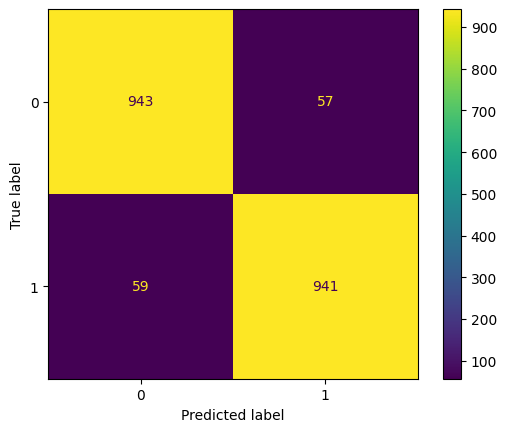

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

confusion_matrix_result = confusion_matrix(y_true=y_true, y_pred=y_preds)

figure = plt.figure(figsize=(15, 5))

disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_result)

disp.plot(values_format='d')

Vemos que o valor de falsos negativos e falsos positivos são bem pequenos em relação as verdadeiros positivos e os verdadeiros negativos. Assim, conseguindo ver de forma mais clara o que a métrica alta do f1 score indica.

In [11]:
recall_score(y_true, y_preds)

0.941

Vemos que o valor de recall do model DenseNet121 feito o fine tunning para o contexto de melanoma, consegue um valor bem interessante, aproximadamente 94% de recall. Basicamente, 94% de suas predições foram nas classes corretas!

# Conclusão

Para um modelo em produção dos testados no trabalho, o melhor seria utilizar o modelo DenseNet121 com fine tunning. Se mostrando mais resiliente, acertivo e que demonstrar predizer com uma acurácia relativamente alta e de forma certa. Nos estudos de suas métricas, foi mostrado também que ele está bem balanceado para as duas classes, não tendo uma quantidade relevante de diferença entre elas, como visto na matriz de confusão.

Conseguimos ver que com o valor de recall que foi conseguido, é possível verificar que na grande maioria dos casos ele acerta a classe de sua predição. Obviamente temos uma base com algumas imagens geradas e verdadeiras, mas indica que seu desempenho com esses tipos de imagens de pele em RGB é relativamente boa, corroborando com o estudo indicado como referencia no tópico do DenseNet121. O modelo conta com uma métrica bem balanceada, ainda mais que foi provido uma base bem distribuída.

O modelo pode ser utilizado em conjunto com médicos especialistas, de forma a auxiliar o diagnóstico. Sendo essencial o conhecimento das métricas do modelo. Então, de posse de todos os dados de métricas do modelo relevantes, e com profissionais capacitados, ele pode ser um modelo que ajude no atendimento de casos, auxiliando um diagnóstico mais rápido. Mas sempre com a palavra final do profissional especialista em medicina, nunca substituindo uma análise de um profissional humano.